In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pandas import DataFrame
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import math


In [2]:
gdp_raw = pd.read_csv("../data/World_Bank_Data.csv")
gdp_data = gdp_raw.drop(["Country Name", "Series Code"], axis=1)
gdp_data = gdp_data.iloc[:-5]
# gdp_data.unstack()
gdp_data = gdp_data.set_index(["Country Code","Series Name"])
gdp_data = gdp_data.stack().unstack(1)
# gdp_data["Series Name"].unique()
# gdp_raw["Series Name"].unique()

# PICK GDP DATA COLUMNS HERE
gdp_data = gdp_data[['GDP per capita (current US$)', 'Population, total']].reset_index()
gdp_data["Year"] = gdp_data["level_1"].str.split().str.get(0)
gdp_data["Year"] = pd.to_numeric(gdp_data["Year"])
gdp_data = gdp_data.drop("level_1", axis=1)
# gdp_data
# gdp_data[gdp_data["Country Code"] == "DEU"]

gdp_data['GDP per capita (current US$)'] = pd.to_numeric(gdp_data['GDP per capita (current US$)'], errors='coerce')
average_gdp_data = gdp_data.groupby(['Country Code'])['GDP per capita (current US$)'].mean().reset_index()
# average_gdp_by_country_year

country_code = pd.read_csv("../data/COW-country-codes.csv")
country_dict = pd.Series(country_code['StateNme'].values, index=country_code['StateAbb']).to_dict()

cleaned_gdp_data = {}

country_info_pd = pd.read_csv("../data/country_info.csv")
country_name_to_code = pd.Series(country_info_pd['code'].values, index=country_info_pd['name']).to_dict()
for index, row in average_gdp_data.iterrows():
    #print(row)
    if row['Country Code'] not in country_dict:
        continue
    if country_dict[row['Country Code']] in country_info_pd['name'].tolist():
        cleaned_gdp_data[country_name_to_code[country_dict[row['Country Code']]]] = row['GDP per capita (current US$)']

values = list(cleaned_gdp_data.values())
keys = list(cleaned_gdp_data.keys())
n = len(keys)
gdp_difference_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        gdp_difference_matrix[i, j] = values[i] - values[j]


votes_path = "../data/votes.csv"
#country_code_list = list(country_name_to_code.values())
map_code_to_idx = {code: idx for idx, code in enumerate(keys)}
country_num = len(values)

votes_df = pd.read_csv(votes_path)
votes_array = np.array(votes_df) 
votes_list = votes_array.tolist()  

votes_matrix_total = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_jury = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_tele = [[0 for i in range(country_num)] for j in range(country_num)]

for vote in votes_list:
    # if vote[0] != 2023 or vote[1] != 'final':  # only consider 2023, final and total points
    # continue
    from_country_code, to_country_code, total_points = vote[2], vote[3], vote[-3]
    if from_country_code not in keys or to_country_code not in keys:
        continue
    votes_matrix_total[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += total_points
    if not math.isnan(vote[-2]):
        votes_matrix_tele[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-2]
    if not math.isnan(vote[-1]):
        votes_matrix_jury[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-1]



In [3]:
def clustering_one_and_visualize_by_pca(D, V, num_clusters, method='KMeans'):
    # Preprocess data: Impute missing values and normalize
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    D_imputed = imputer.fit_transform(D)
    V_imputed = imputer.transform(V)  # Use the same transformation for V
    
    D_scaled = scaler.fit_transform(D_imputed)
    V_scaled = scaler.transform(V_imputed)  # Use the same transformation for V

    # Clustering
    if method == 'KMeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=42)
    elif method == 'SpectralClustering':
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=42, assign_labels="discretize")
    
    labels = clustering.fit_predict(D_scaled)  # Only fit on D

    # Random labels for comparison
    random_labels = np.random.randint(num_clusters, size=len(D))

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    D_pca = pca.fit_transform(D_scaled)
    V_pca = pca.transform(V_scaled)  # Use the same PCA transformation for V

    # Visualization of original clustering
    plt.figure(figsize=(24, 12))

    plt.subplot(2, 2, 1)
    for cluster in range(num_clusters):
        cluster_points = D_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of GDP Matrix (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 2)
    for cluster in range(num_clusters):
        cluster_points = V_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Voting Matrix (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    # Visualization of random clustering
    plt.subplot(2, 2, 3)
    for cluster in range(num_clusters):
        cluster_points = D_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of GDP Matrix (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 4)
    for cluster in range(num_clusters):
        cluster_points = V_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Voting Matrix (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluation
    silhouette_score_D = silhouette_score(D_scaled, labels)
    silhouette_score_V = silhouette_score(V_scaled, labels)
    silhouette_score_D_random = silhouette_score(D_scaled, random_labels)
    silhouette_score_V_random = silhouette_score(V_scaled, random_labels)

    print(f"The silhouette score for GDP Matrix (Original) is: {silhouette_score_D}")
    print(f"The silhouette score for Voting Matrix (Original) is: {silhouette_score_V}")
    print(f"The silhouette score for GDP Matrix (Random) is: {silhouette_score_D_random}")
    print(f"The silhouette score for Voting Matrix (Random) is: {silhouette_score_V_random}")

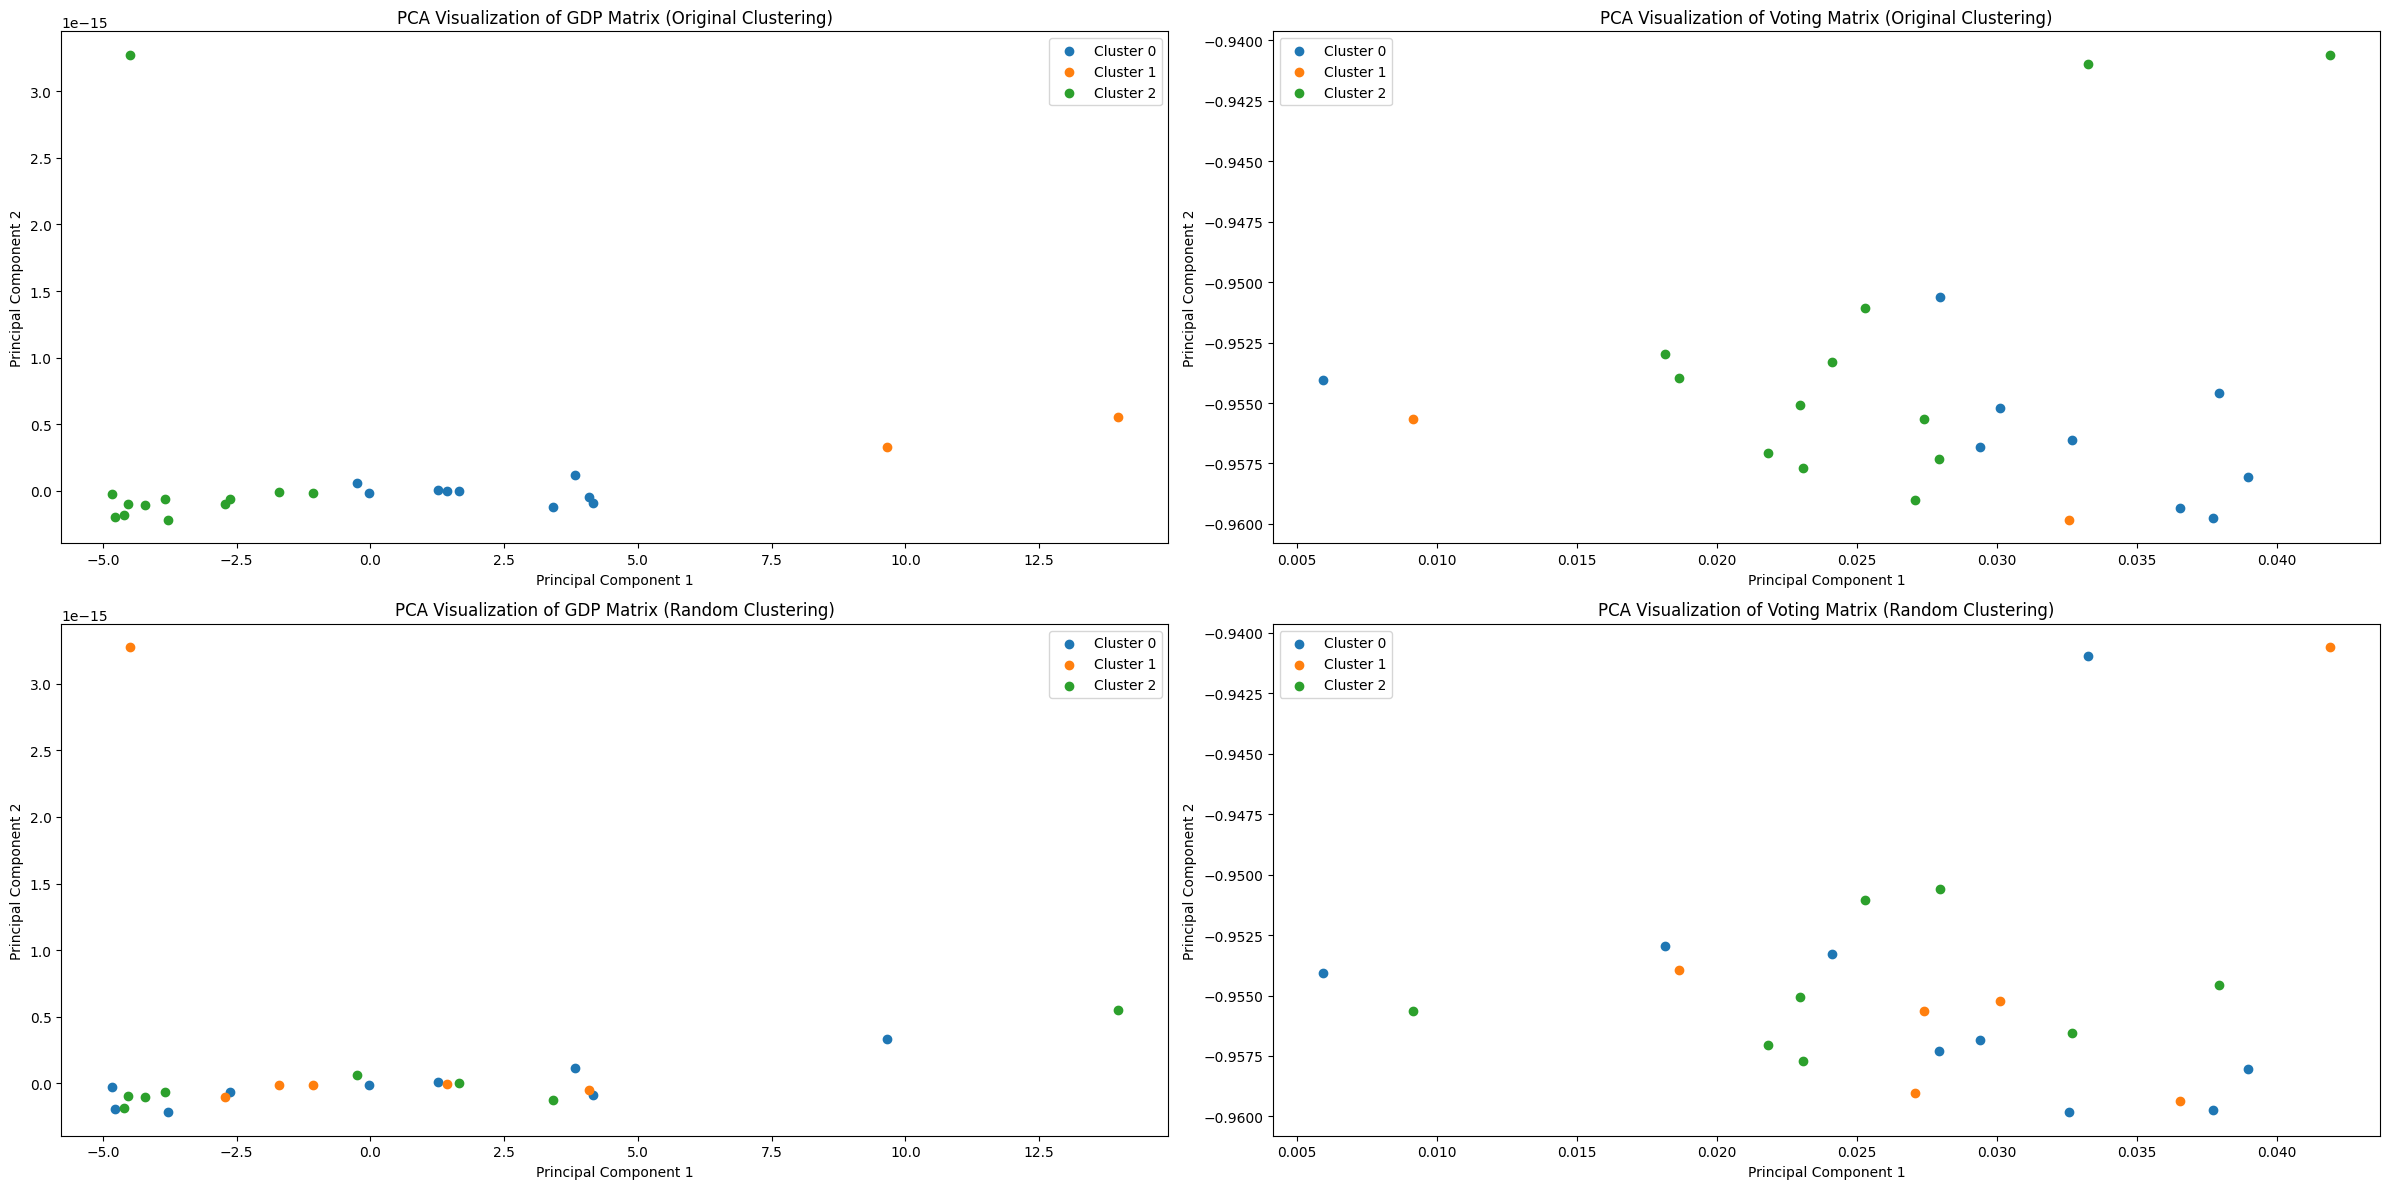

The silhouette score for GDP Matrix (Original) is: 0.6520224710194664
The silhouette score for Voting Matrix (Original) is: -0.01991295919212094
The silhouette score for GDP Matrix (Random) is: -0.1829415829475524
The silhouette score for Voting Matrix (Random) is: -0.05713587426111446


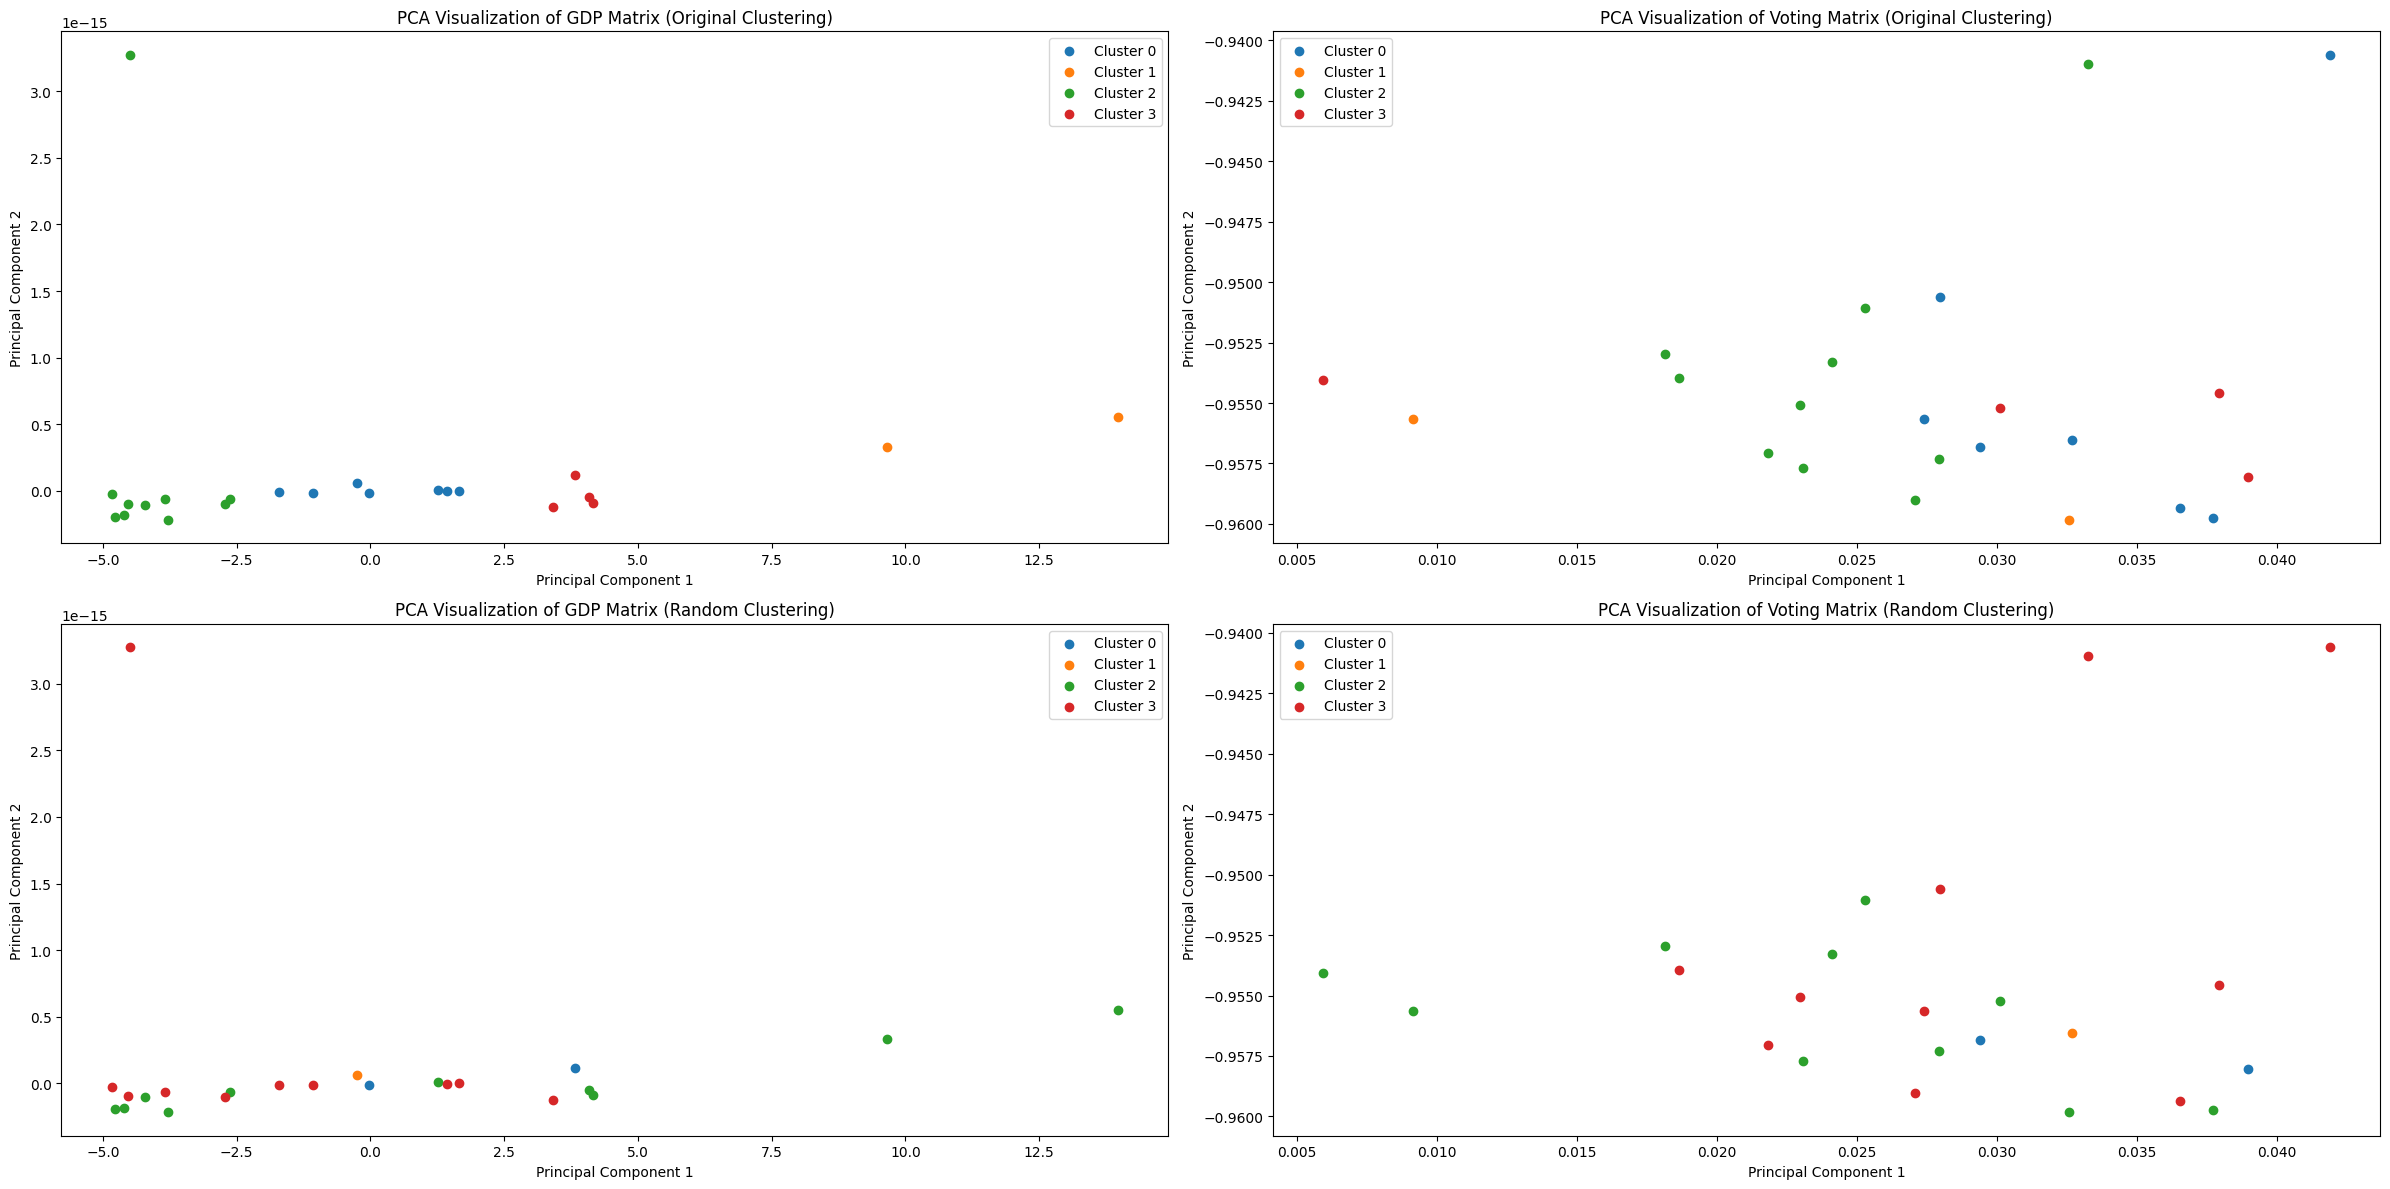

The silhouette score for GDP Matrix (Original) is: 0.6463152669399786
The silhouette score for Voting Matrix (Original) is: -0.021657168950001828
The silhouette score for GDP Matrix (Random) is: -0.35970443849215633
The silhouette score for Voting Matrix (Random) is: -0.11429087100880989


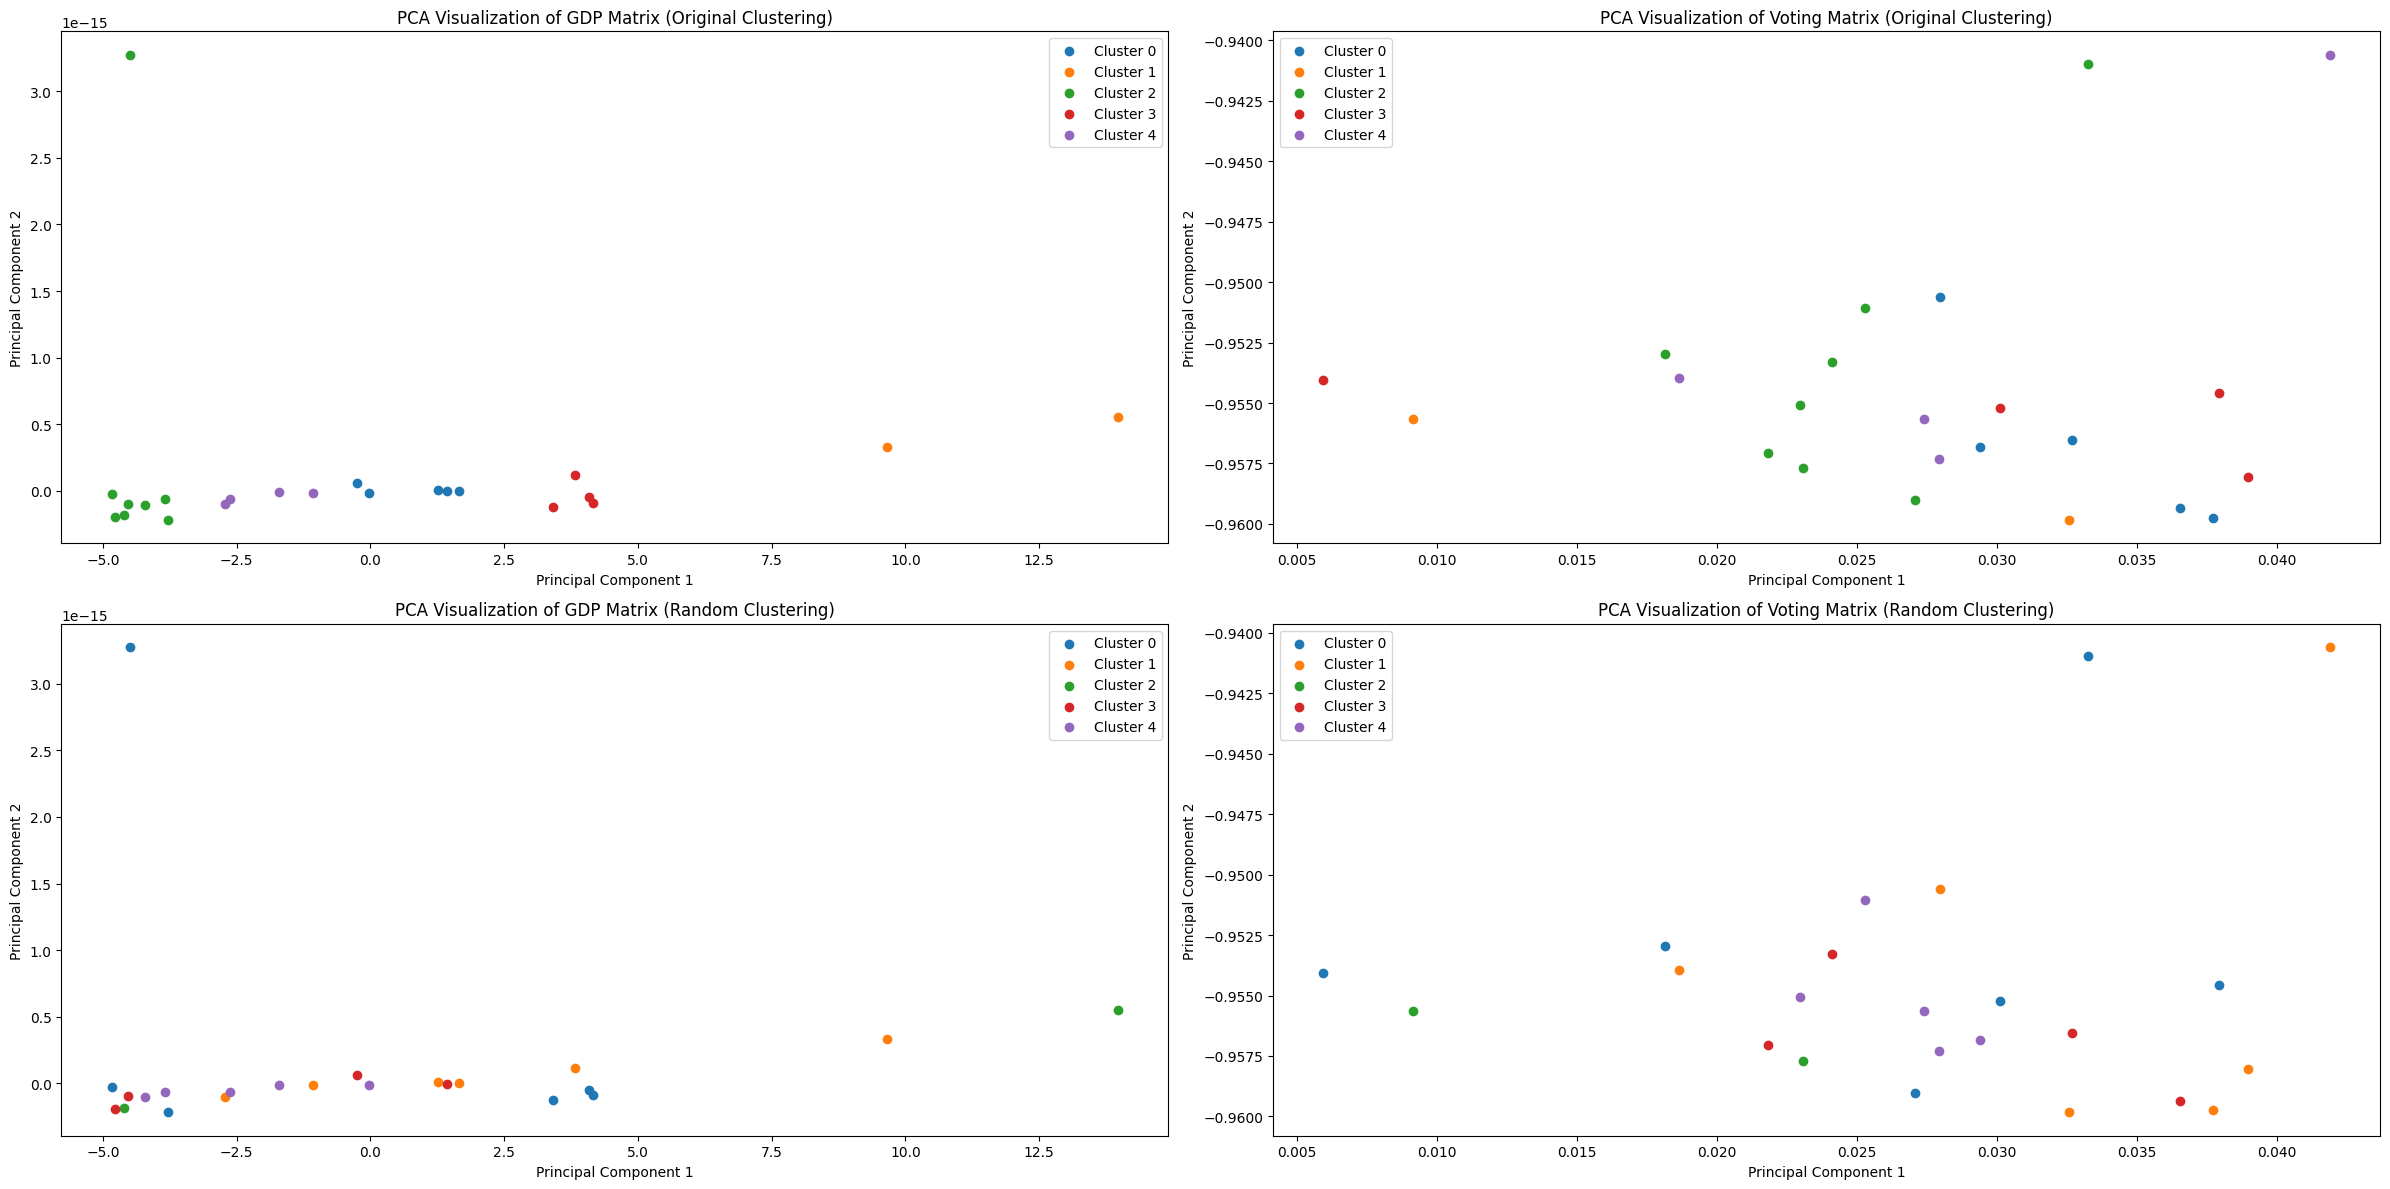

The silhouette score for GDP Matrix (Original) is: 0.6525969651852452
The silhouette score for Voting Matrix (Original) is: -0.05003928007383469
The silhouette score for GDP Matrix (Random) is: -0.2502896210591145
The silhouette score for Voting Matrix (Random) is: -0.10855507488937474


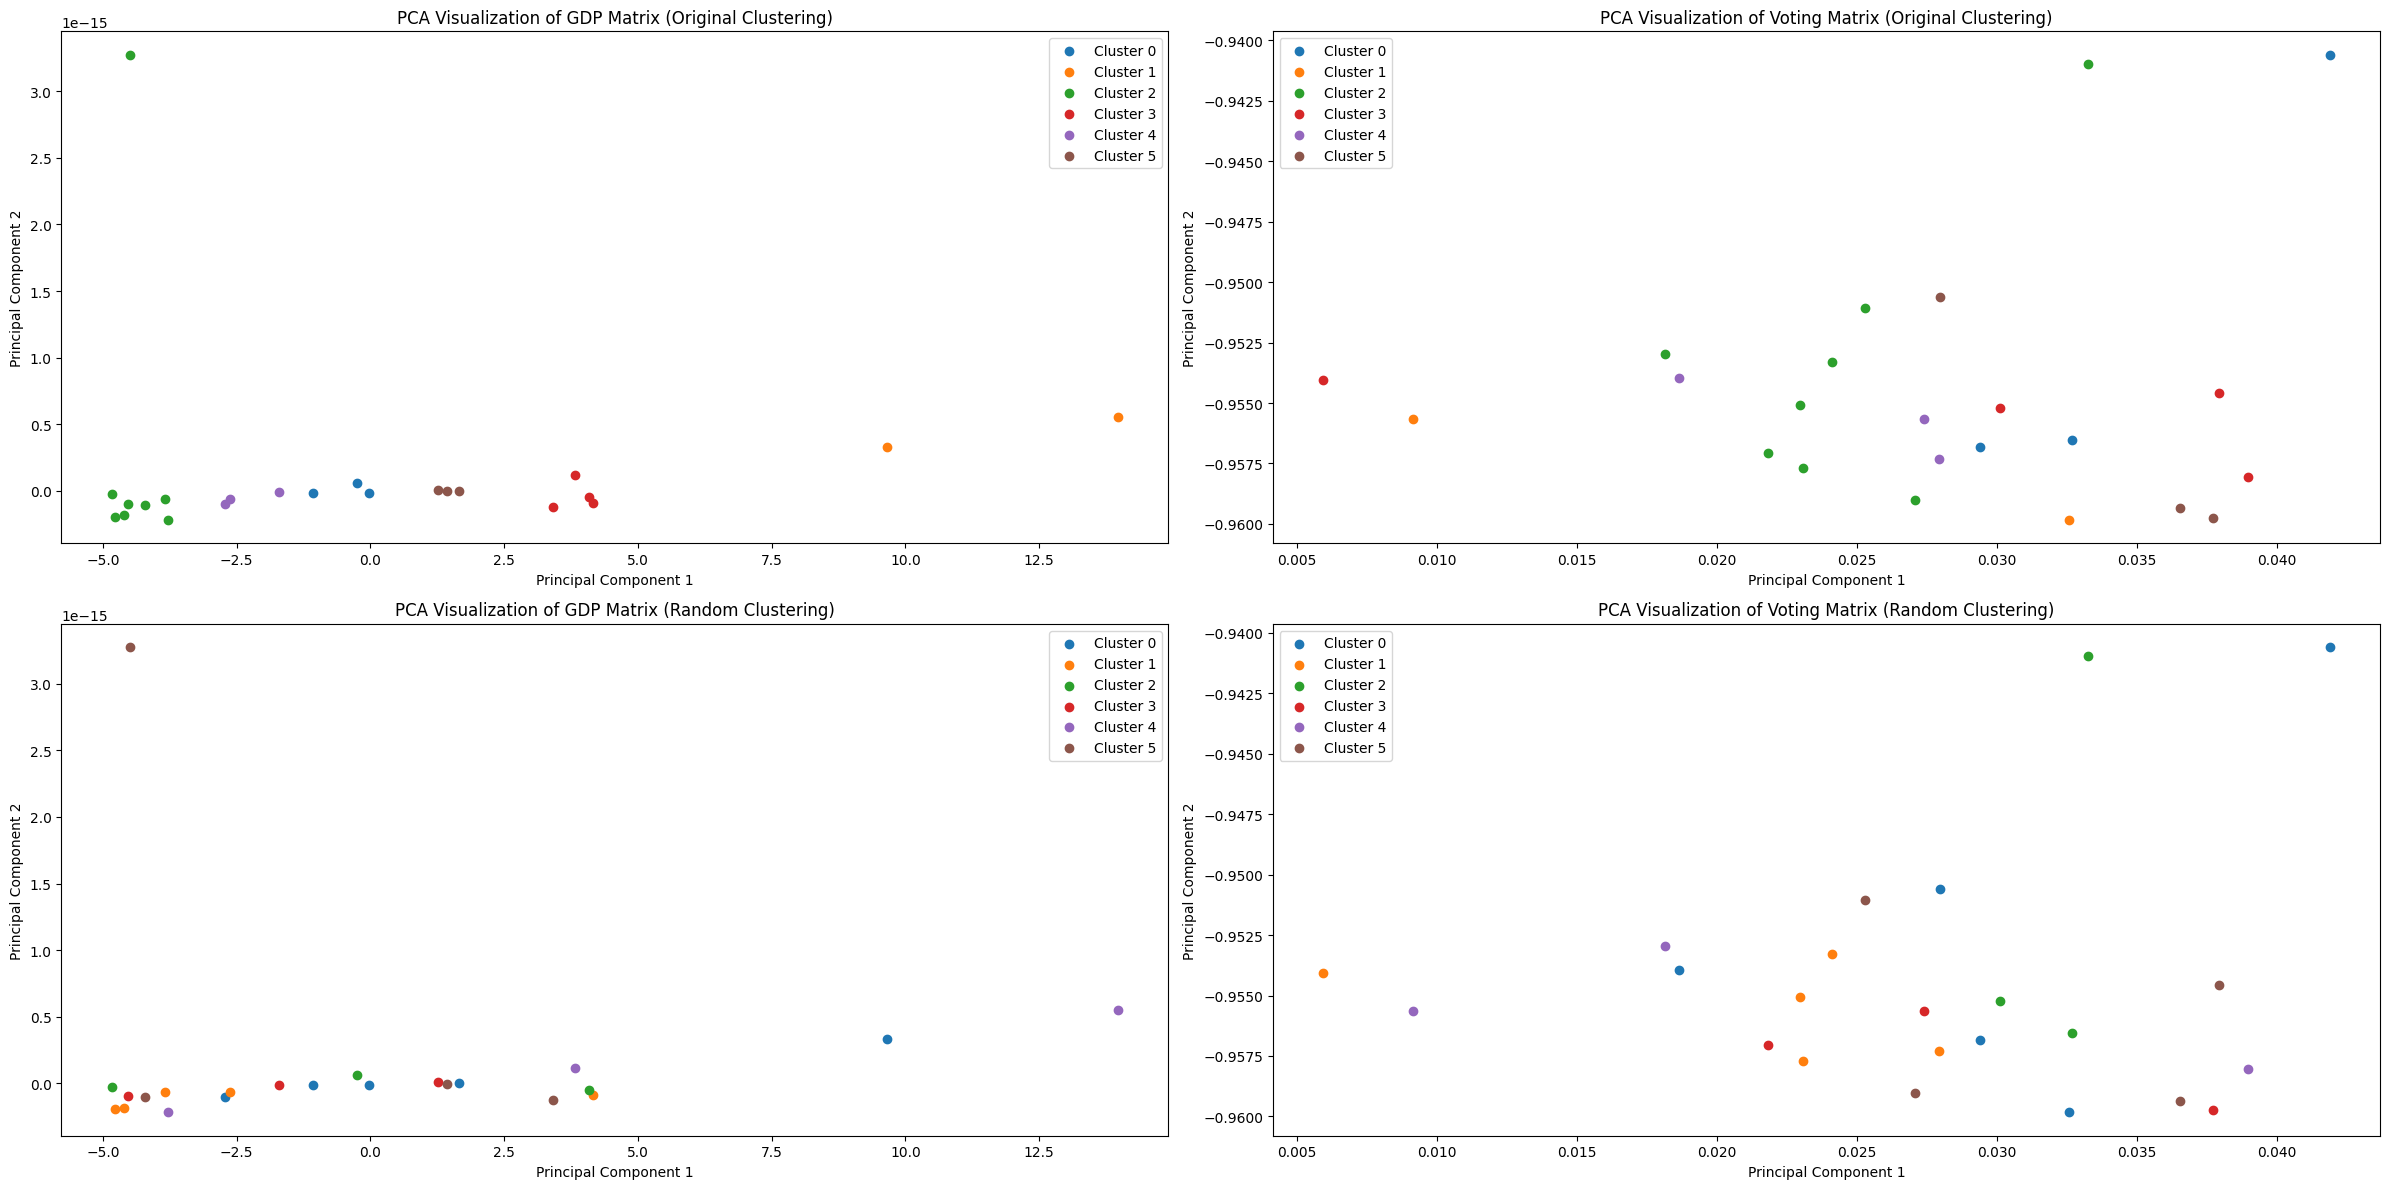

The silhouette score for GDP Matrix (Original) is: 0.6891396740098831
The silhouette score for Voting Matrix (Original) is: -0.0830364673499849
The silhouette score for GDP Matrix (Random) is: -0.3314062771970363
The silhouette score for Voting Matrix (Random) is: -0.10145324532085222


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


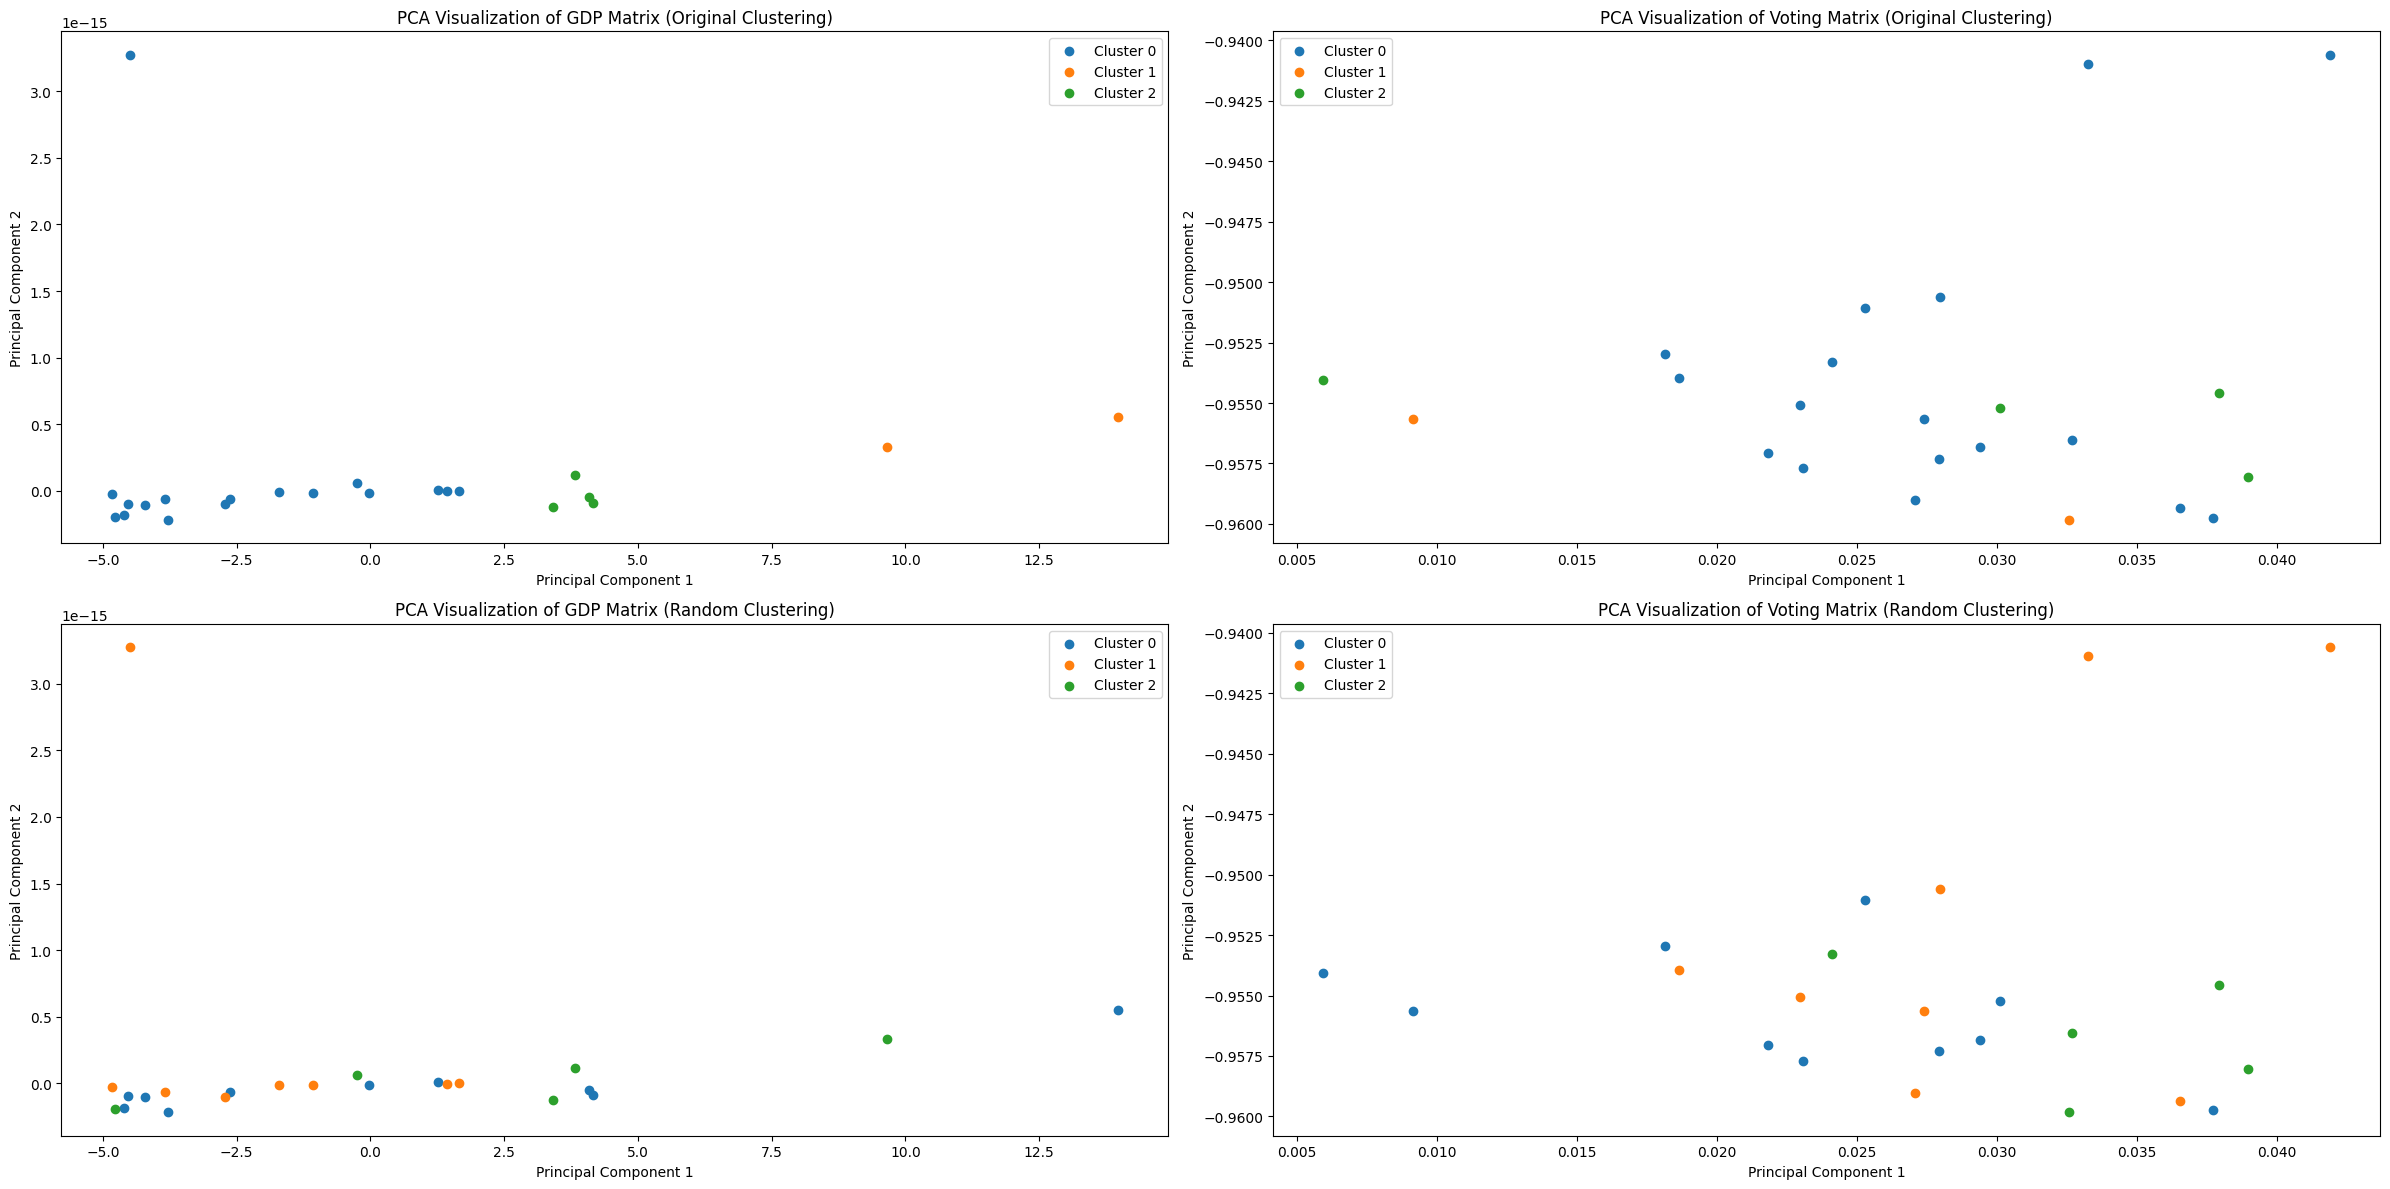

The silhouette score for GDP Matrix (Original) is: 0.5222077361464501
The silhouette score for Voting Matrix (Original) is: -0.011358819756899141
The silhouette score for GDP Matrix (Random) is: -0.11745951191523119
The silhouette score for Voting Matrix (Random) is: -0.021155009789819344


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


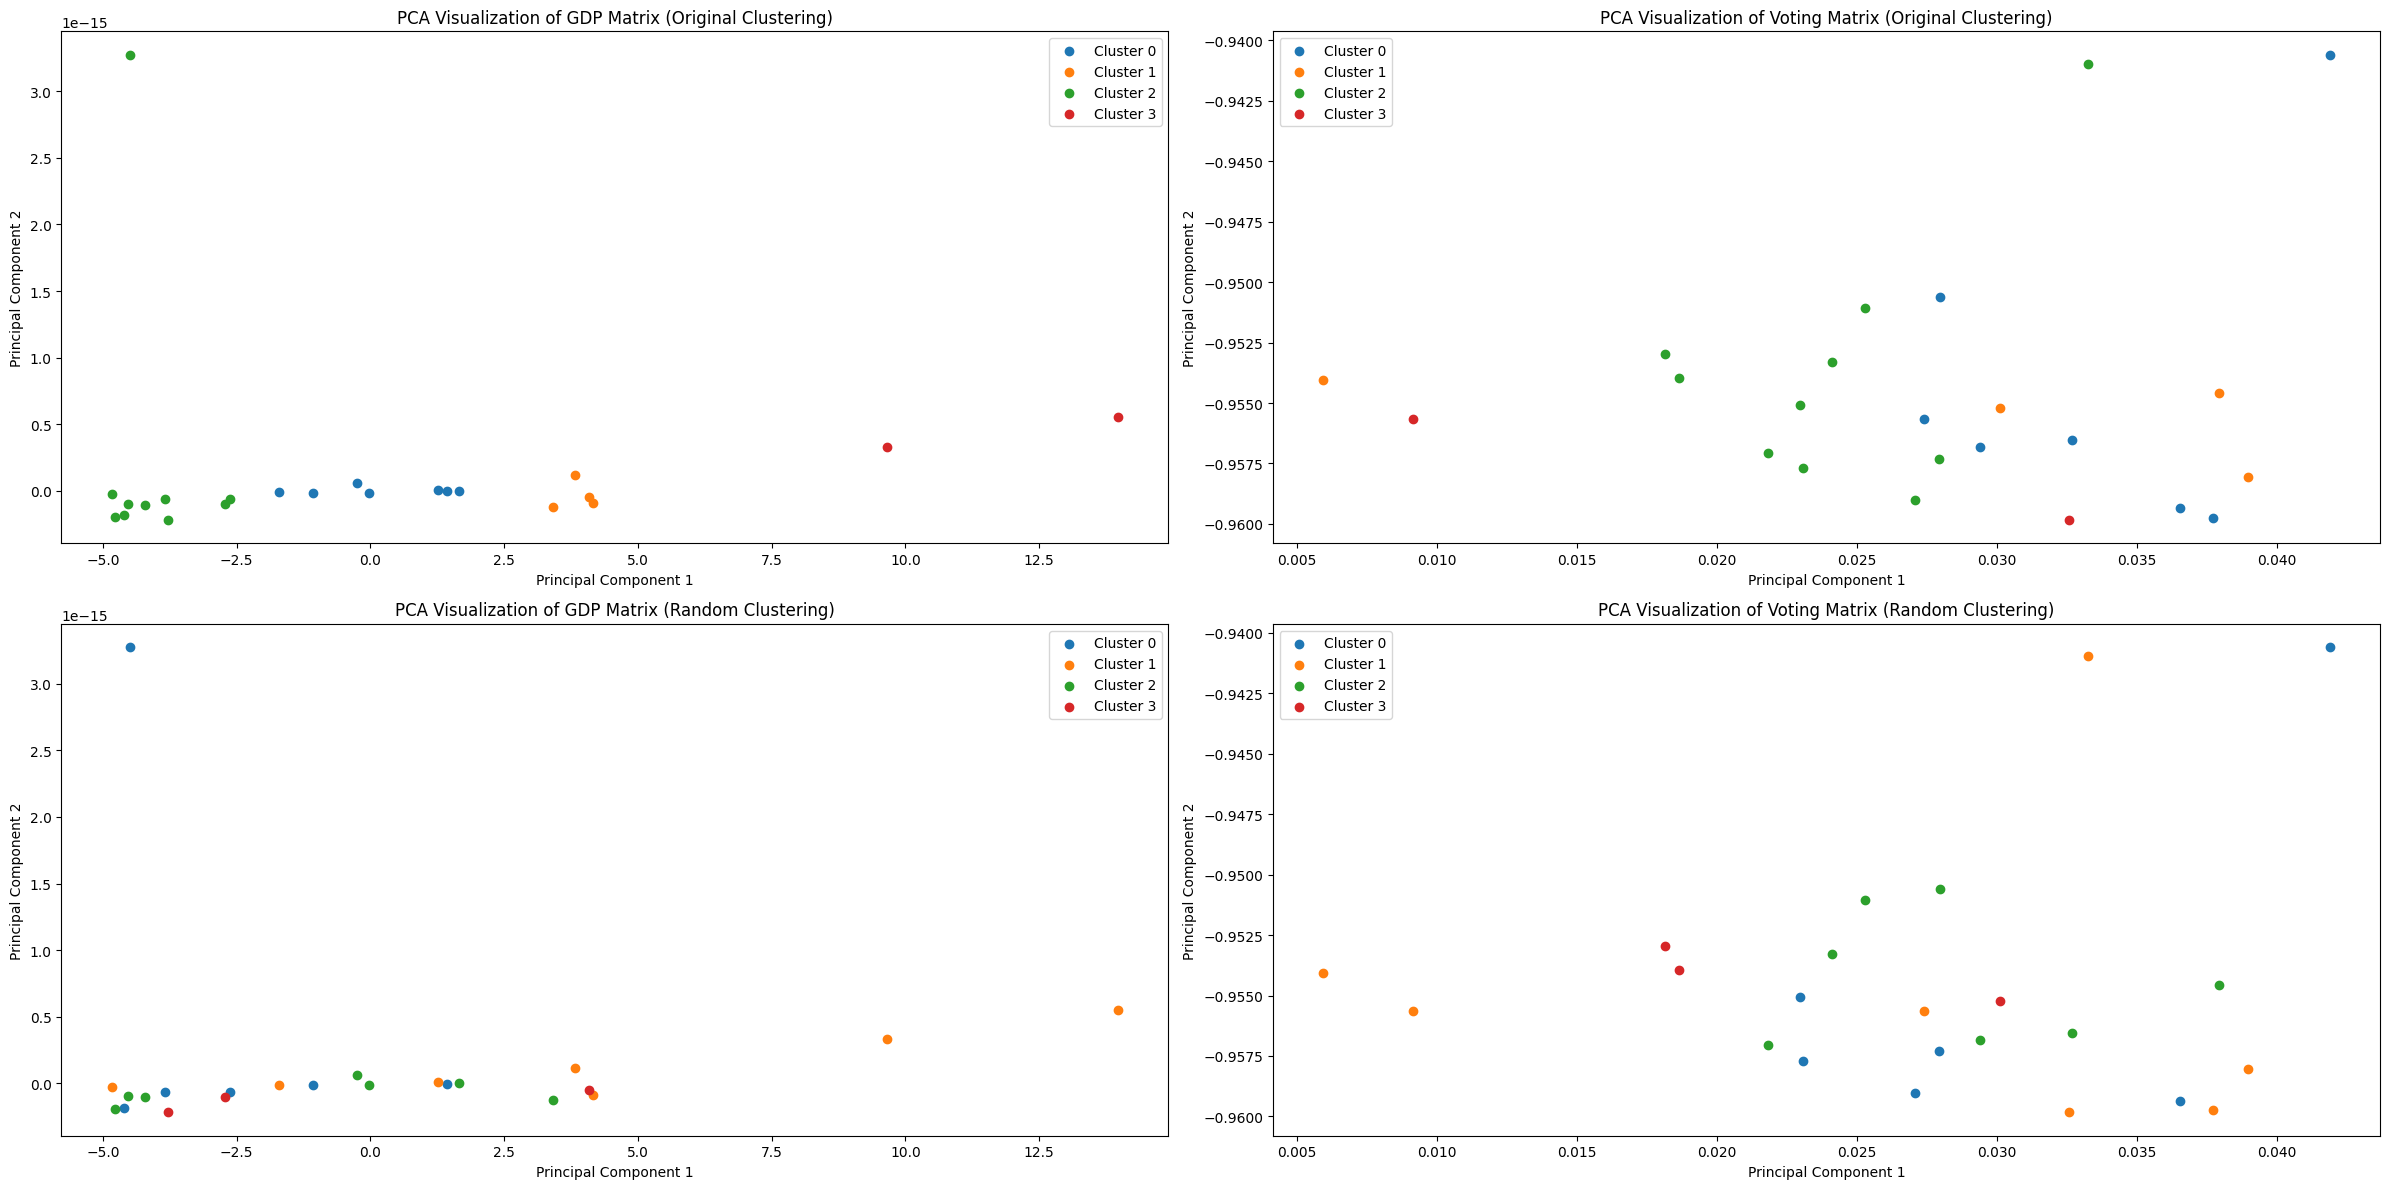

The silhouette score for GDP Matrix (Original) is: 0.6463152669399786
The silhouette score for Voting Matrix (Original) is: -0.021657168950001828
The silhouette score for GDP Matrix (Random) is: -0.1830880600715347
The silhouette score for Voting Matrix (Random) is: -0.11202773485224511


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


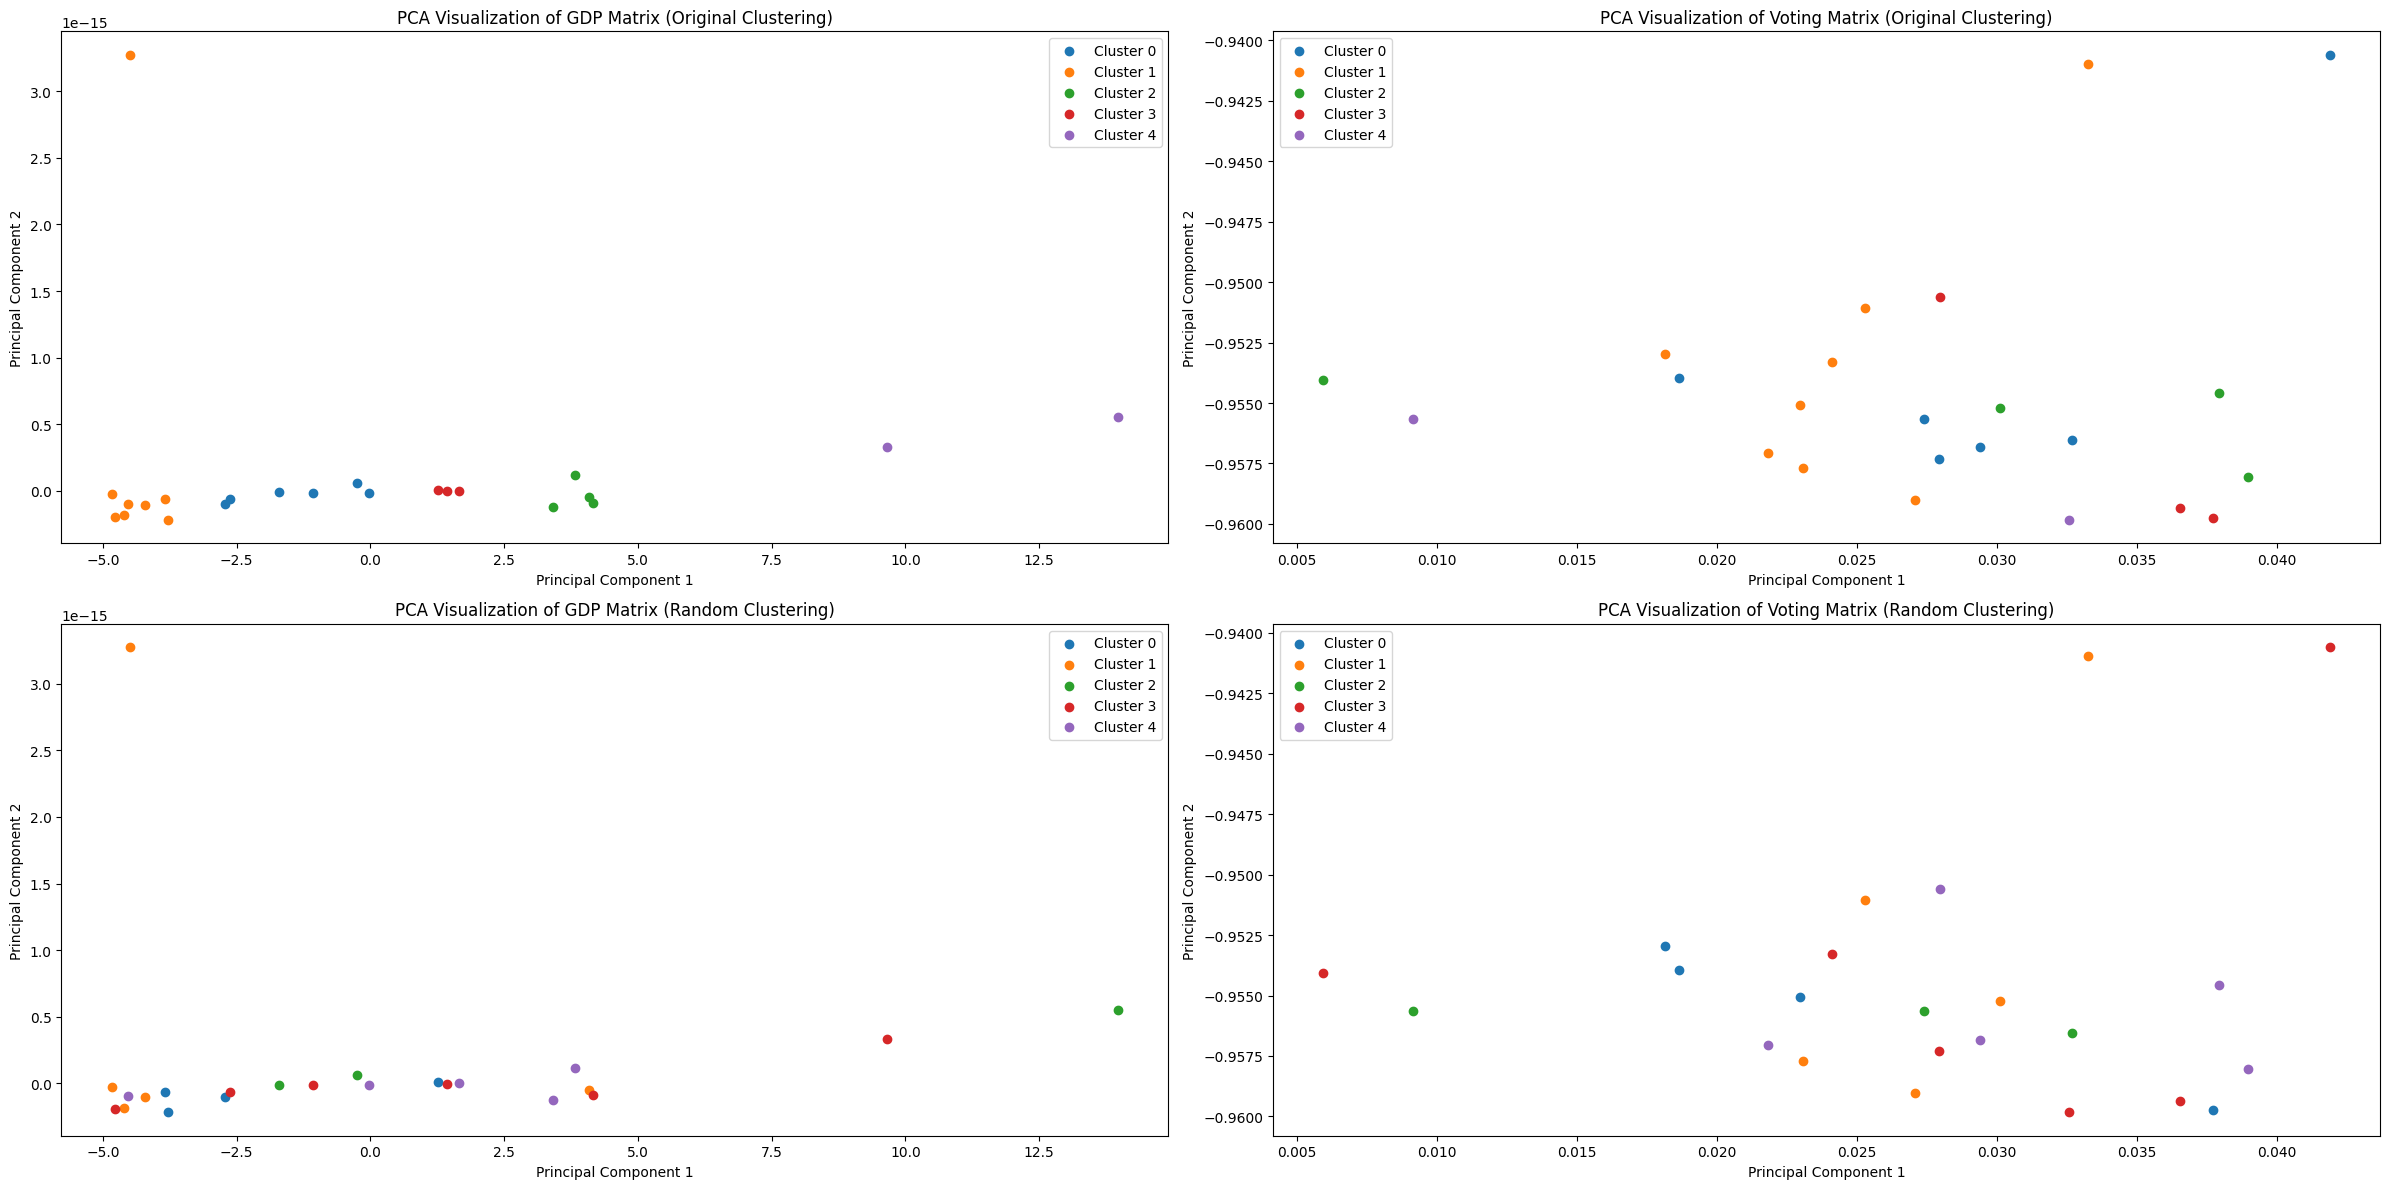

The silhouette score for GDP Matrix (Original) is: 0.643908088718305
The silhouette score for Voting Matrix (Original) is: -0.05274556398386326
The silhouette score for GDP Matrix (Random) is: -0.24758086597228077
The silhouette score for Voting Matrix (Random) is: -0.11618084250459433


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


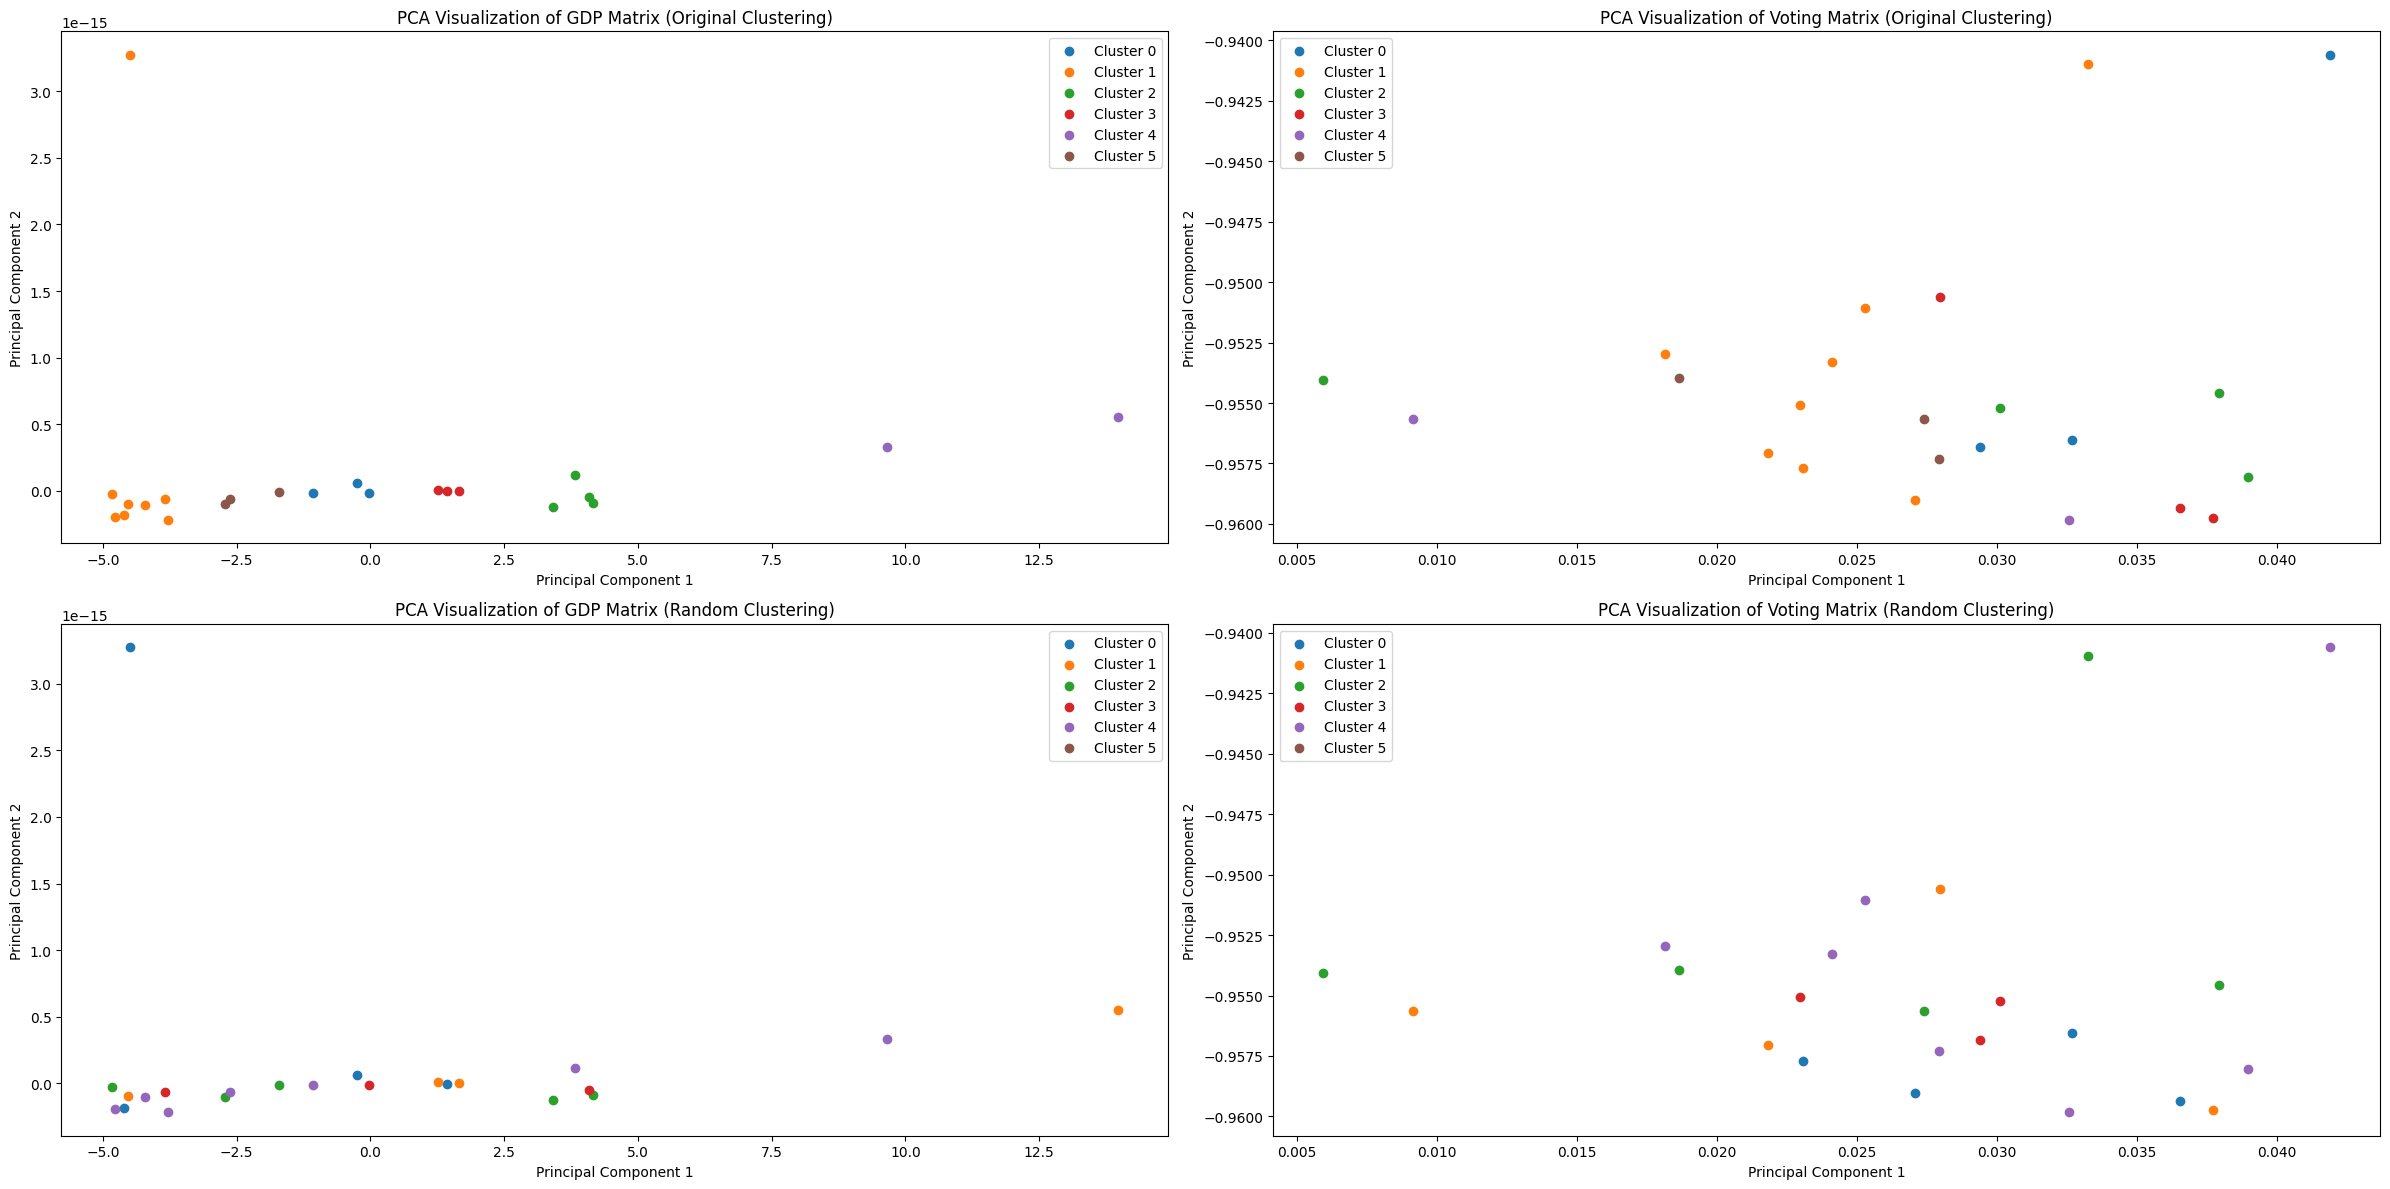

The silhouette score for GDP Matrix (Original) is: 0.6891396740098831
The silhouette score for Voting Matrix (Original) is: -0.0830364673499849
The silhouette score for GDP Matrix (Random) is: -0.33122971118288097
The silhouette score for Voting Matrix (Random) is: -0.1086977696180958


In [4]:
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 3, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 4, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 5, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 6, method='KMeans')

clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_total, 6, method='SpectralClustering')

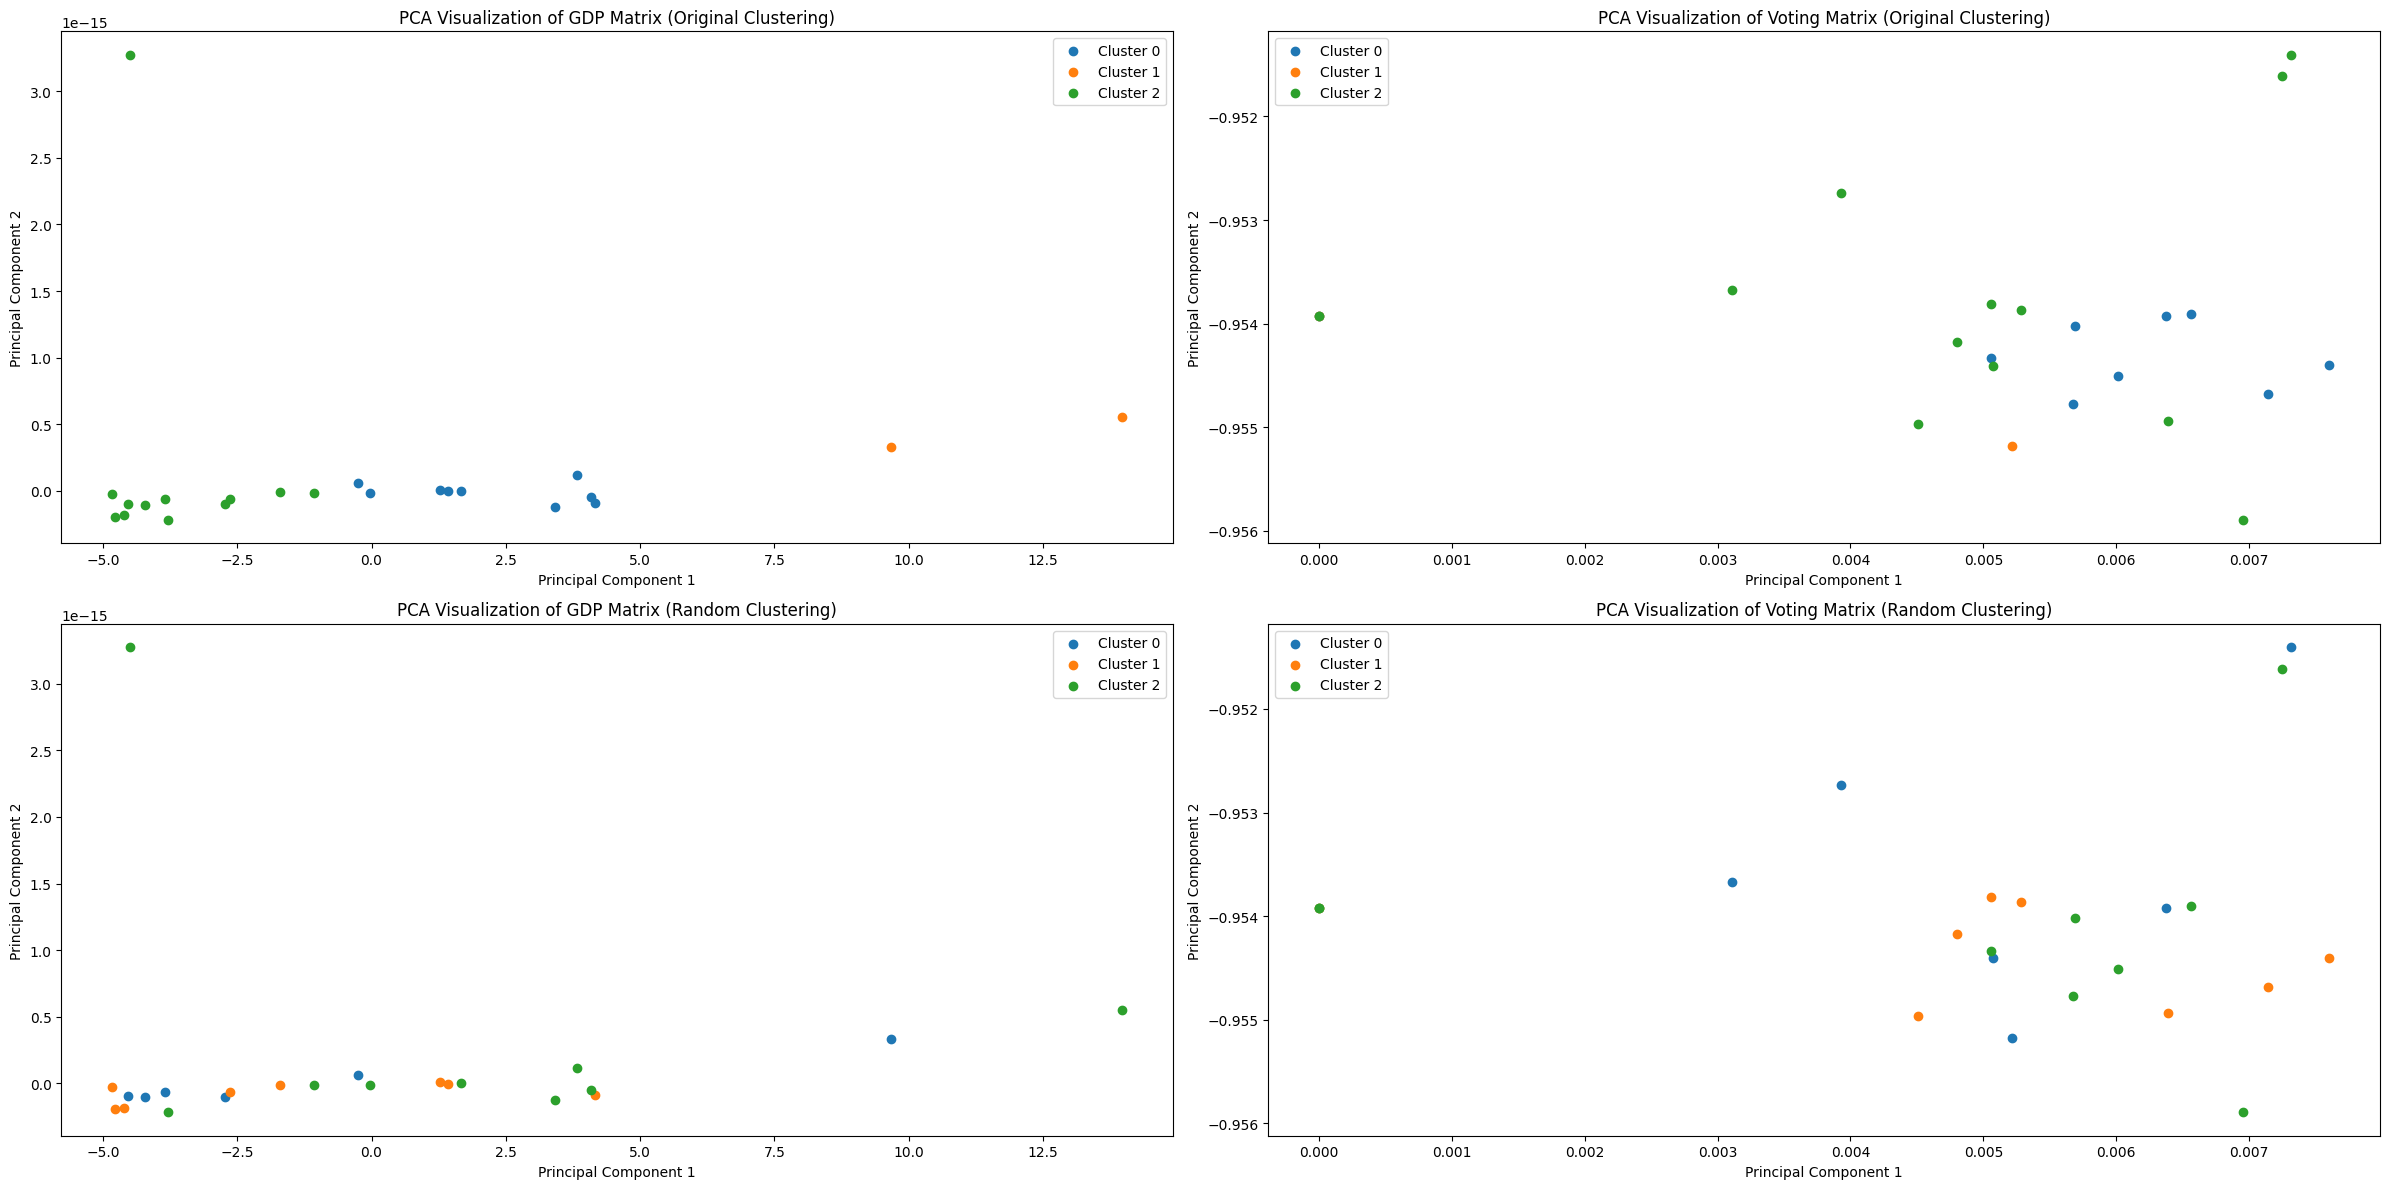

The silhouette score for GDP Matrix (Original) is: 0.6520224710194664
The silhouette score for Voting Matrix (Original) is: -0.11414867719298219
The silhouette score for GDP Matrix (Random) is: -0.14779634612504483
The silhouette score for Voting Matrix (Random) is: -0.03564628169780528


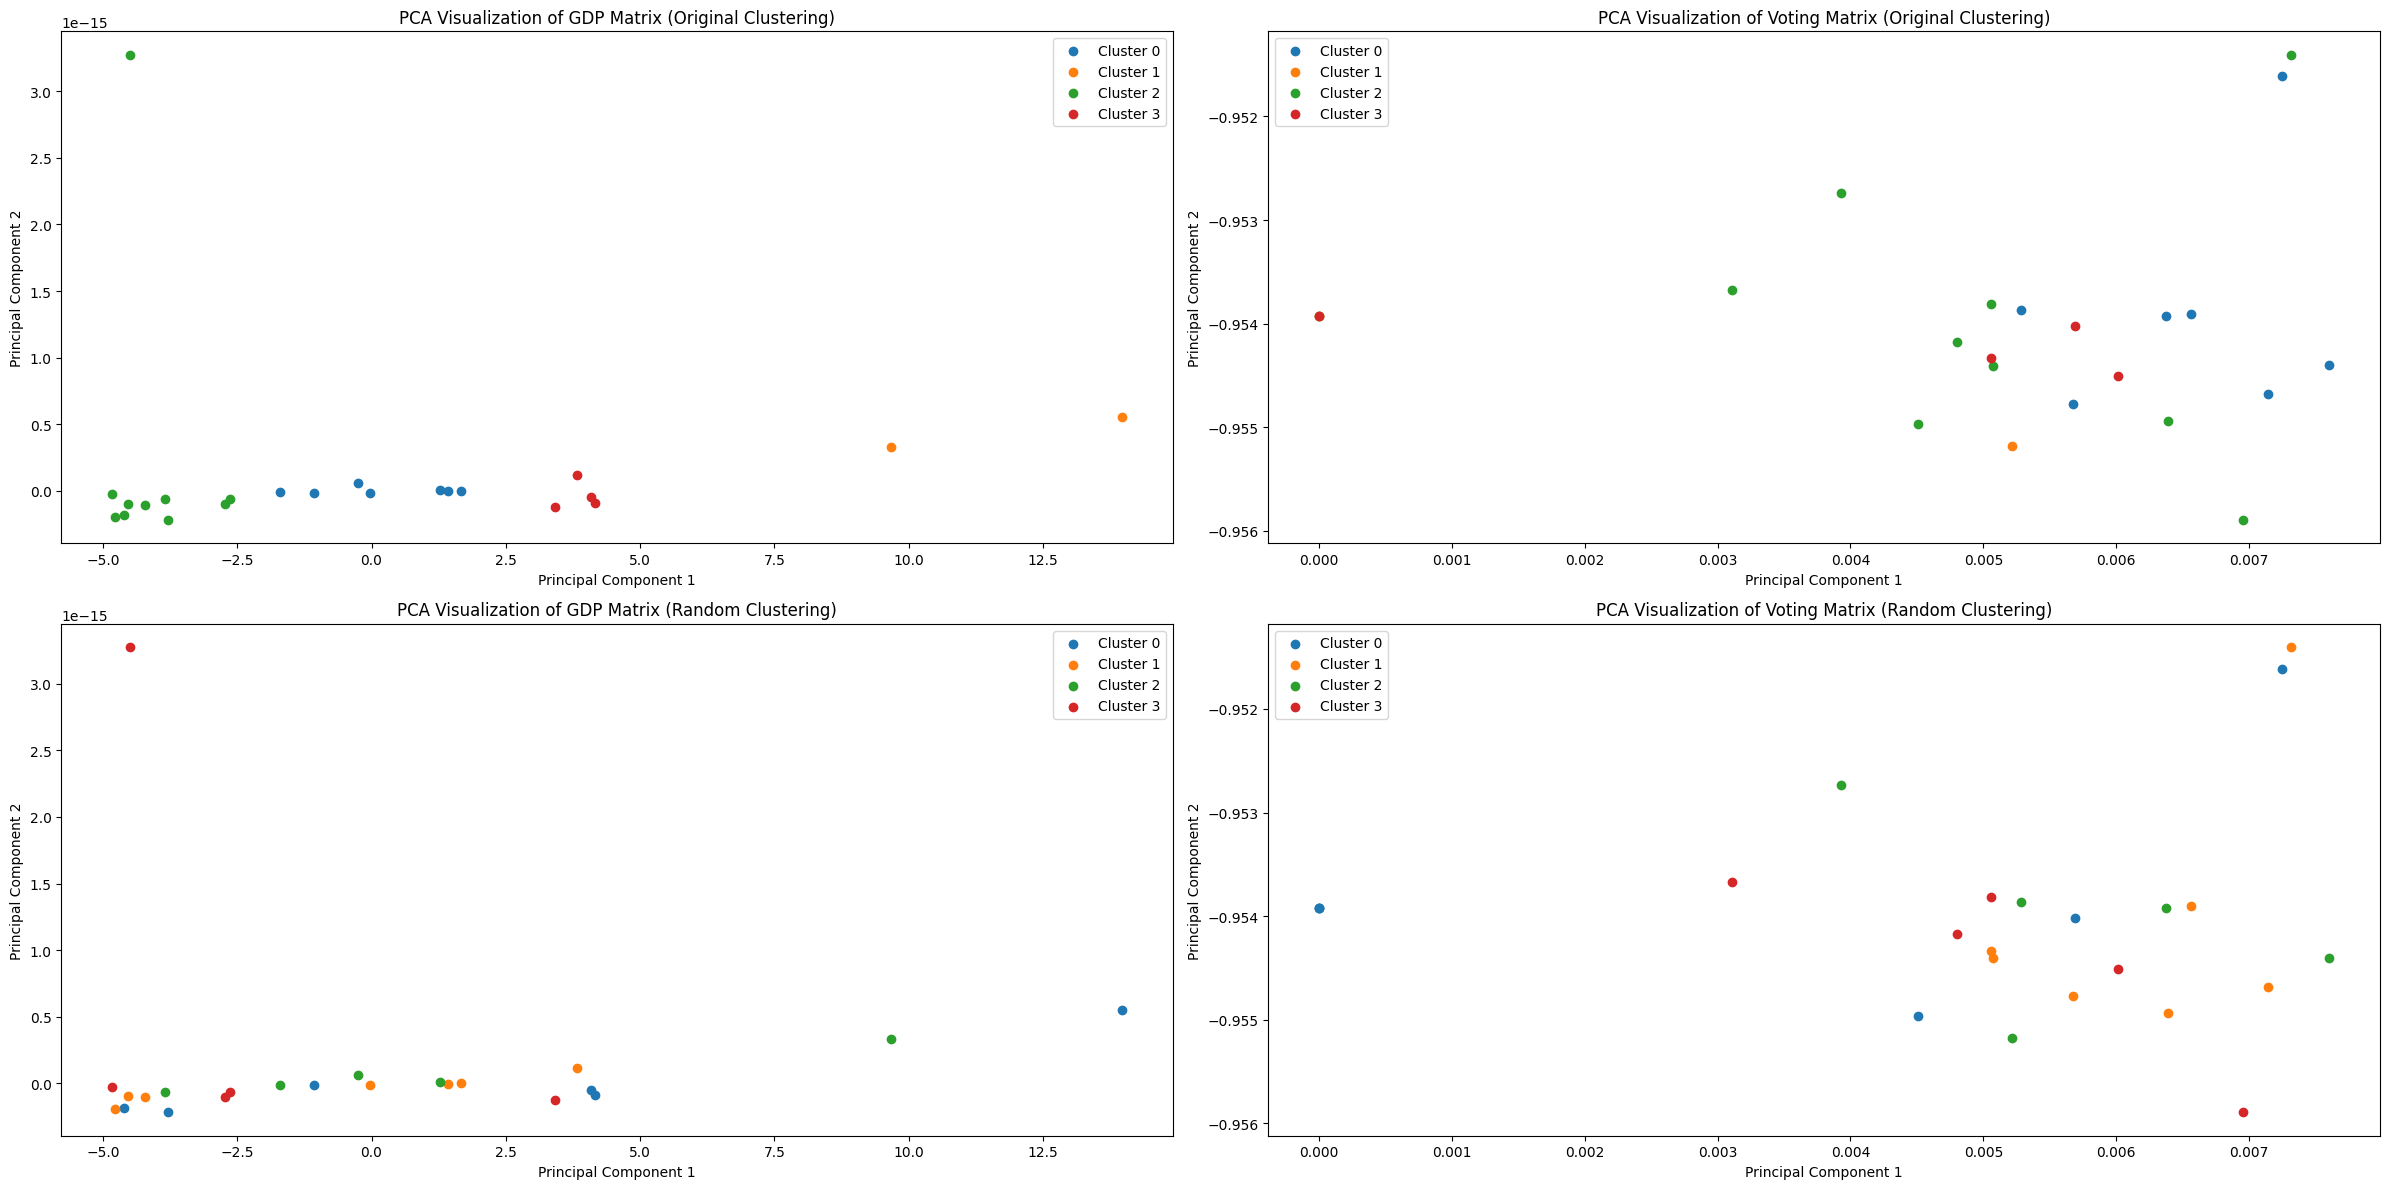

The silhouette score for GDP Matrix (Original) is: 0.6463152669399786
The silhouette score for Voting Matrix (Original) is: -0.12800303797653798
The silhouette score for GDP Matrix (Random) is: -0.2241892930546175
The silhouette score for Voting Matrix (Random) is: -0.032443653816146265


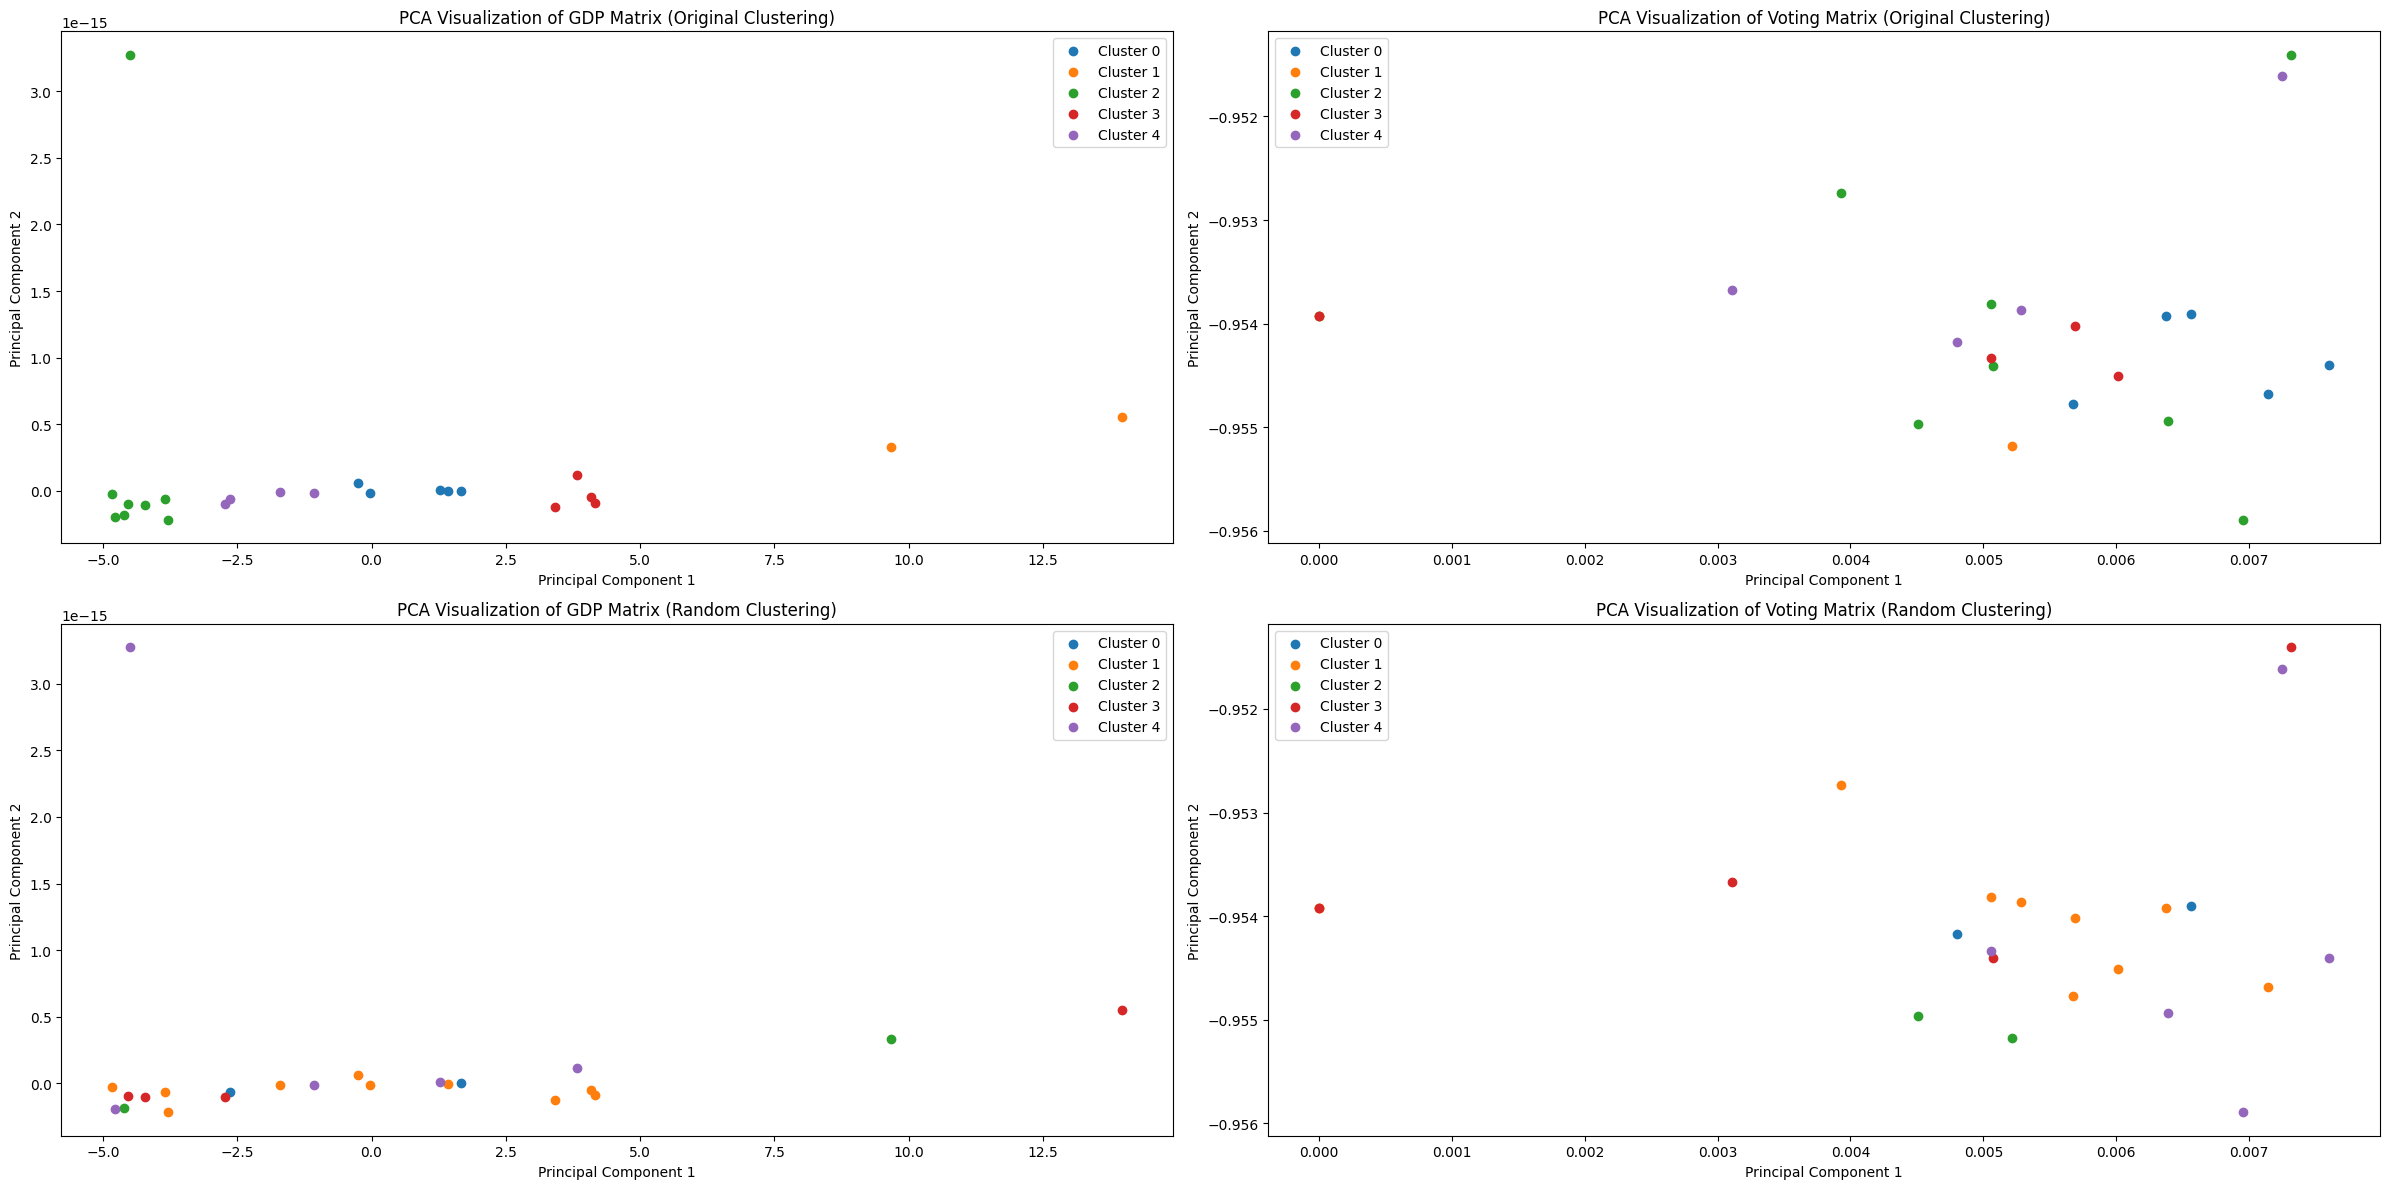

The silhouette score for GDP Matrix (Original) is: 0.6525969651852452
The silhouette score for Voting Matrix (Original) is: -0.13897751306721864
The silhouette score for GDP Matrix (Random) is: -0.3112425127162462
The silhouette score for Voting Matrix (Random) is: -0.09267915631546698


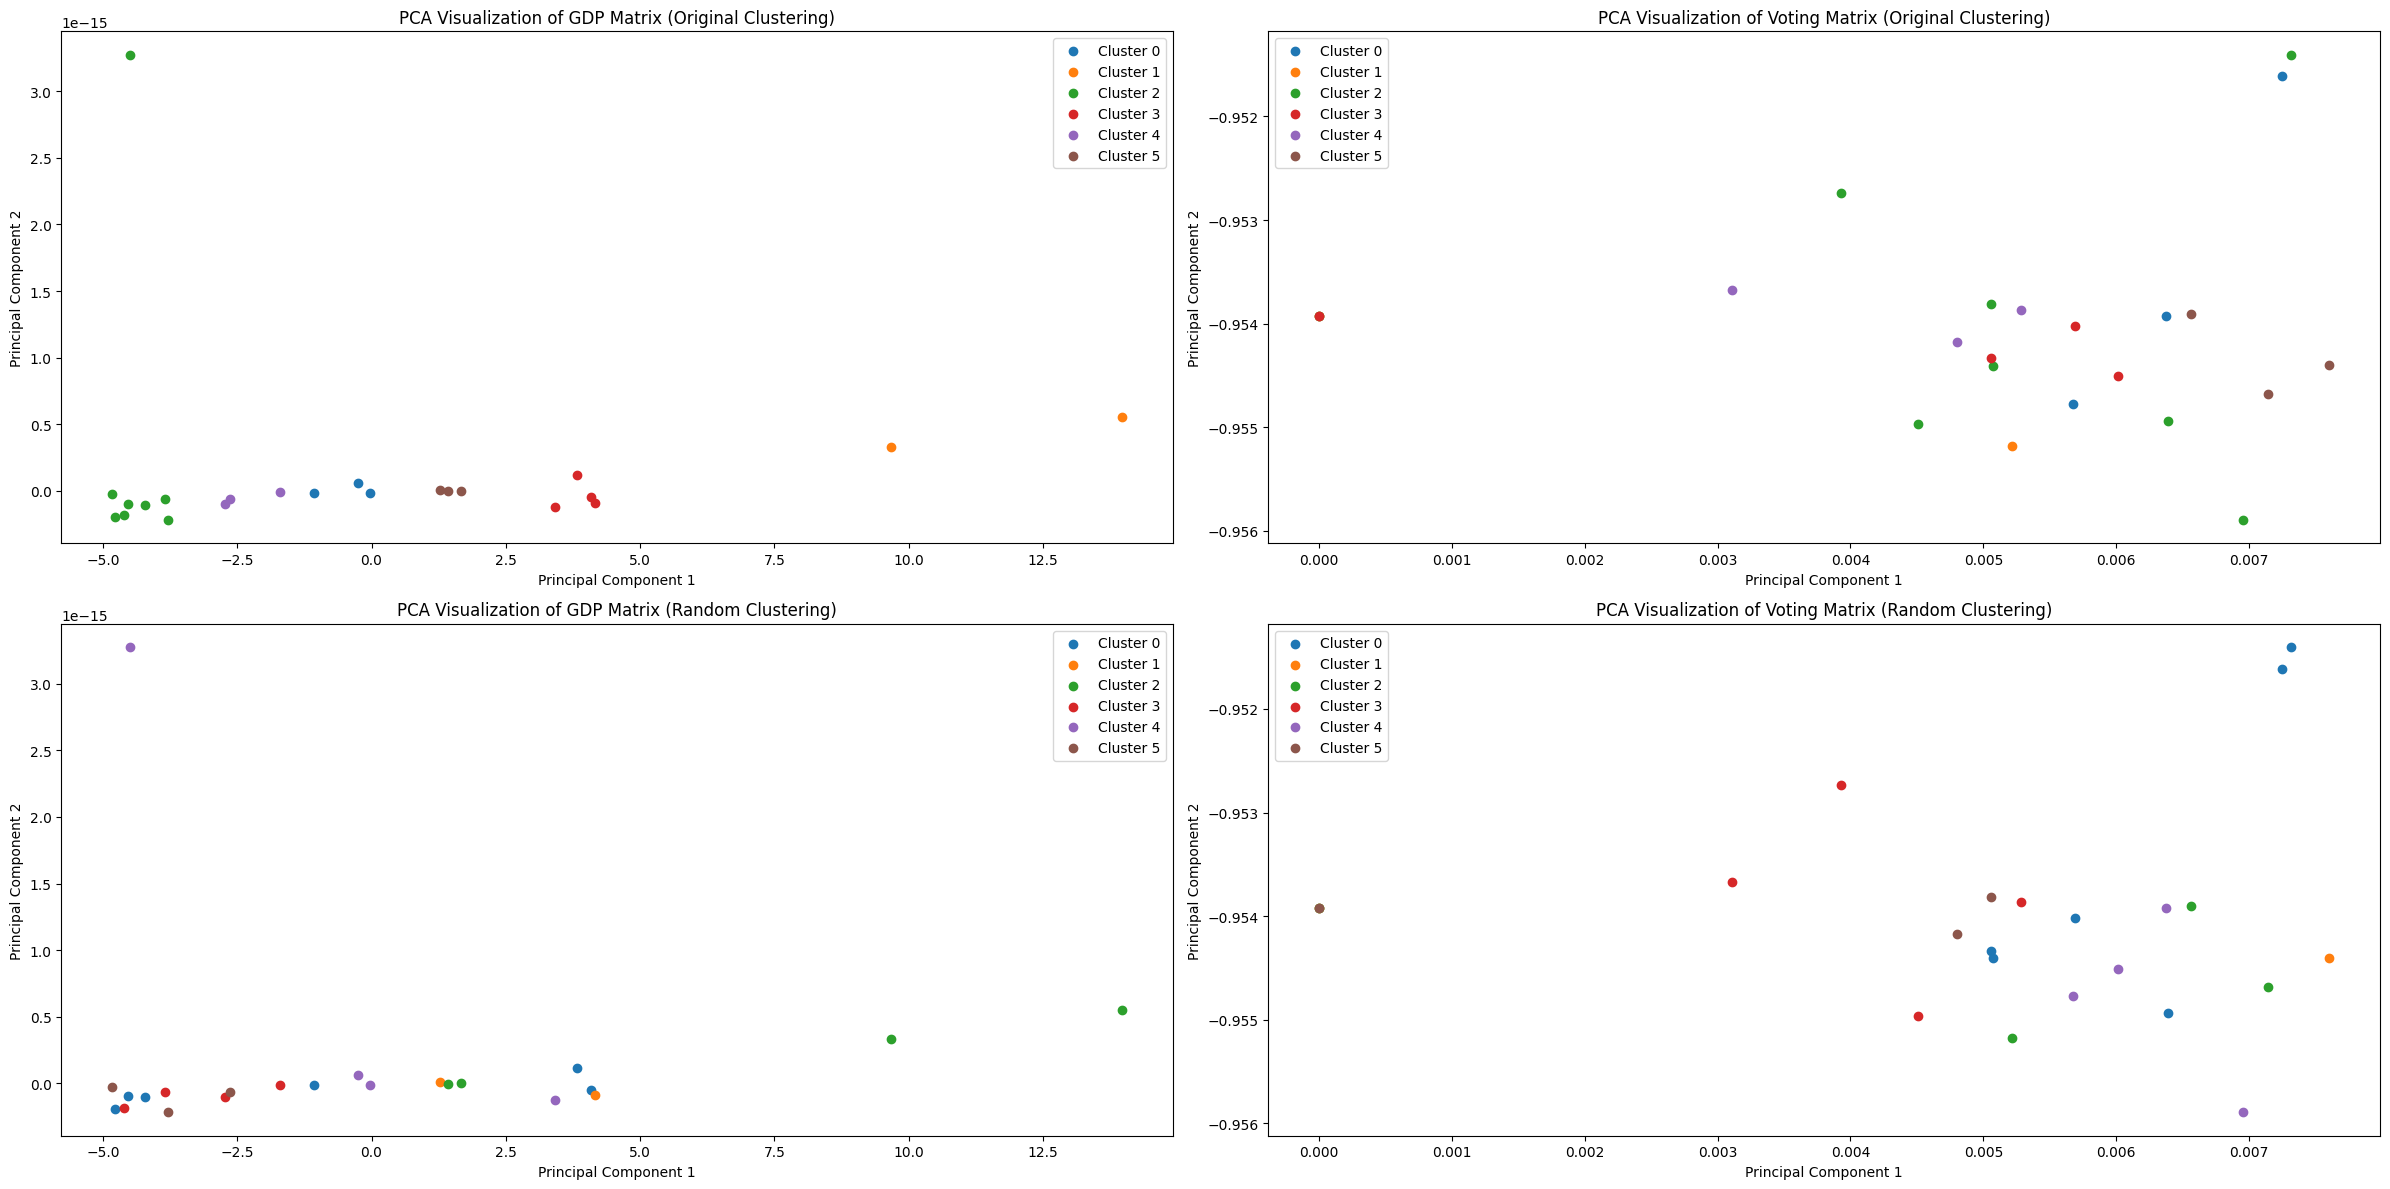

The silhouette score for GDP Matrix (Original) is: 0.6891396740098831
The silhouette score for Voting Matrix (Original) is: -0.14012225990889934
The silhouette score for GDP Matrix (Random) is: -0.3667505023099774
The silhouette score for Voting Matrix (Random) is: -0.11303502304530236


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


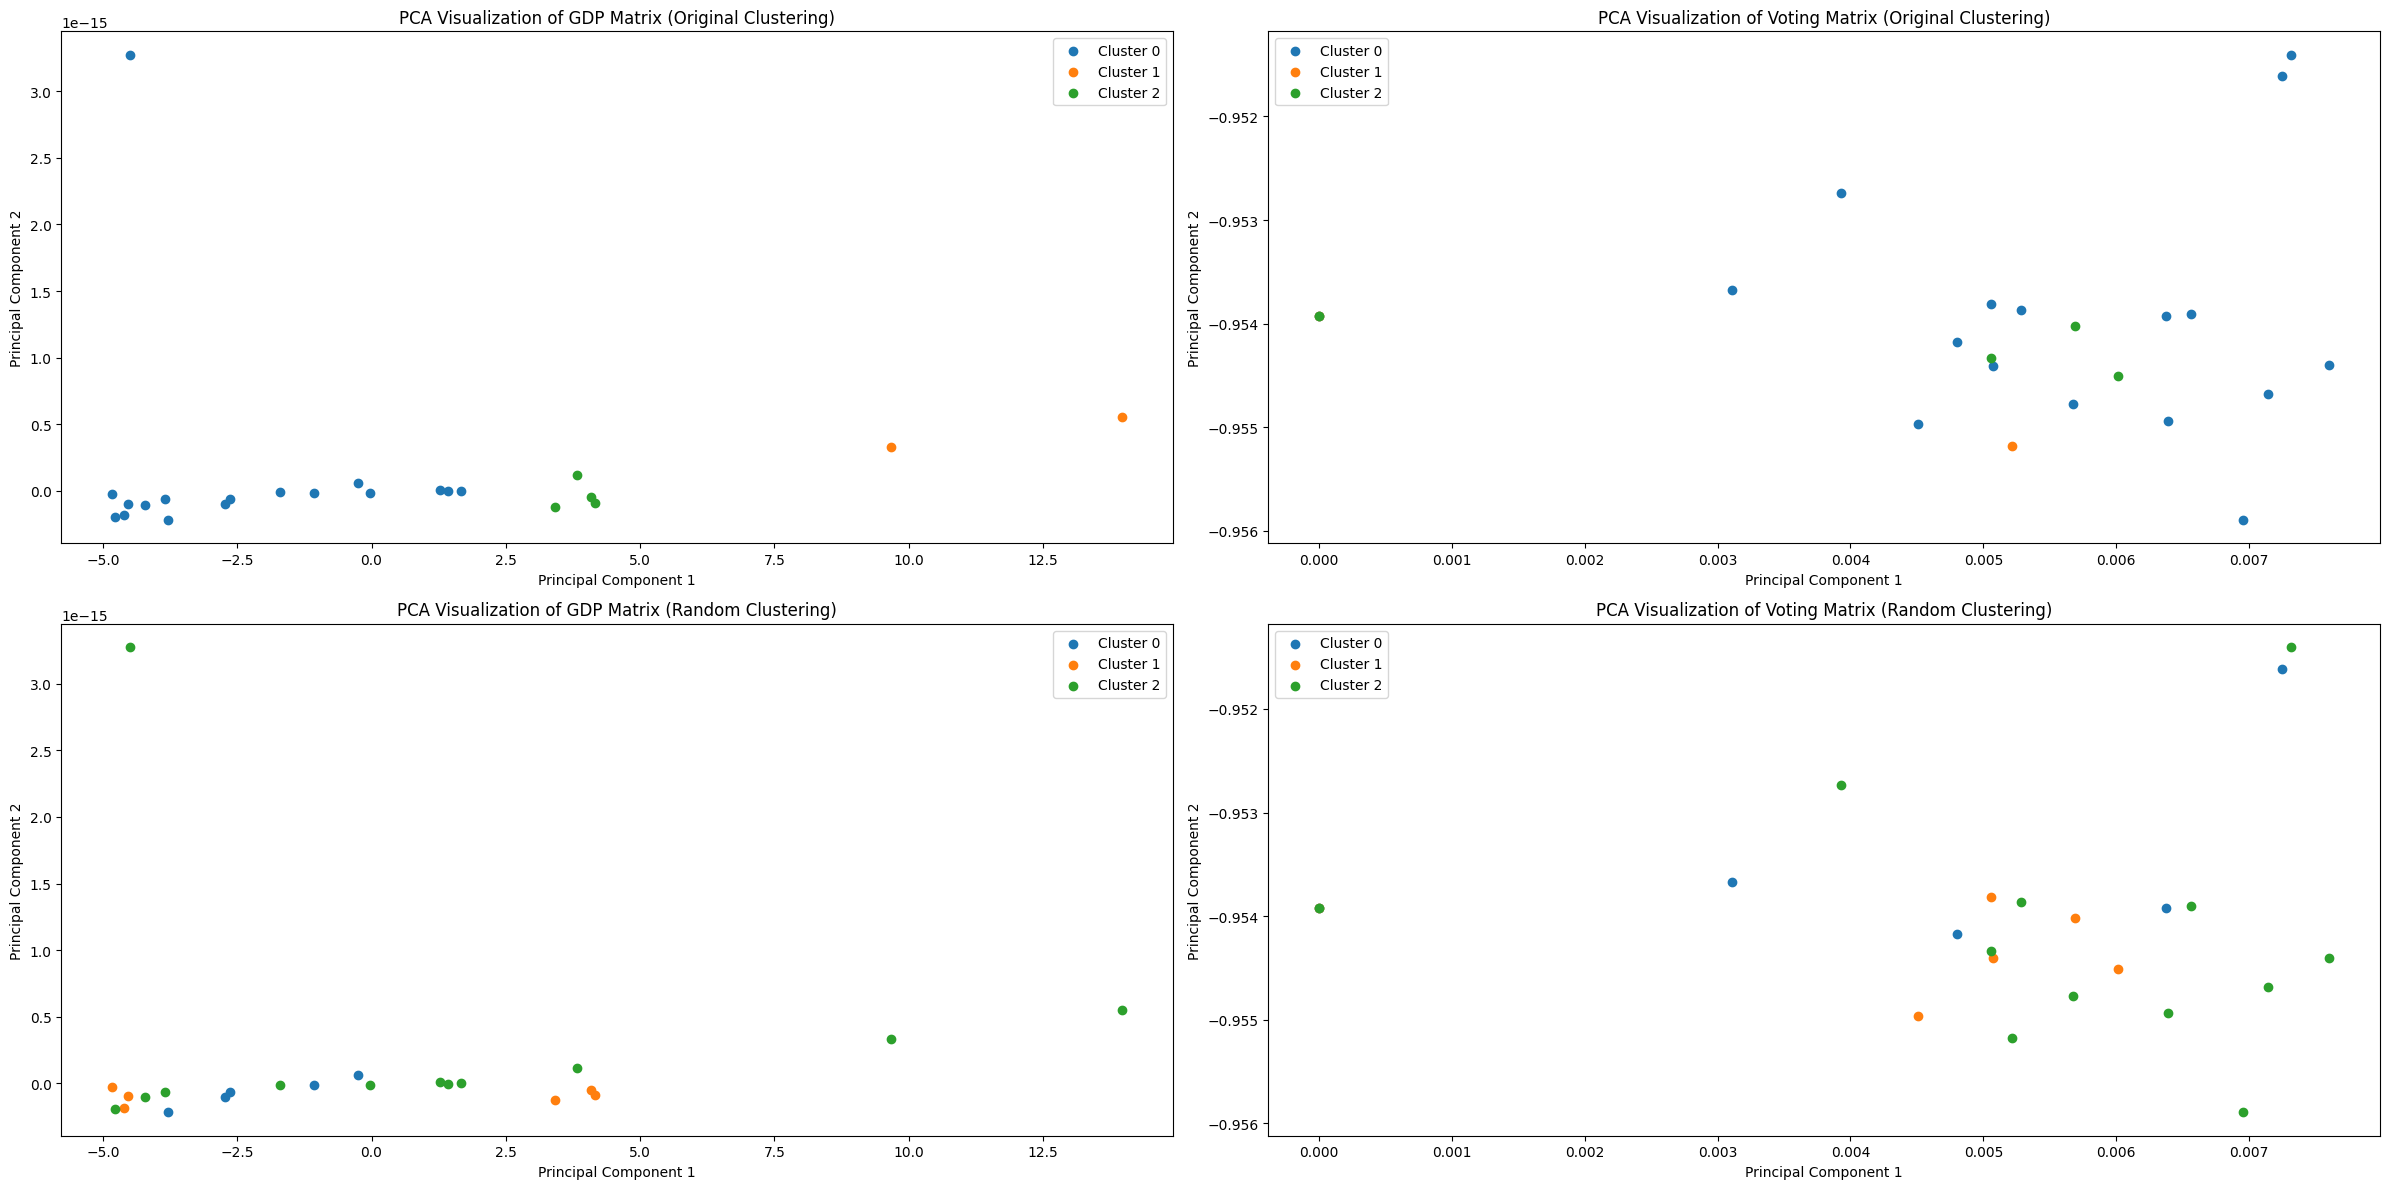

The silhouette score for GDP Matrix (Original) is: 0.5222077361464501
The silhouette score for Voting Matrix (Original) is: -0.11733613206618962
The silhouette score for GDP Matrix (Random) is: -0.14219354737190293
The silhouette score for Voting Matrix (Random) is: -0.05017475482478699


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


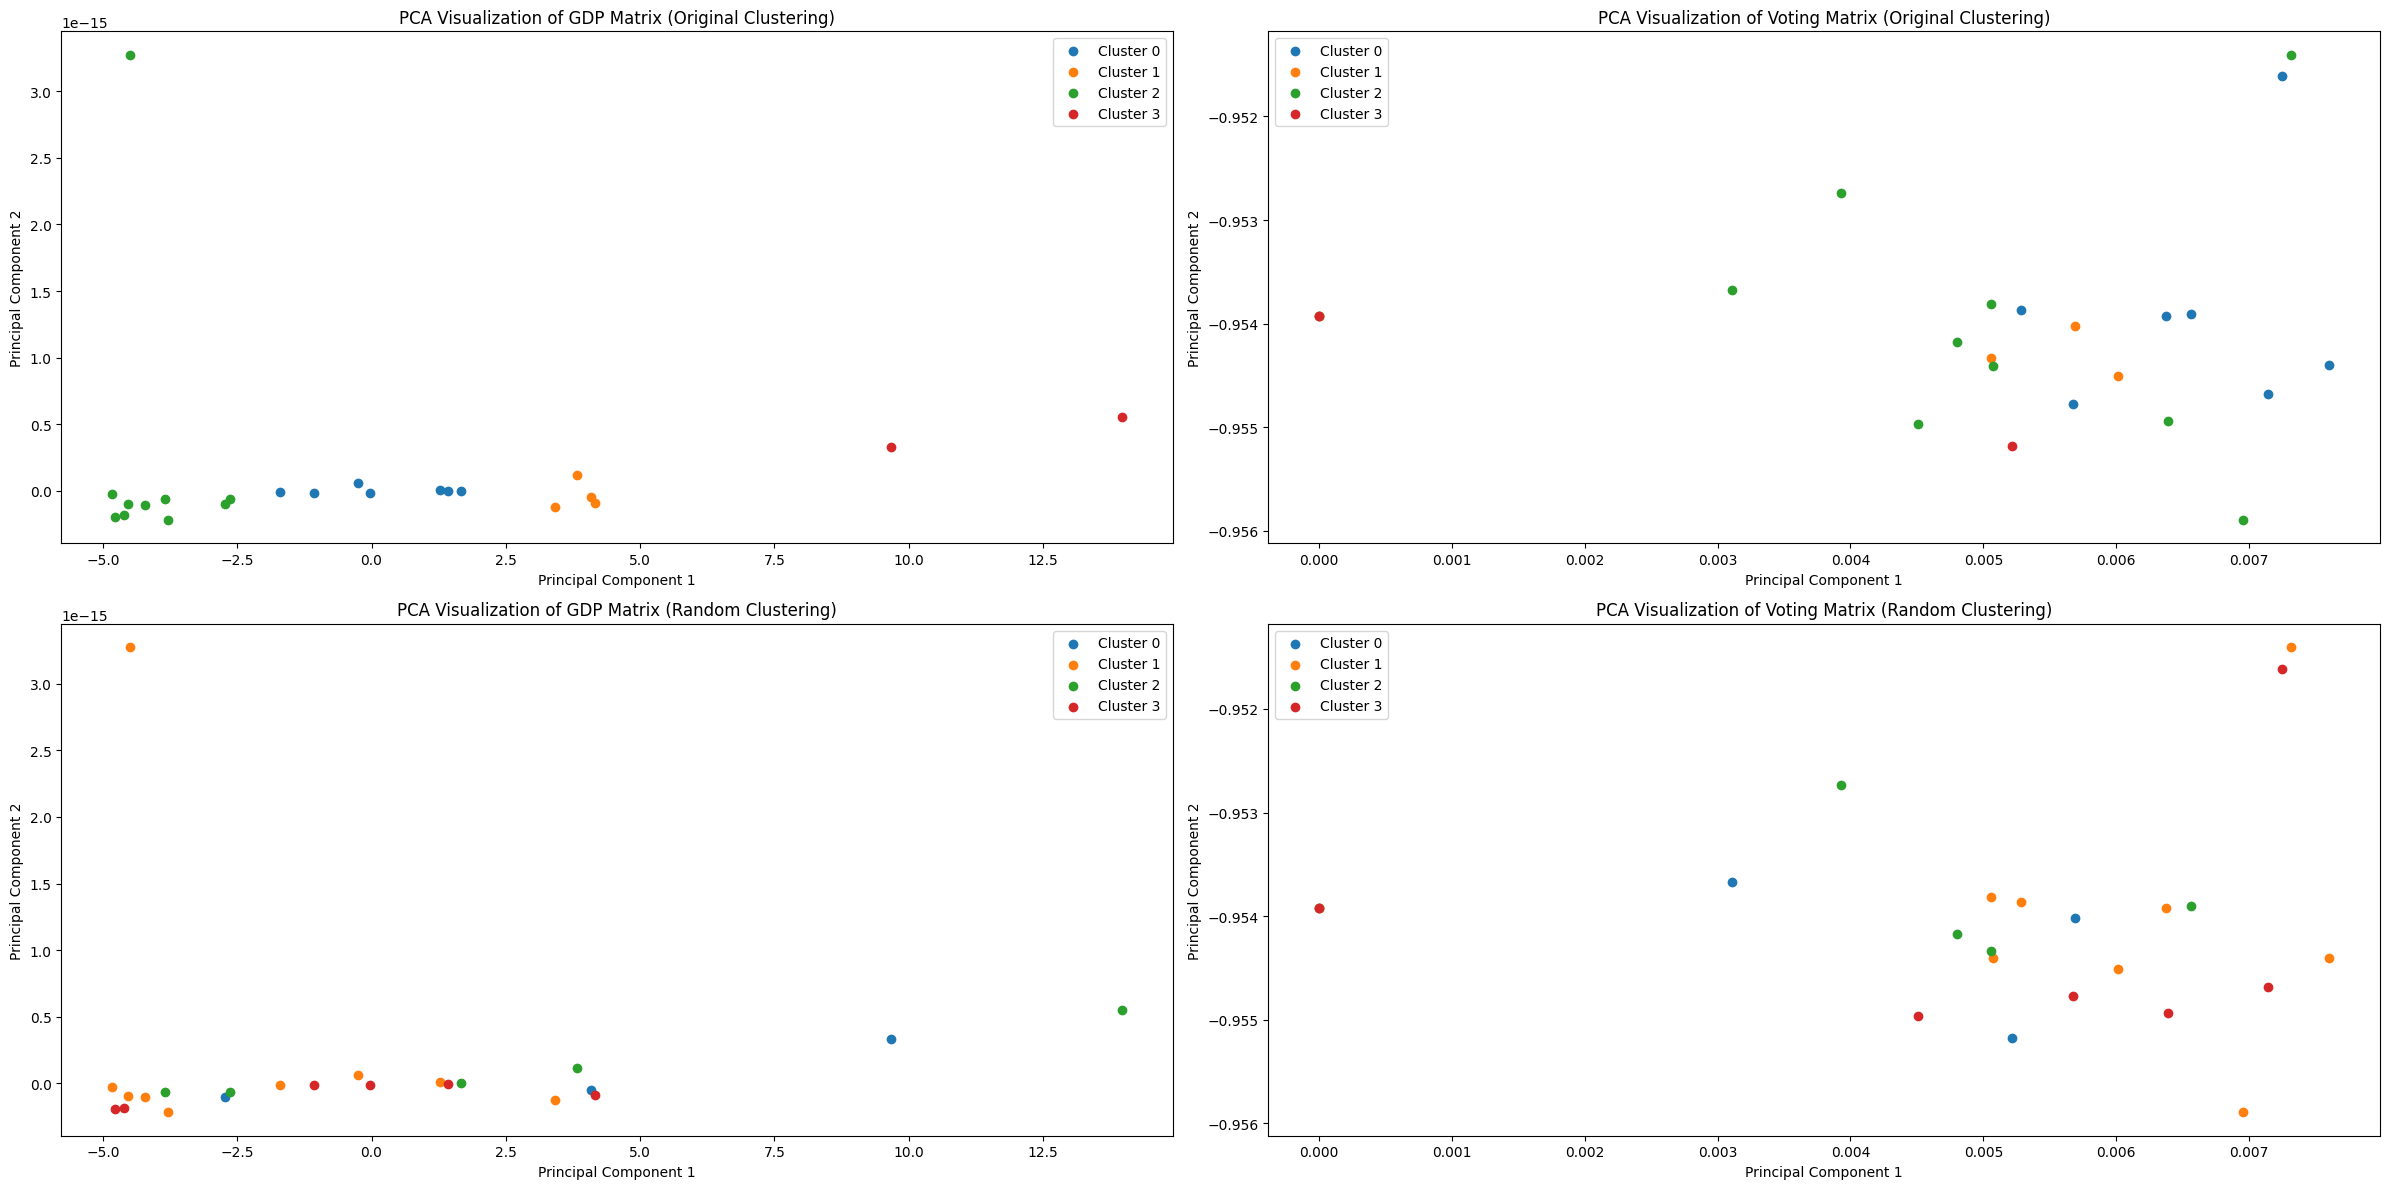

The silhouette score for GDP Matrix (Original) is: 0.6463152669399786
The silhouette score for Voting Matrix (Original) is: -0.12800303797653798
The silhouette score for GDP Matrix (Random) is: -0.18196477202513836
The silhouette score for Voting Matrix (Random) is: -0.10845841233019062


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


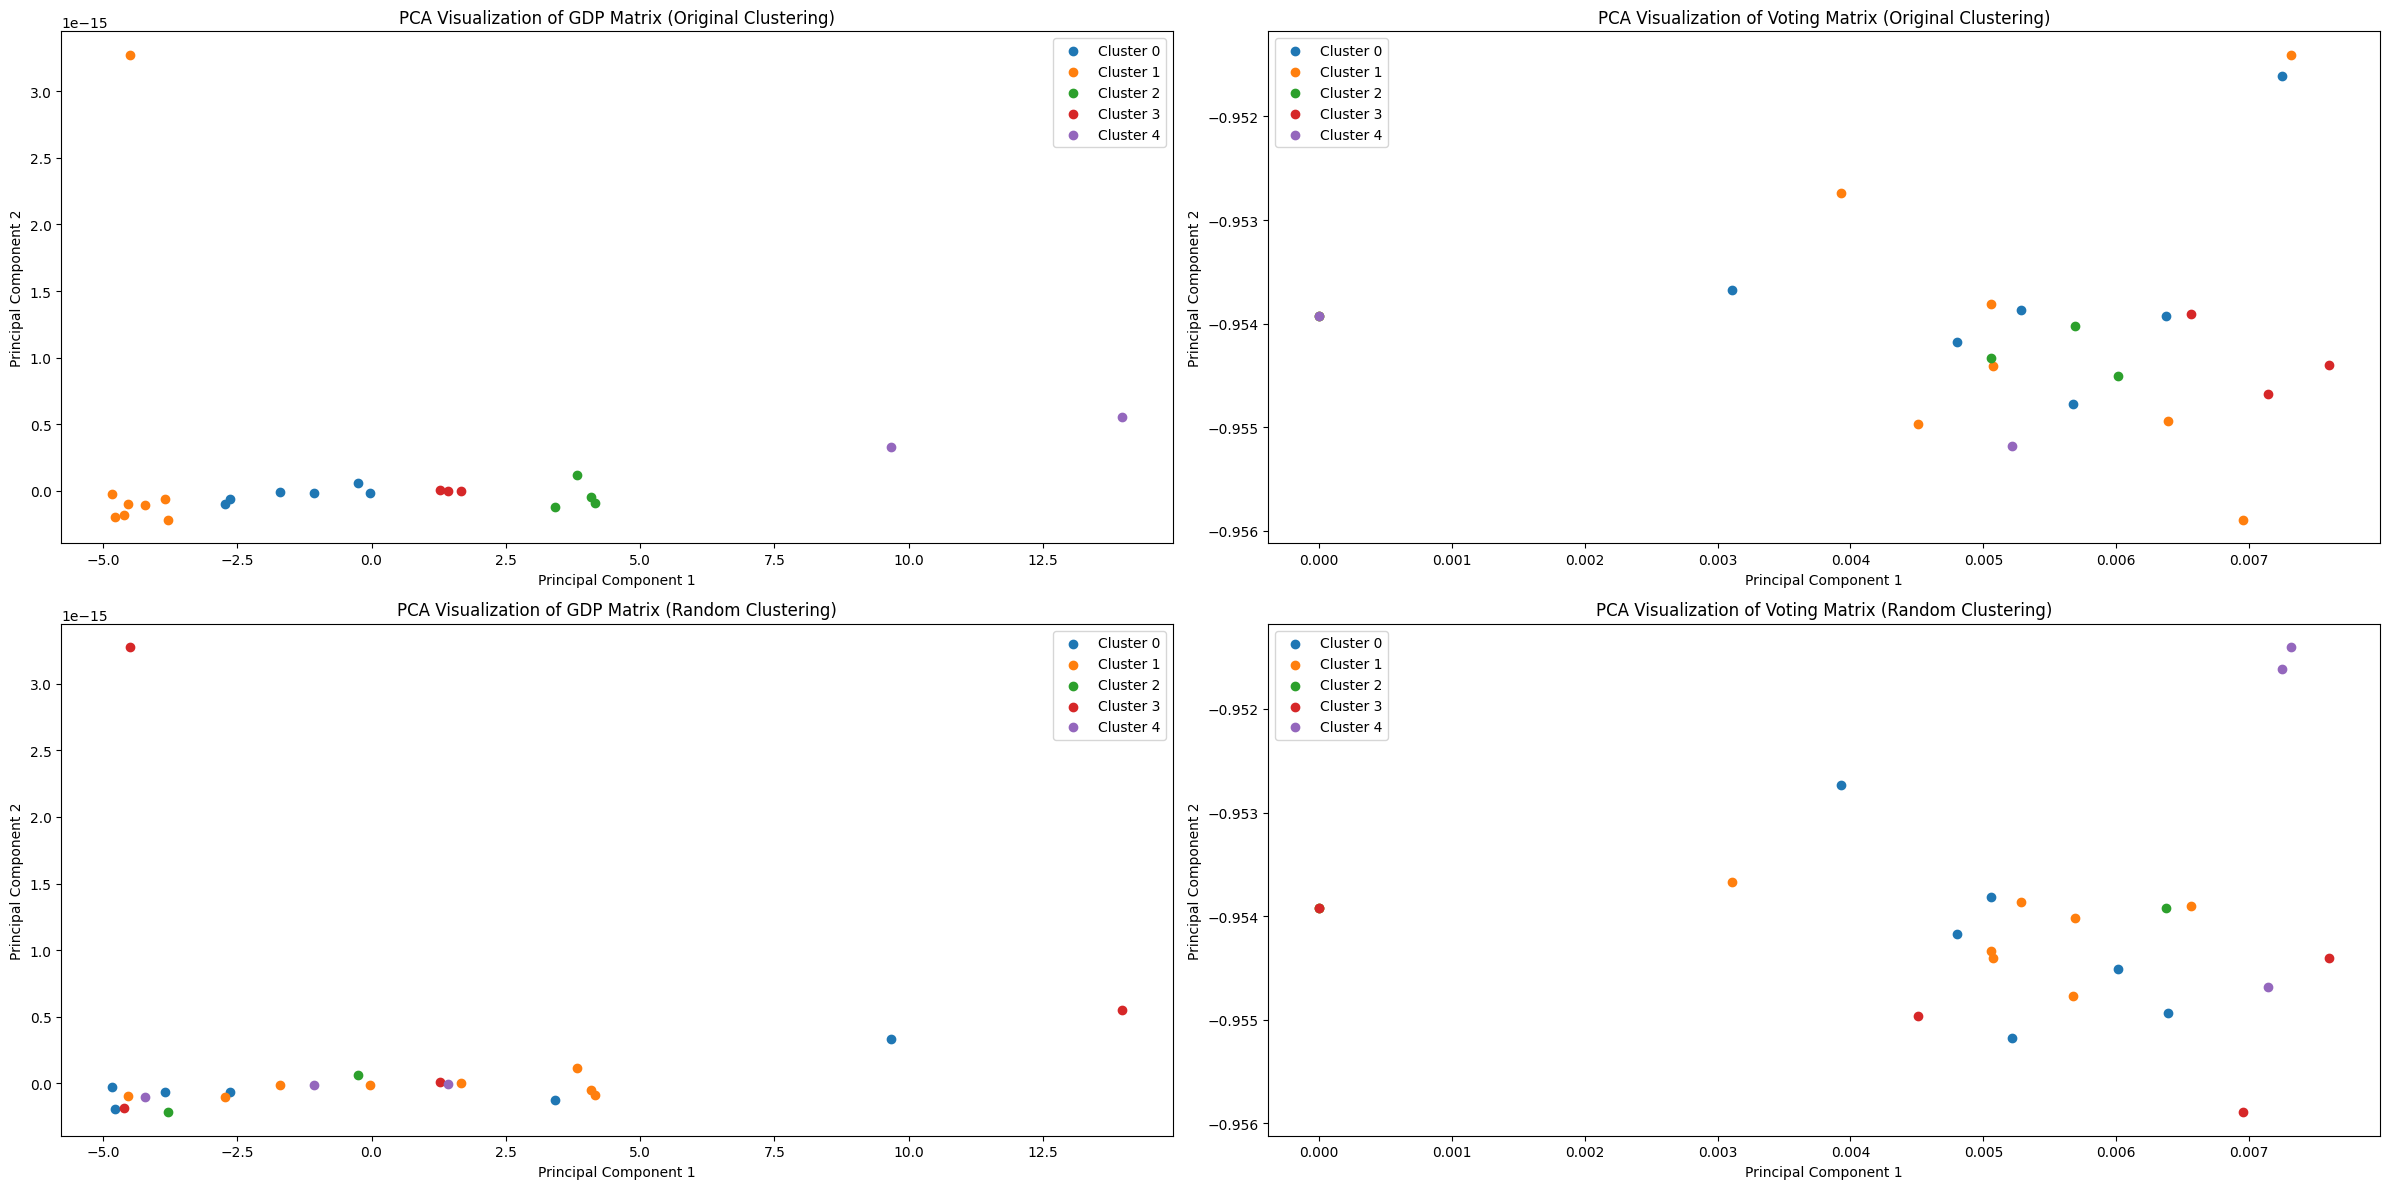

The silhouette score for GDP Matrix (Original) is: 0.643908088718305
The silhouette score for Voting Matrix (Original) is: -0.128784030664255
The silhouette score for GDP Matrix (Random) is: -0.36590869082266325
The silhouette score for Voting Matrix (Random) is: -0.13420221683333827


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


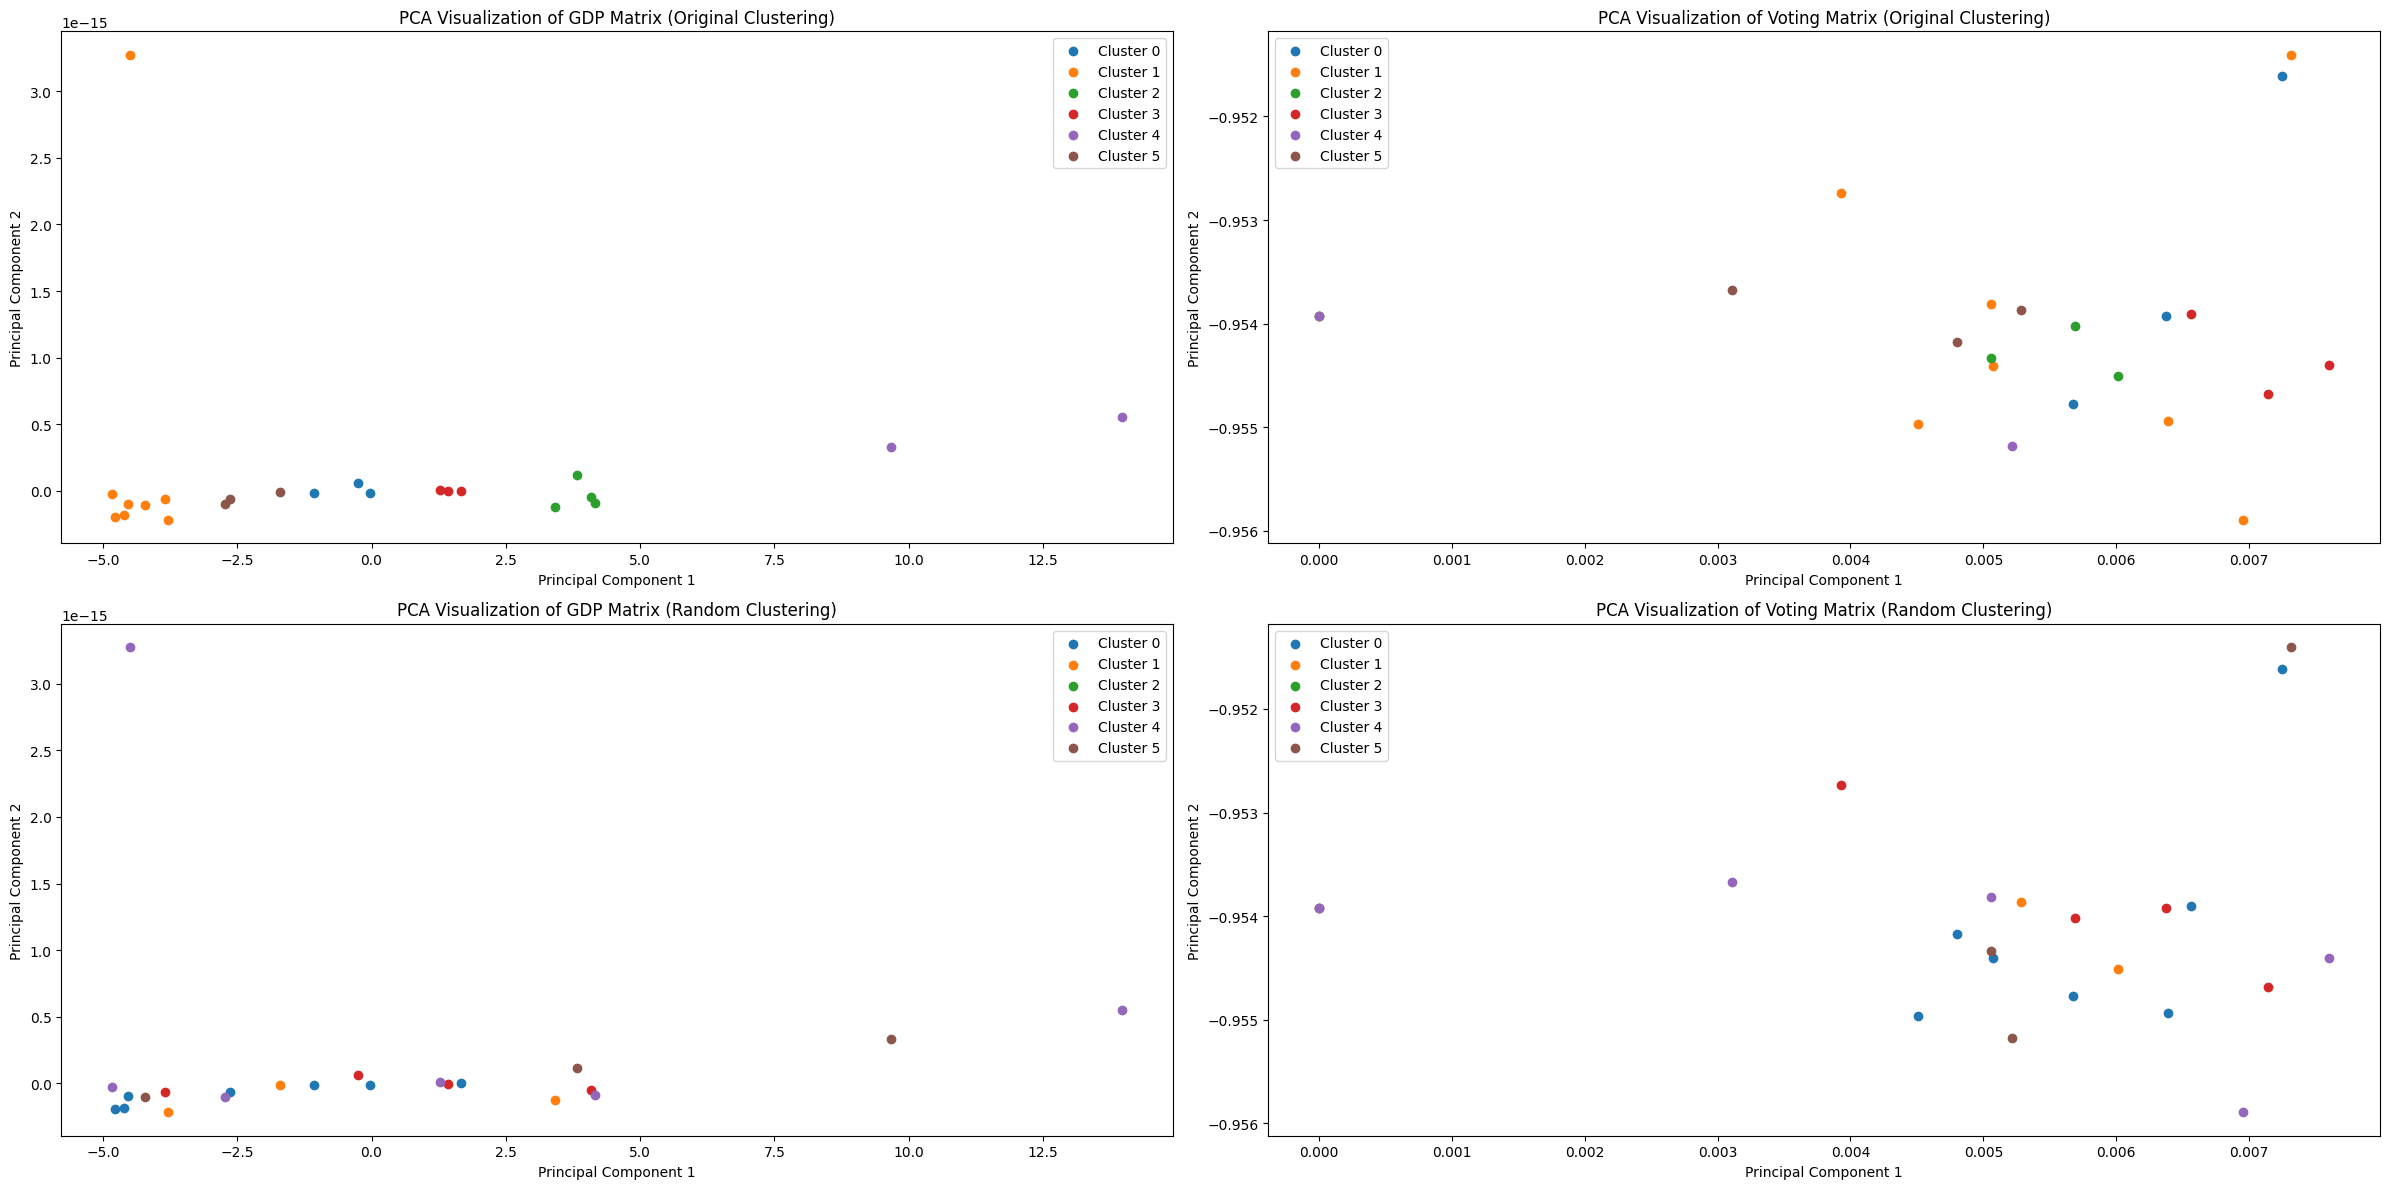

The silhouette score for GDP Matrix (Original) is: 0.6891396740098831
The silhouette score for Voting Matrix (Original) is: -0.14012225990889934
The silhouette score for GDP Matrix (Random) is: -0.2853925648311071
The silhouette score for Voting Matrix (Random) is: -0.12227668731566634


In [5]:
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 3, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 4, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 5, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 6, method='KMeans')

clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_jury, 6, method='SpectralClustering')

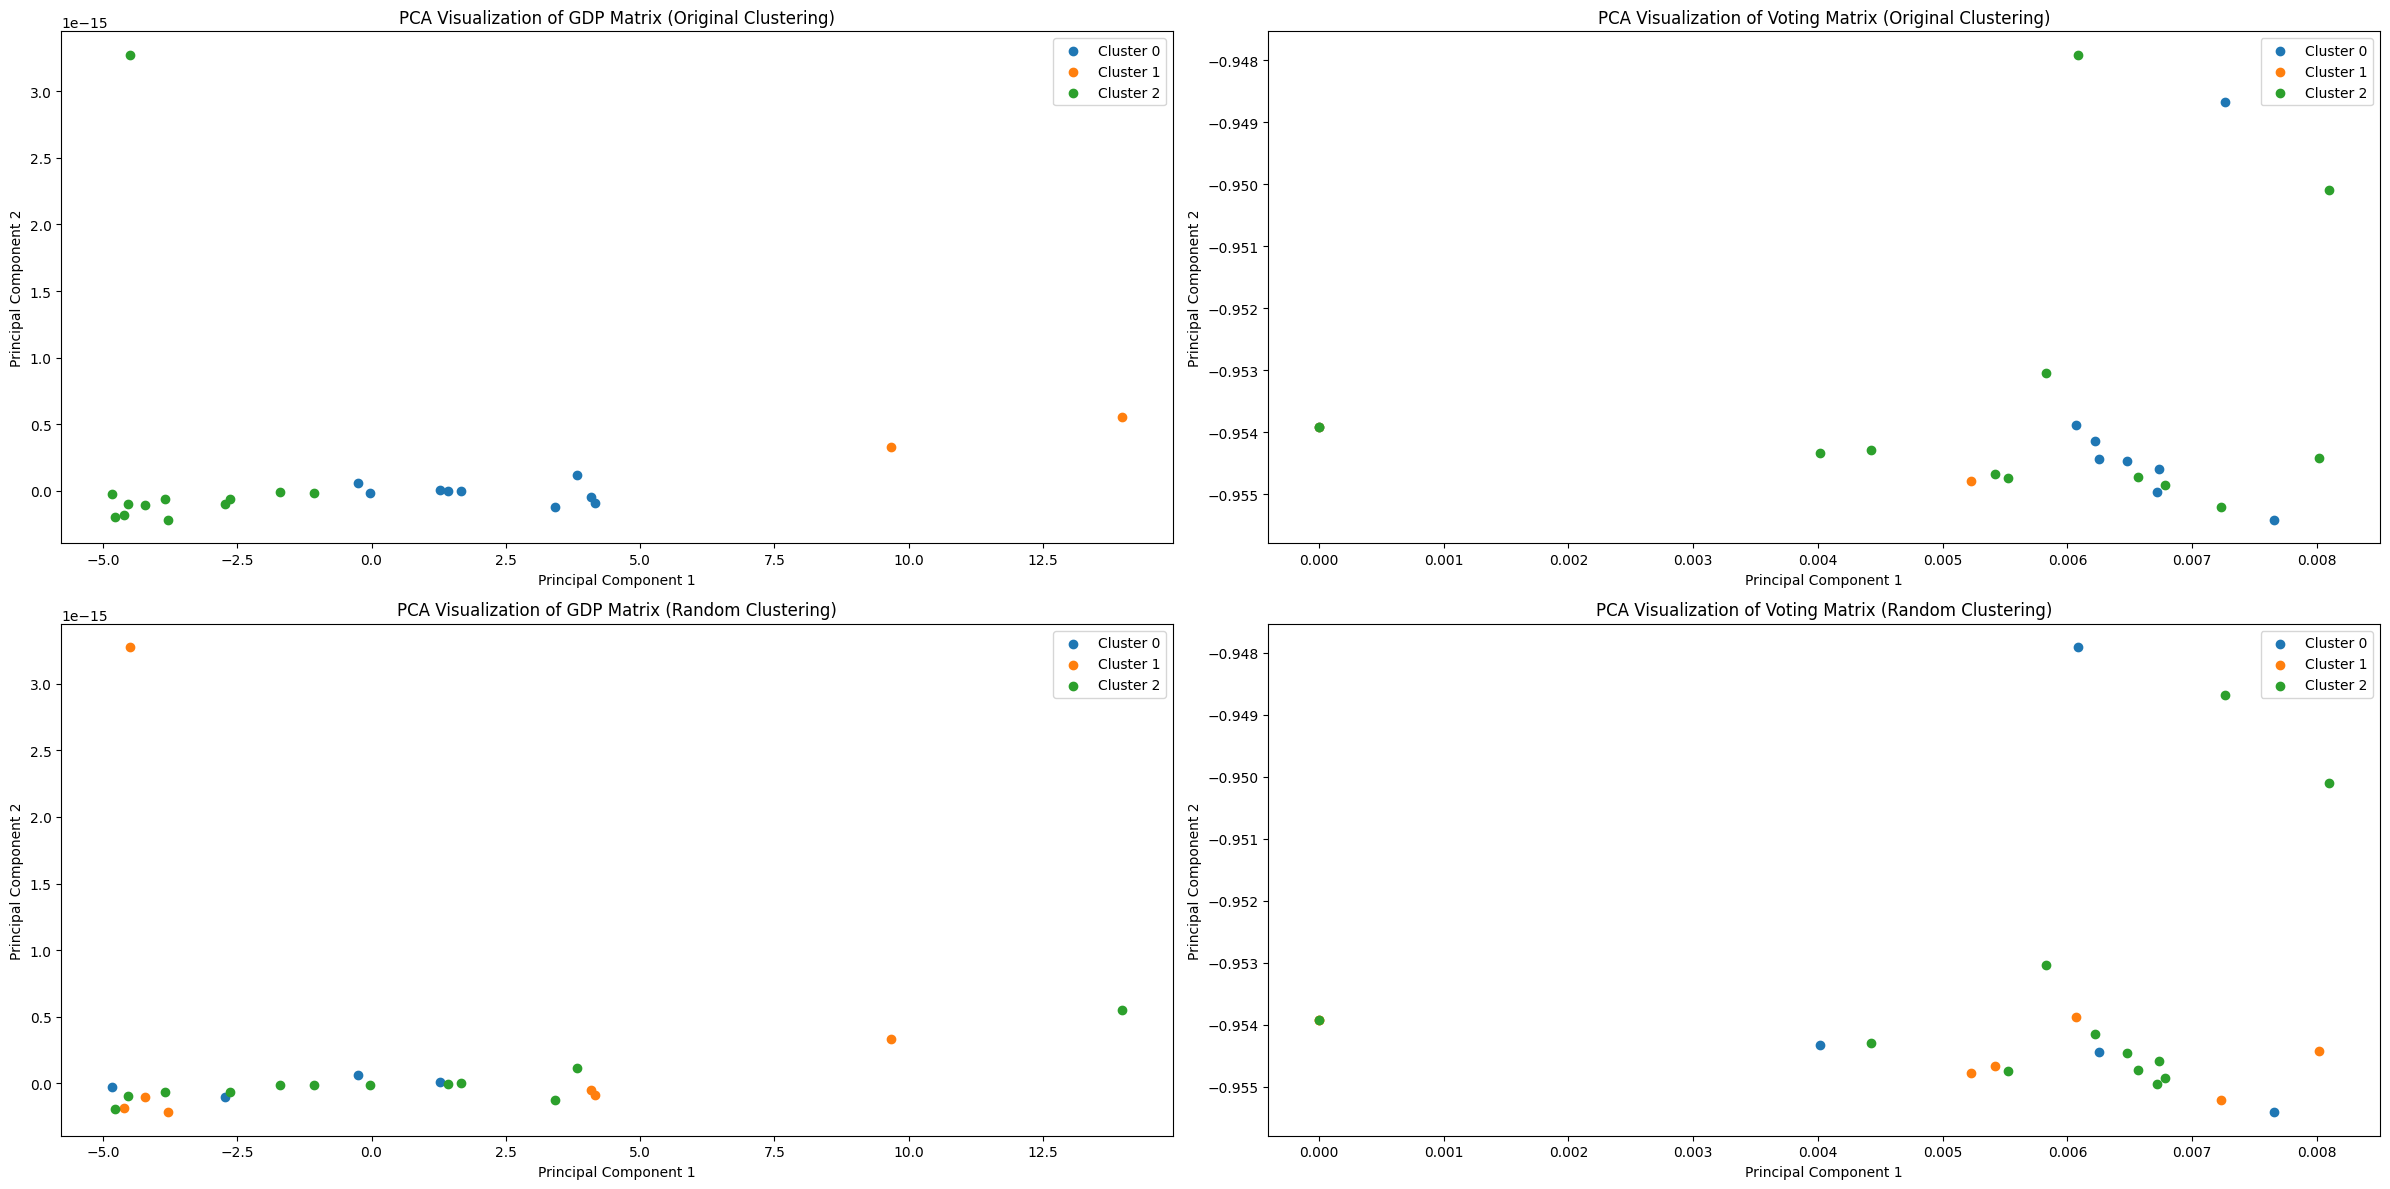

The silhouette score for GDP Matrix (Original) is: 0.6520224710194664
The silhouette score for Voting Matrix (Original) is: -0.10540746044095459
The silhouette score for GDP Matrix (Random) is: -0.23841343932106057
The silhouette score for Voting Matrix (Random) is: -0.03476021162359654


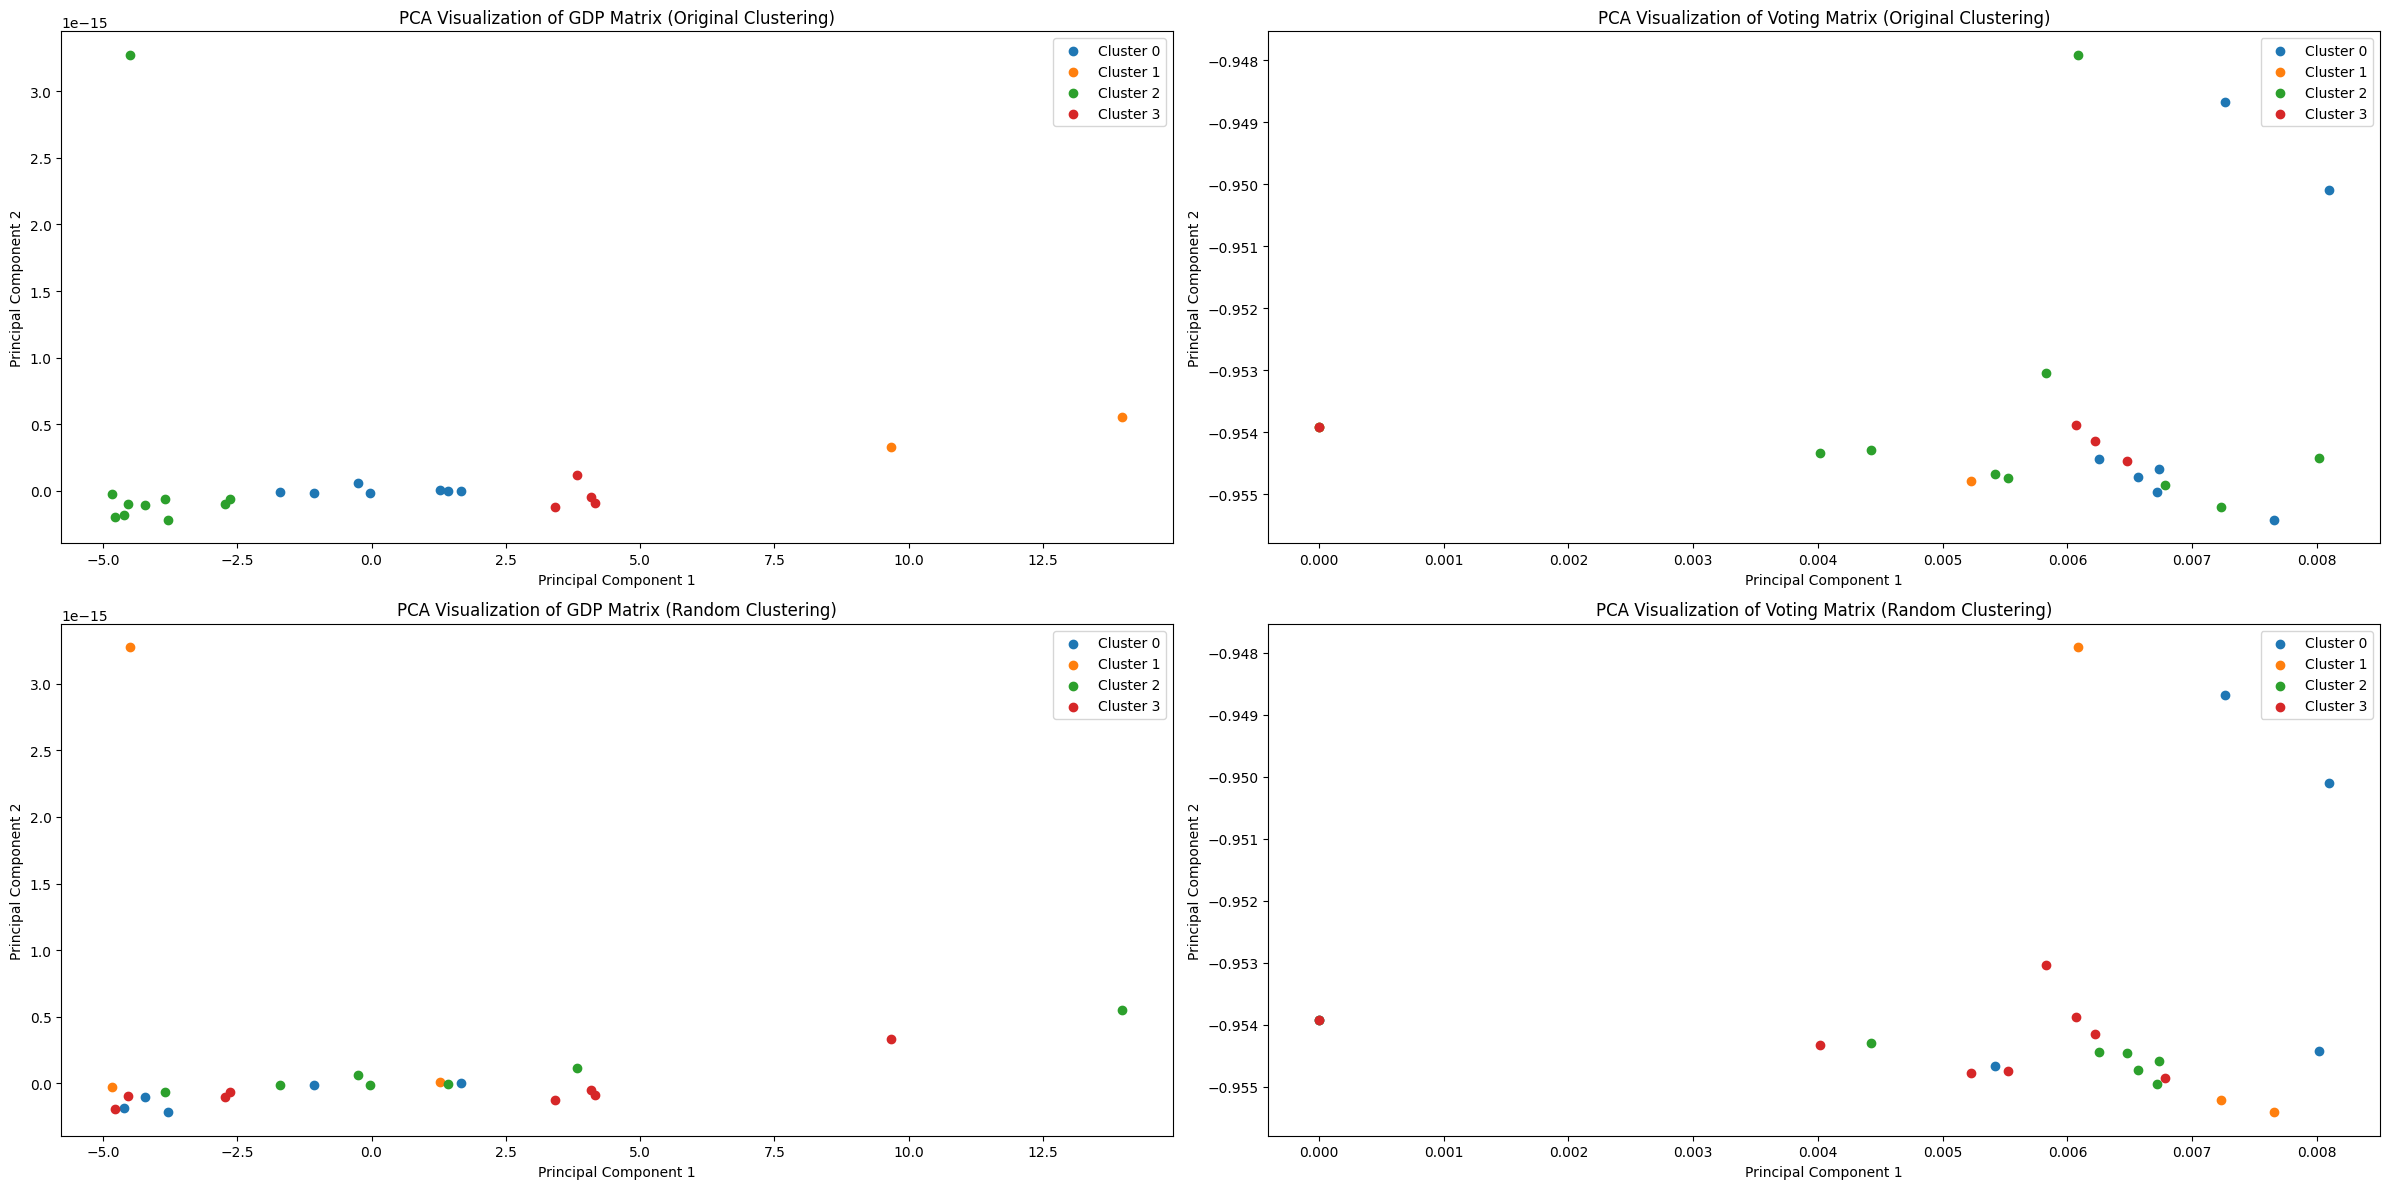

The silhouette score for GDP Matrix (Original) is: 0.6463152669399786
The silhouette score for Voting Matrix (Original) is: -0.11894643528789882
The silhouette score for GDP Matrix (Random) is: -0.28491800535252115
The silhouette score for Voting Matrix (Random) is: -0.06418265624898745


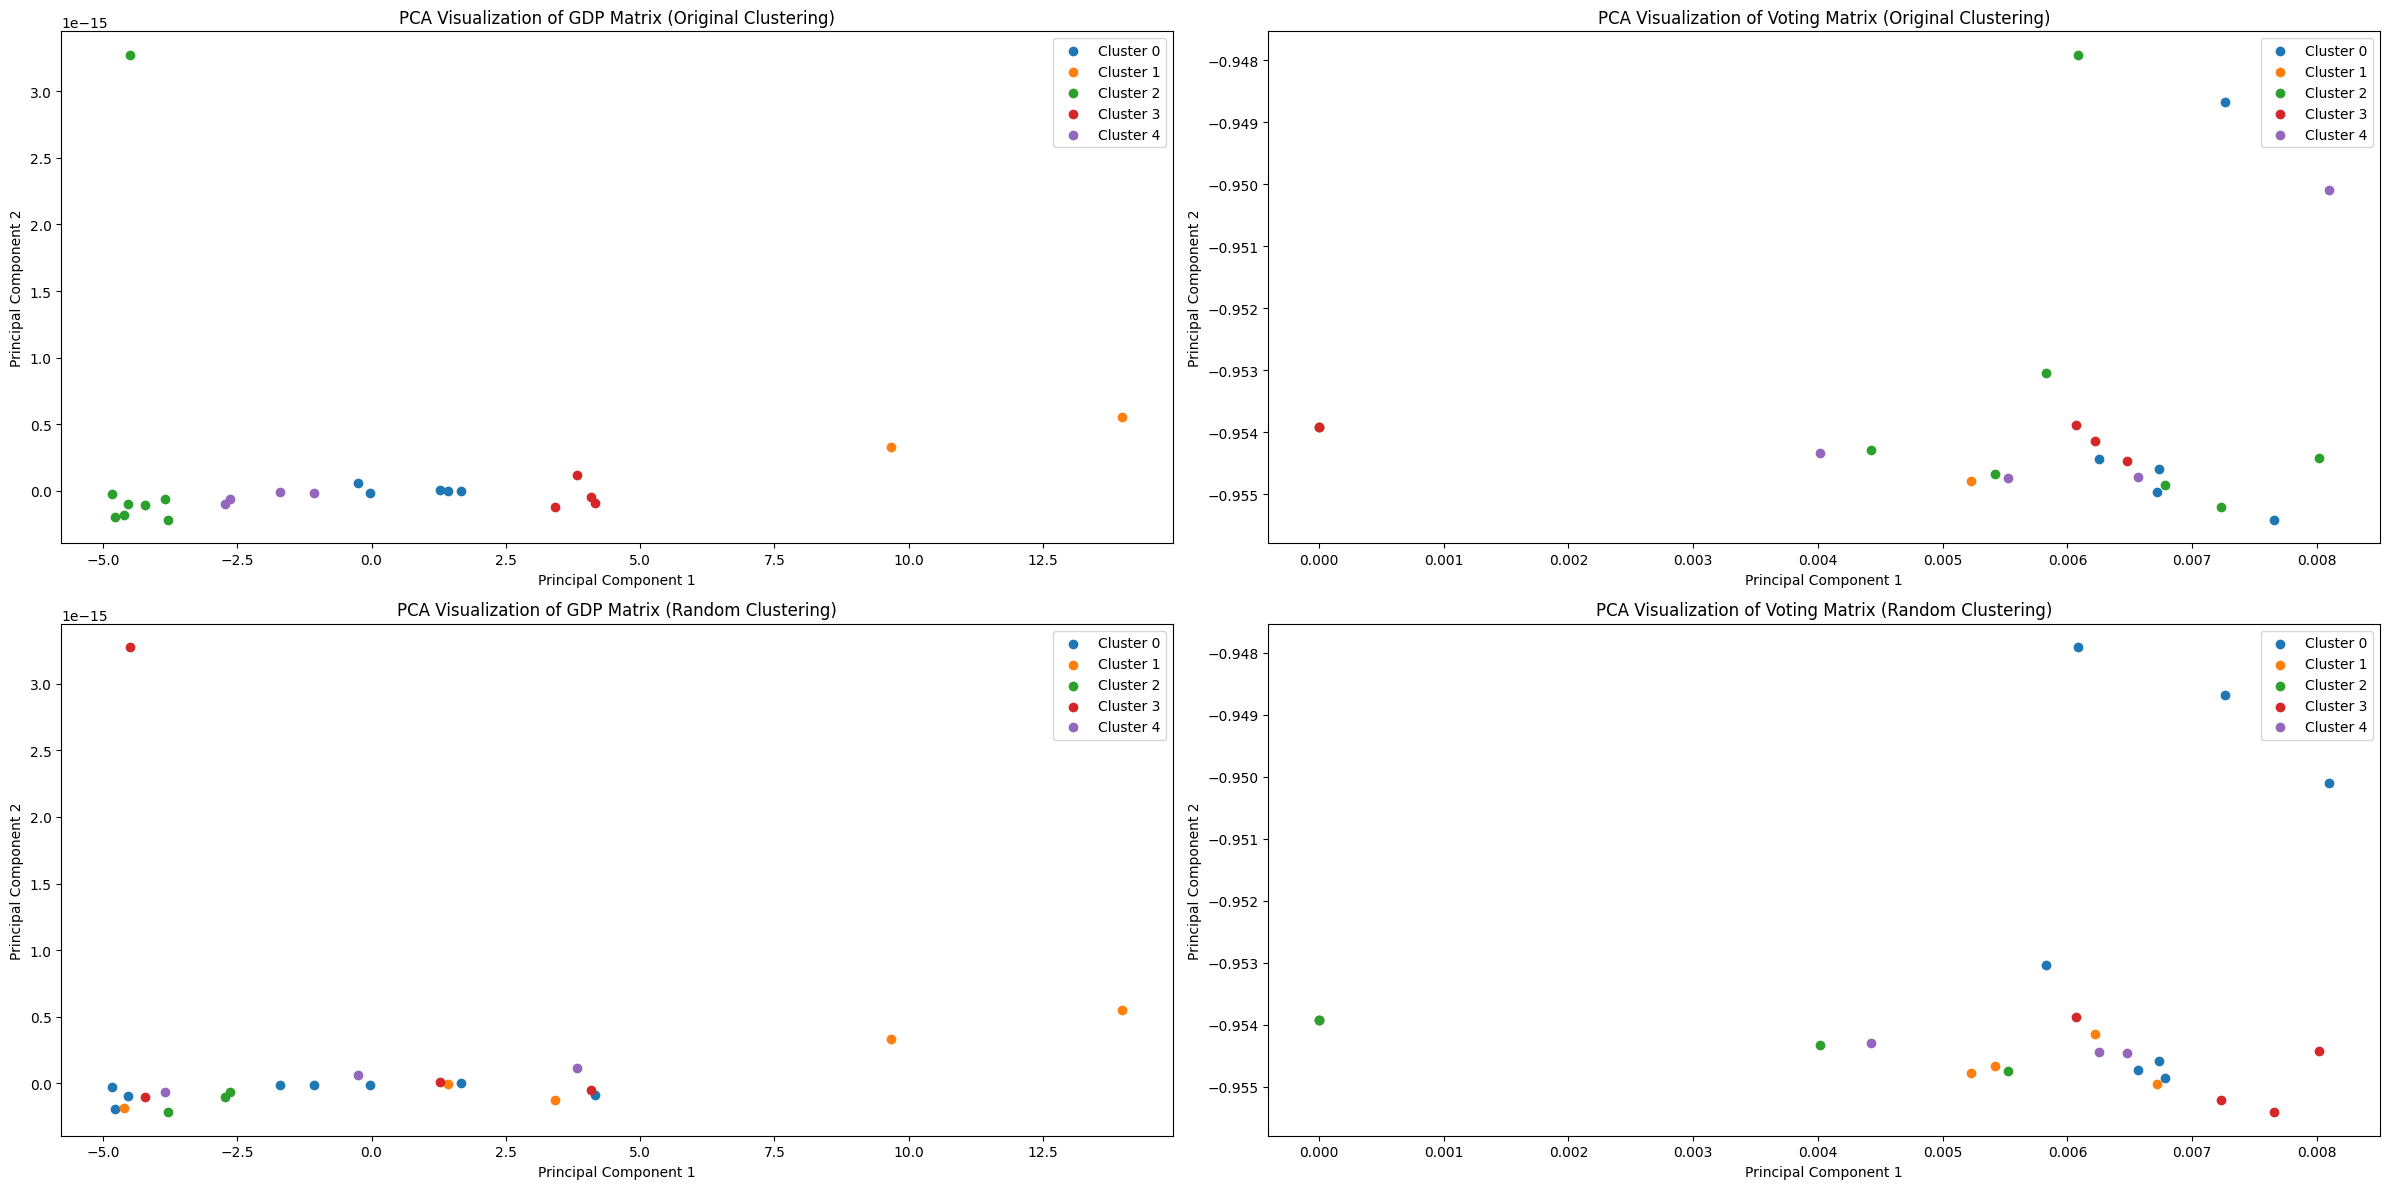

The silhouette score for GDP Matrix (Original) is: 0.6525969651852452
The silhouette score for Voting Matrix (Original) is: -0.13794234631471325
The silhouette score for GDP Matrix (Random) is: -0.26687020606276585
The silhouette score for Voting Matrix (Random) is: -0.09436578158892145


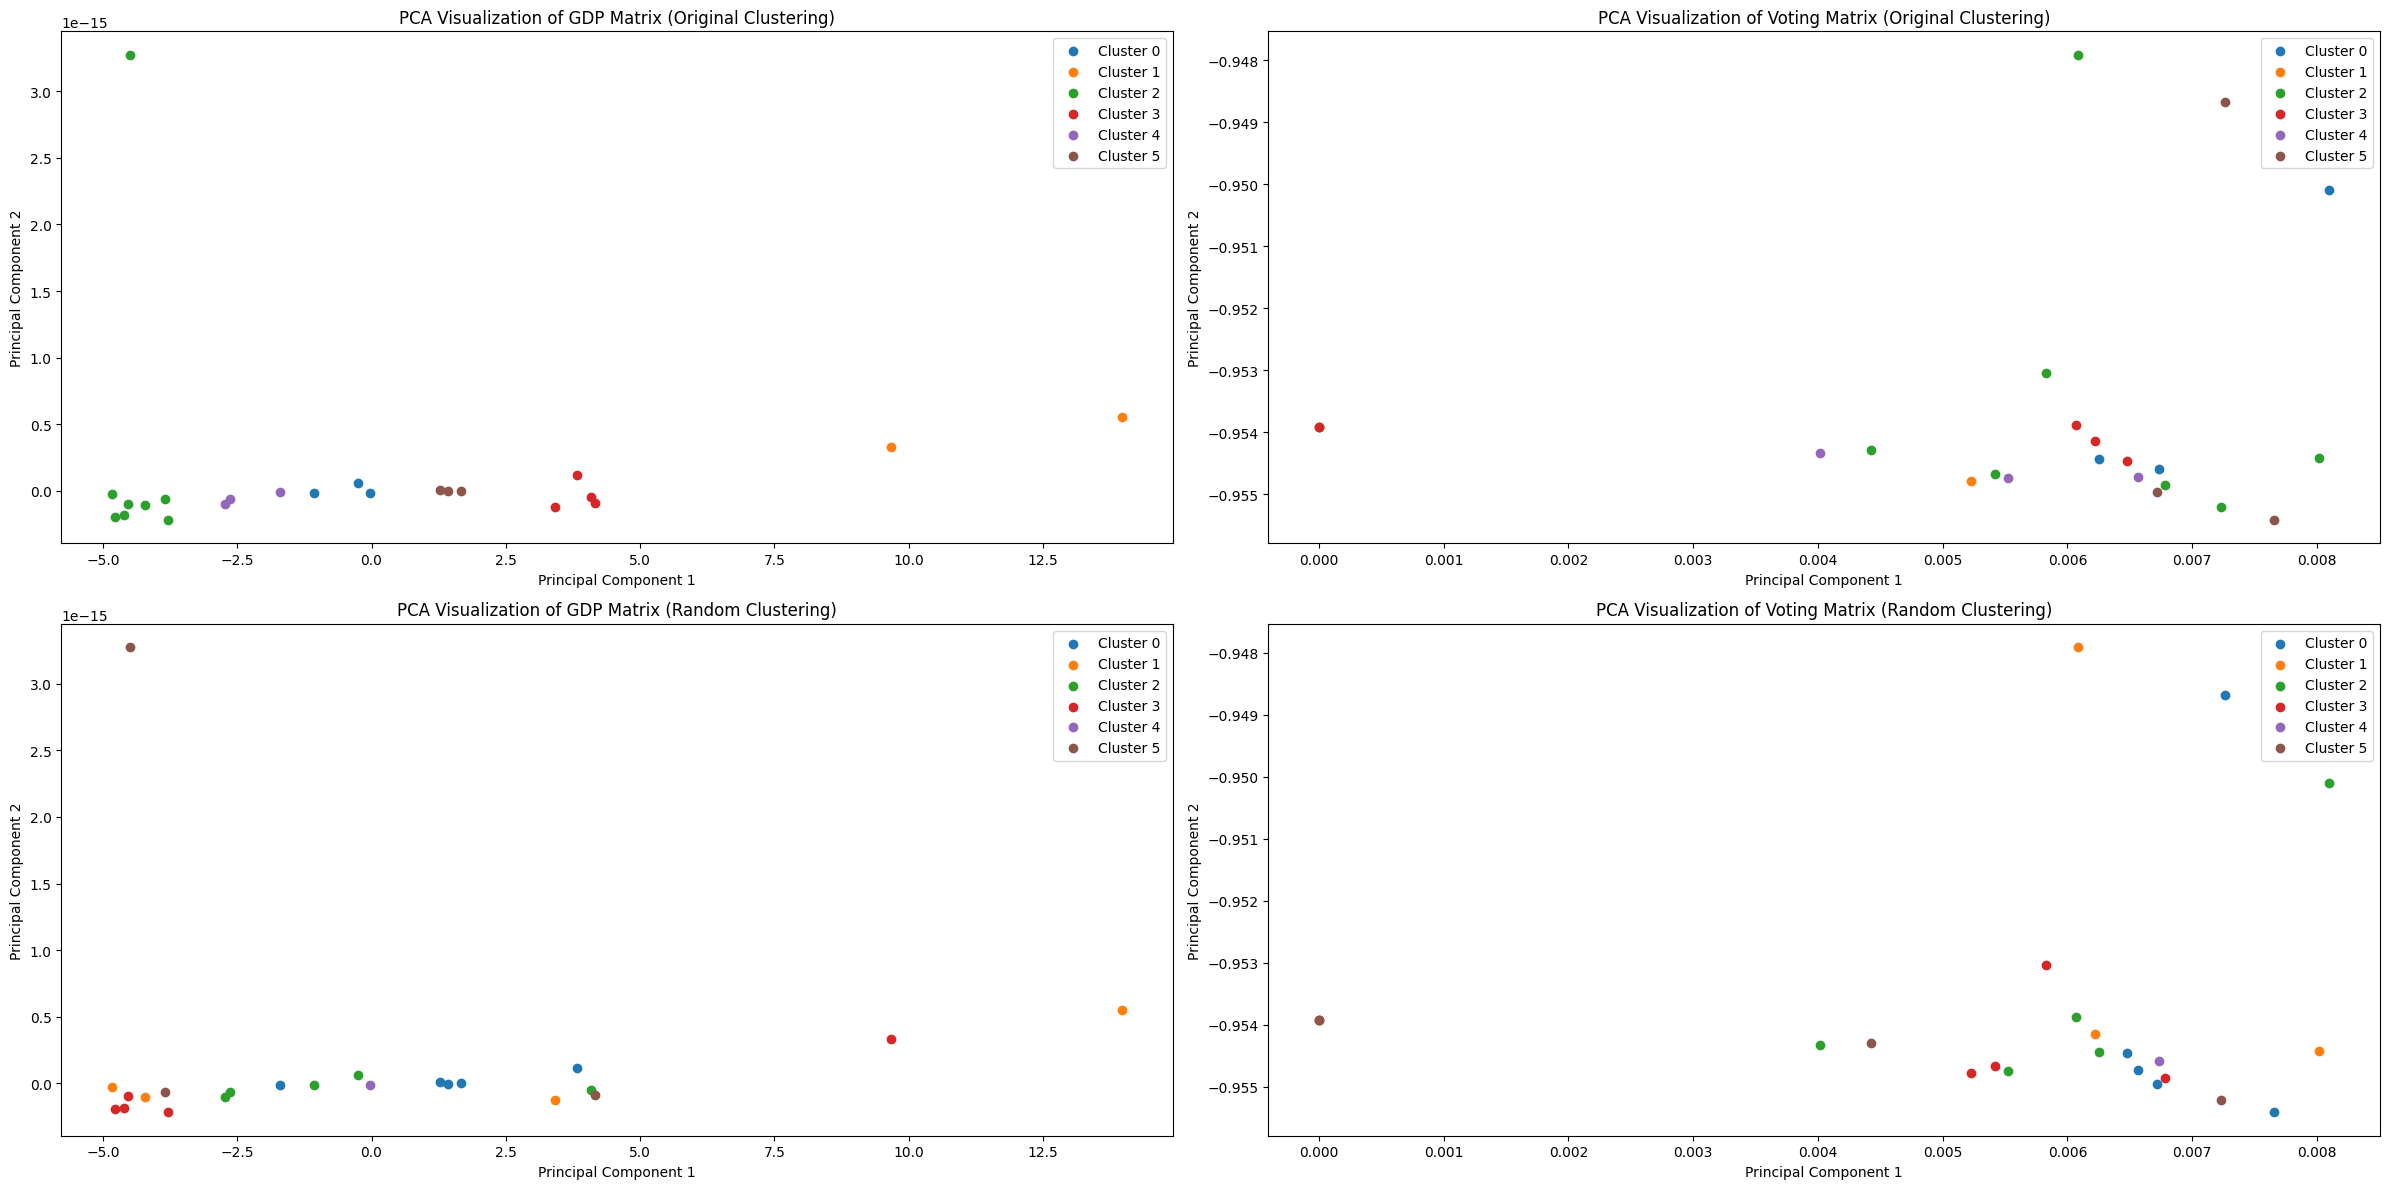

The silhouette score for GDP Matrix (Original) is: 0.6891396740098831
The silhouette score for Voting Matrix (Original) is: -0.1573150976835757
The silhouette score for GDP Matrix (Random) is: -0.31080940188018574
The silhouette score for Voting Matrix (Random) is: -0.11295063396895512


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


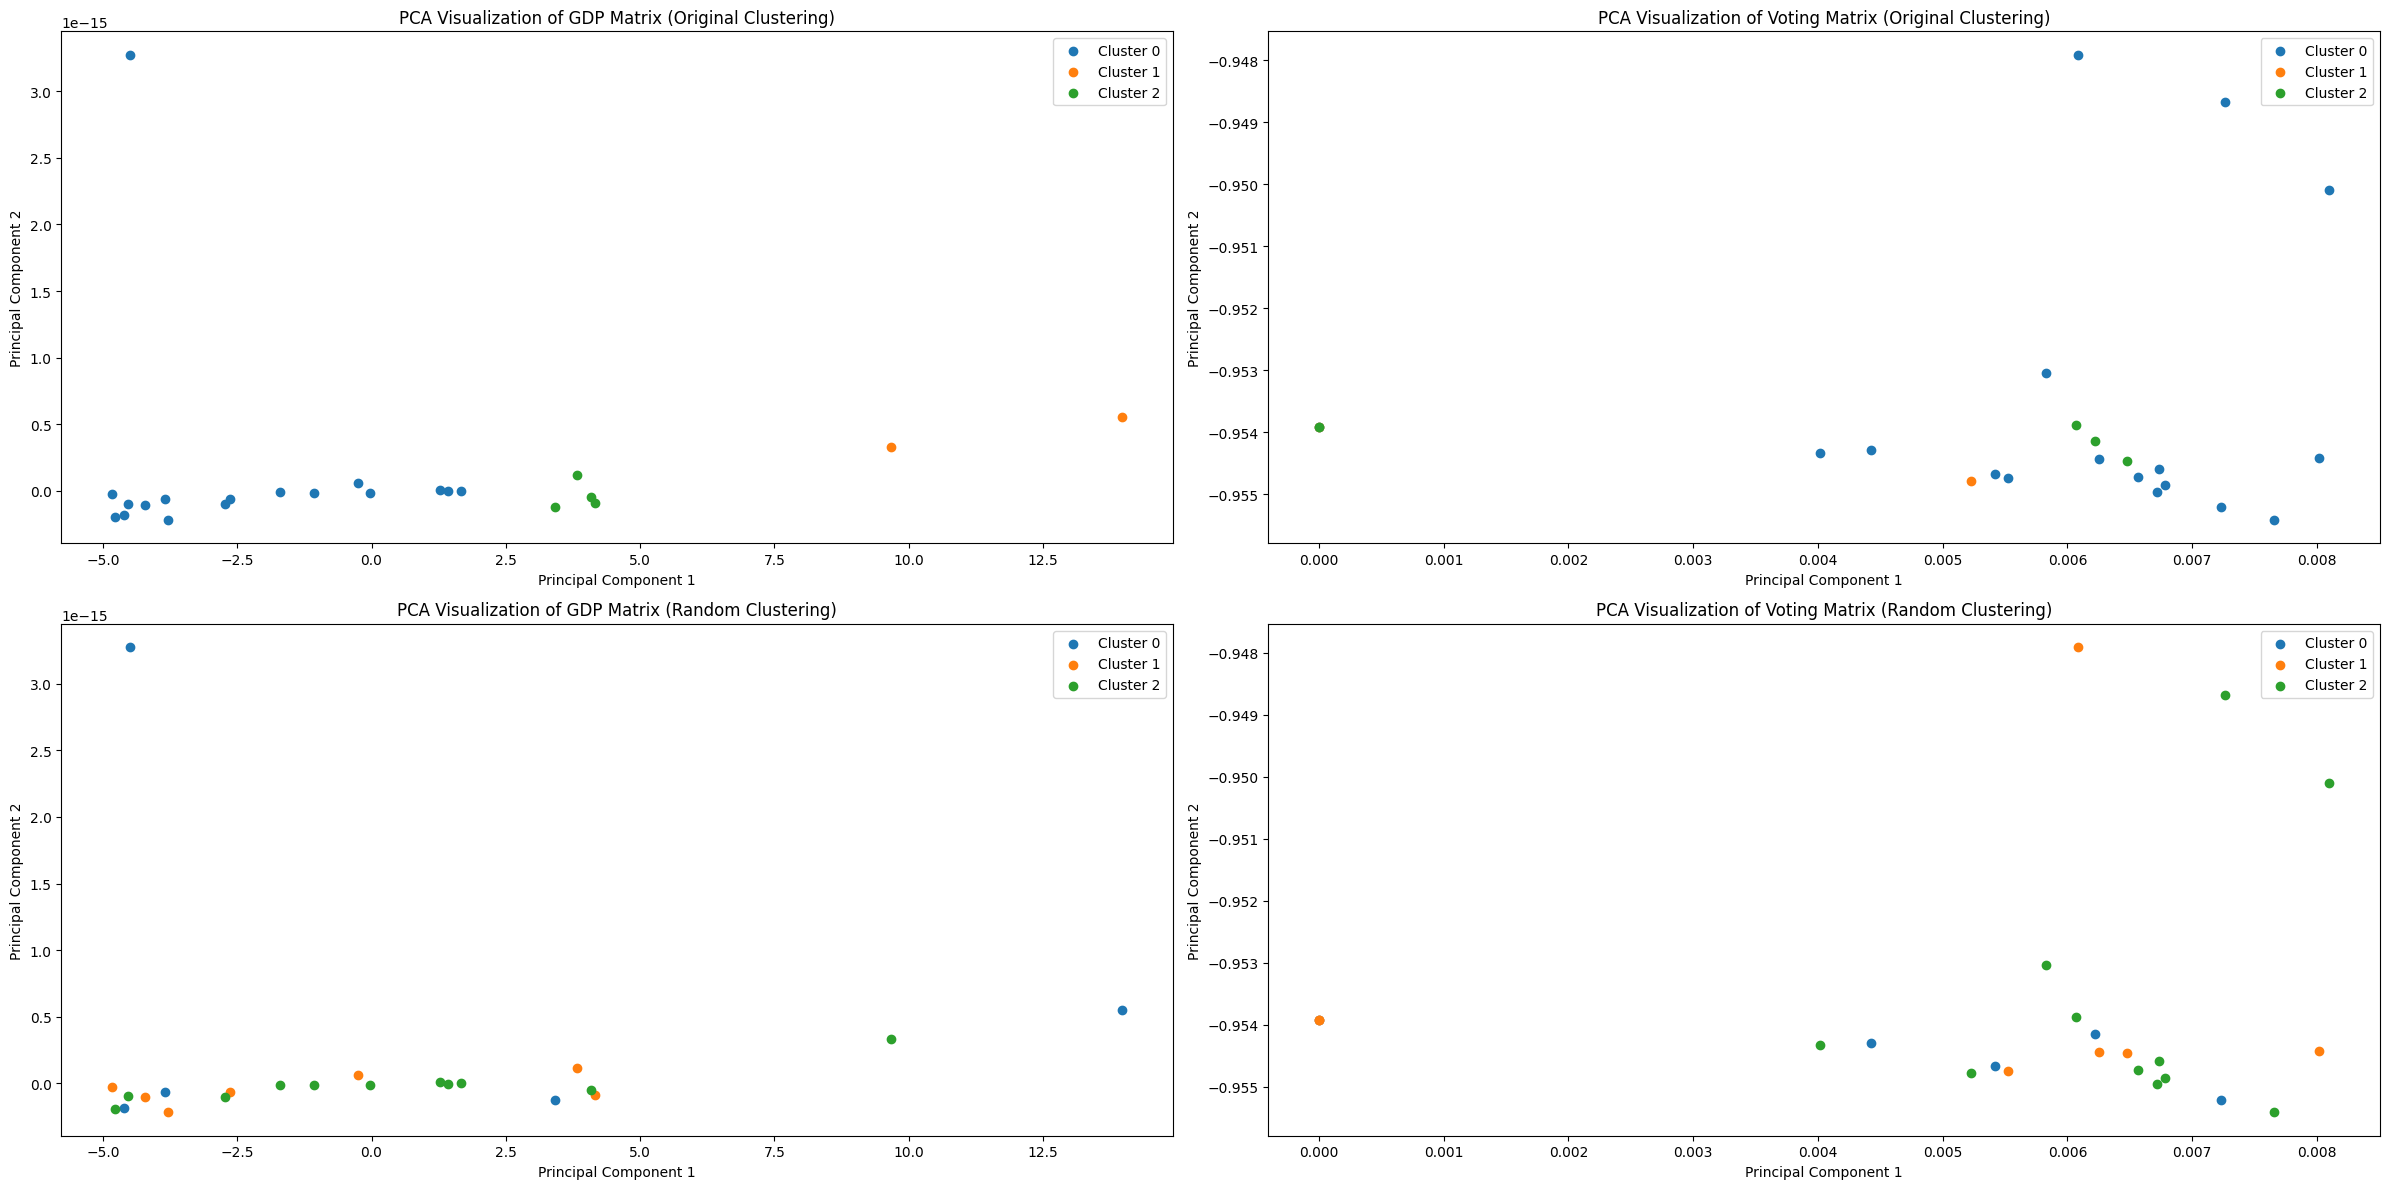

The silhouette score for GDP Matrix (Original) is: 0.5222077361464501
The silhouette score for Voting Matrix (Original) is: -0.11060682741554224
The silhouette score for GDP Matrix (Random) is: -0.12813911959585622
The silhouette score for Voting Matrix (Random) is: -0.06472921210828554


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


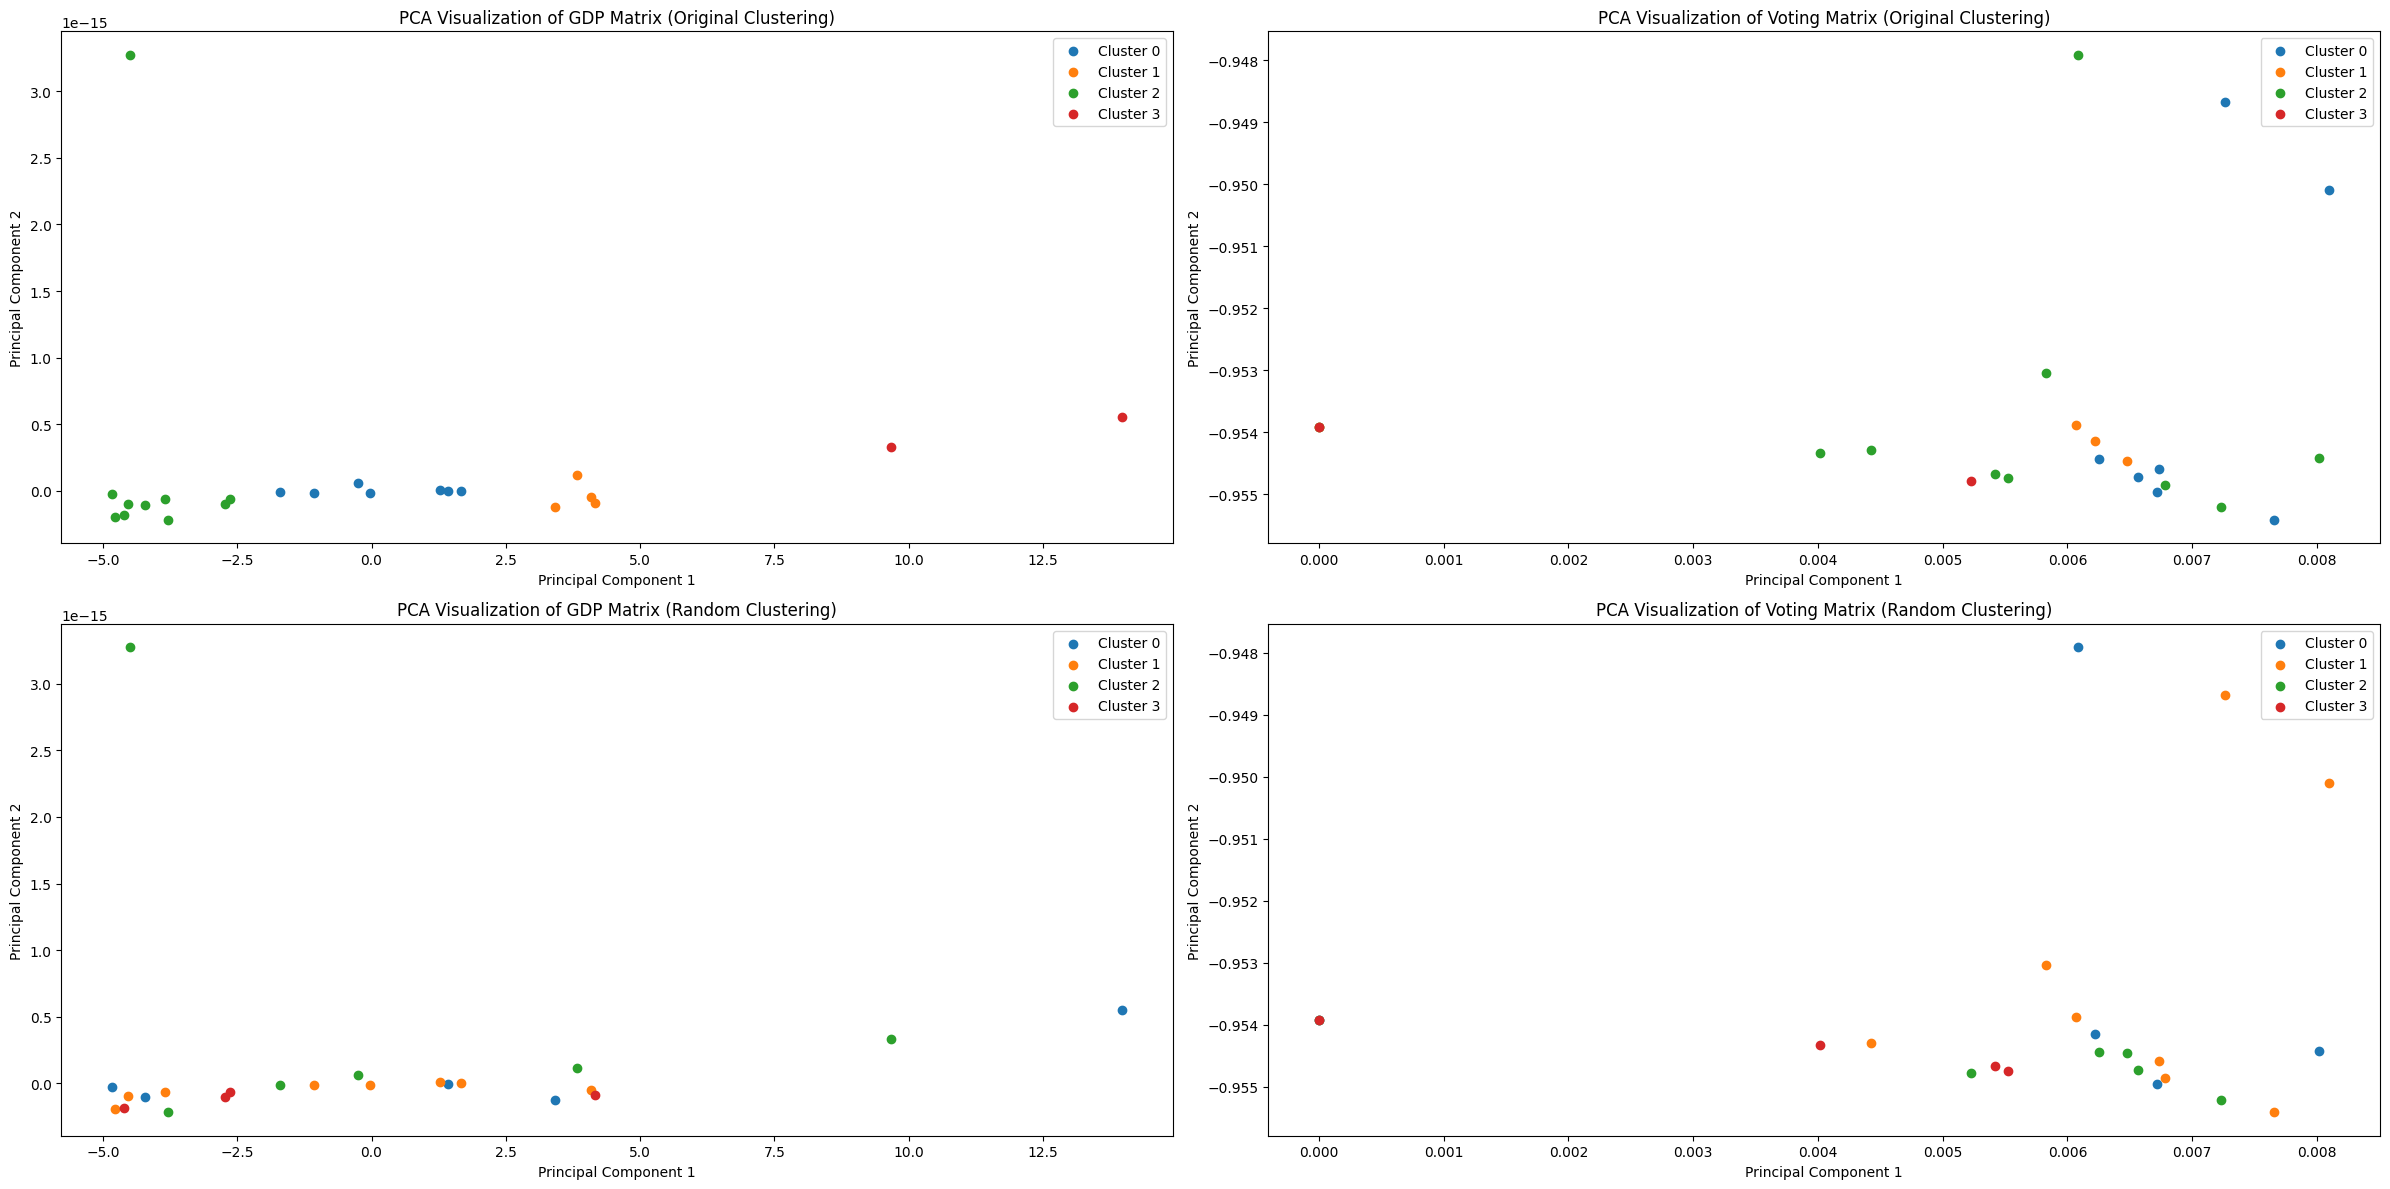

The silhouette score for GDP Matrix (Original) is: 0.6463152669399786
The silhouette score for Voting Matrix (Original) is: -0.11894643528789882
The silhouette score for GDP Matrix (Random) is: -0.22516494409905166
The silhouette score for Voting Matrix (Random) is: -0.08903733483879271


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


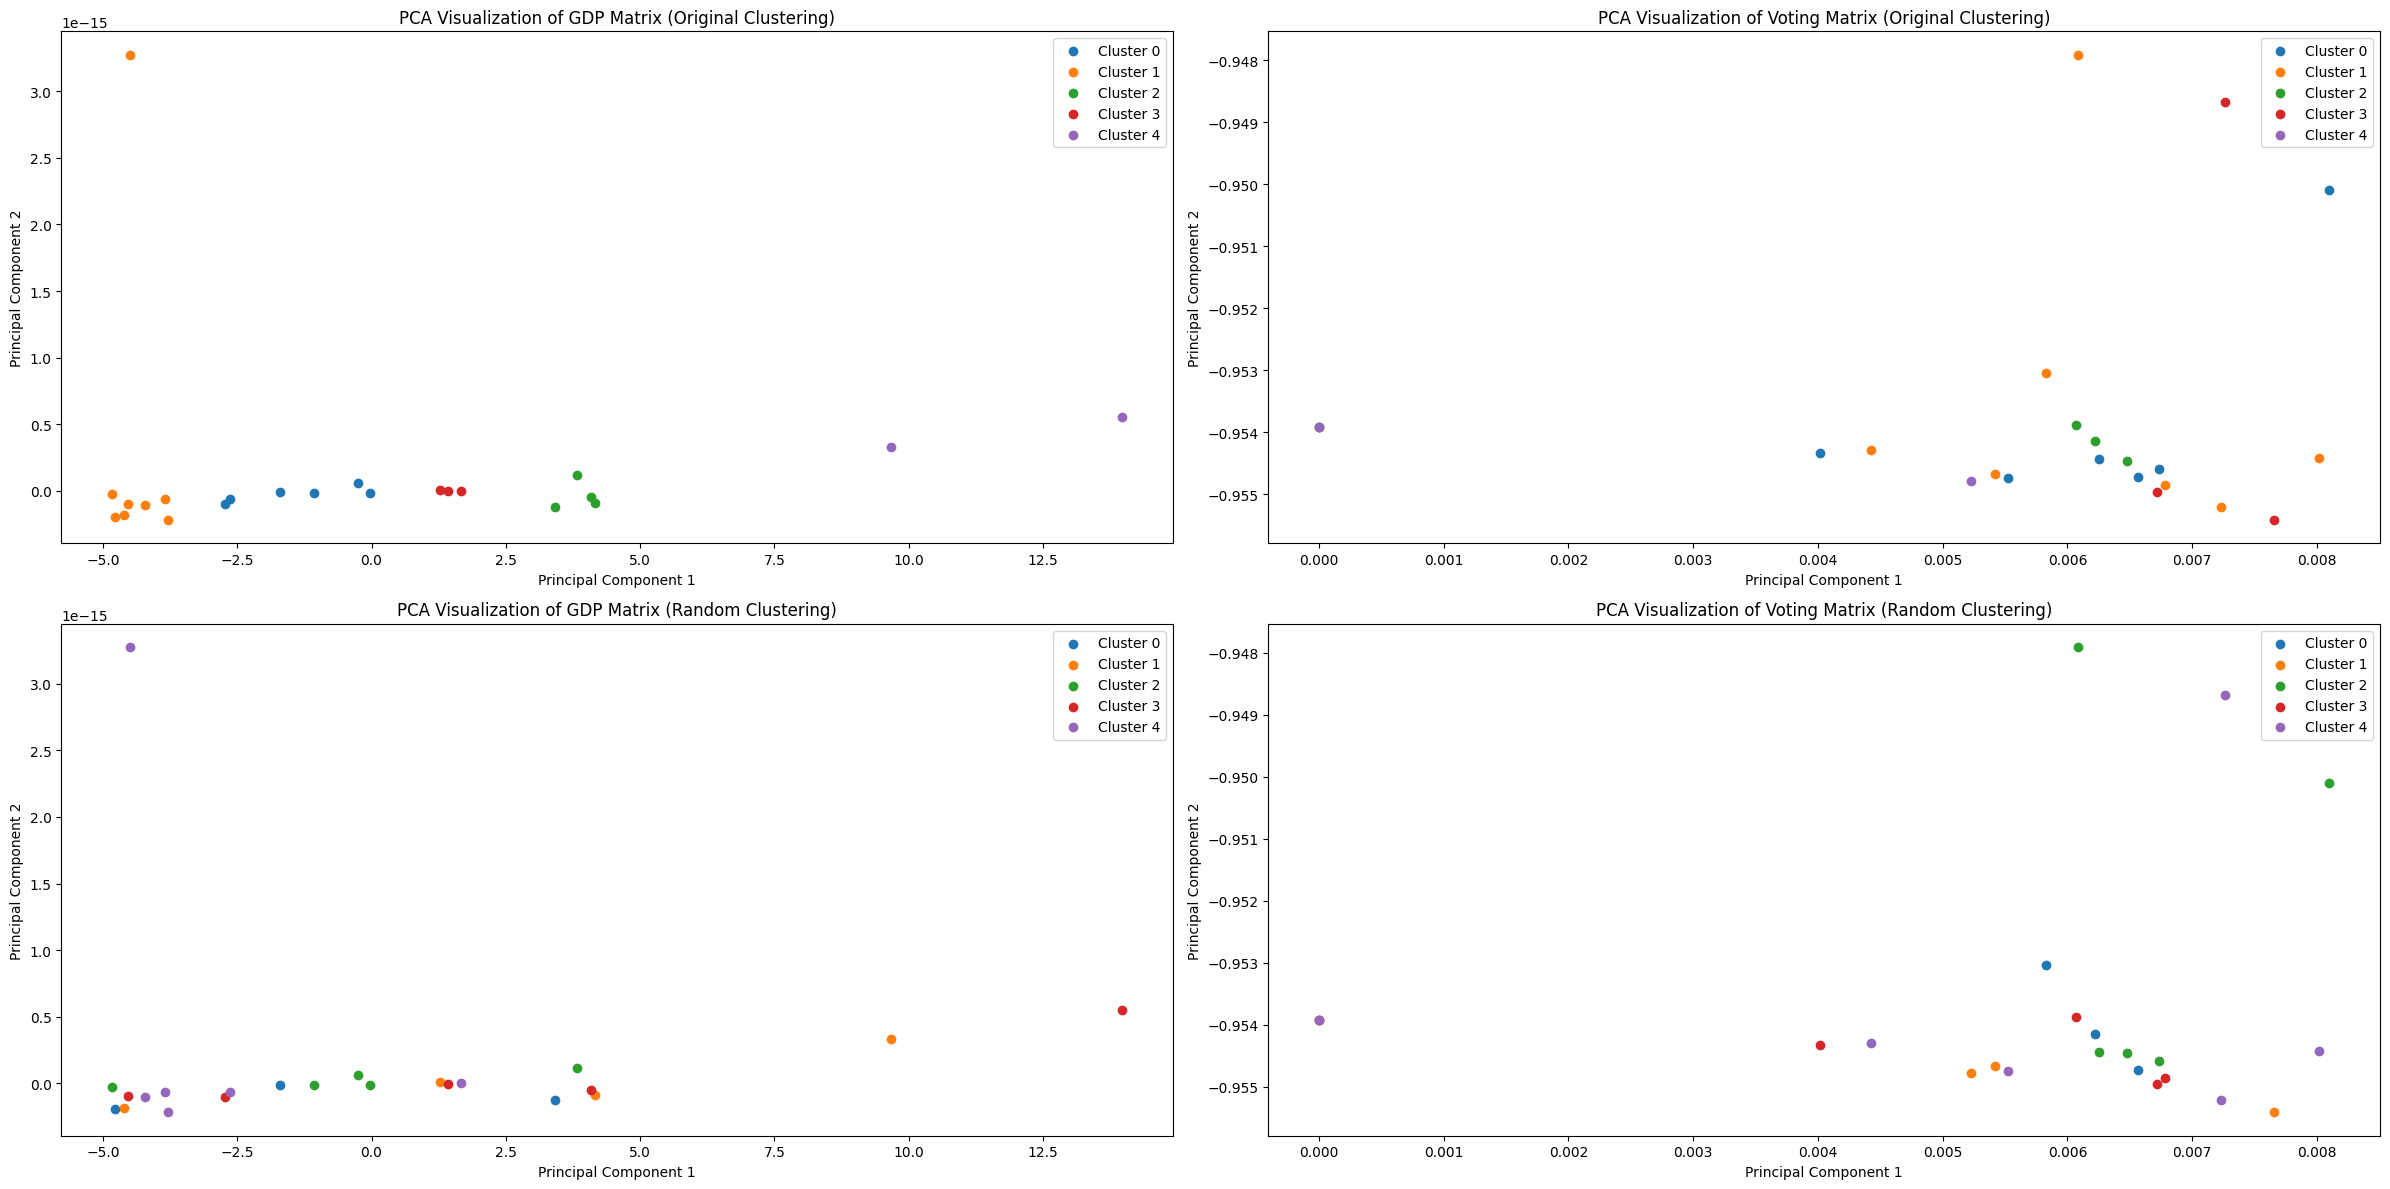

The silhouette score for GDP Matrix (Original) is: 0.643908088718305
The silhouette score for Voting Matrix (Original) is: -0.1295701595345824
The silhouette score for GDP Matrix (Random) is: -0.18077248830992163
The silhouette score for Voting Matrix (Random) is: -0.1351410331542686


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


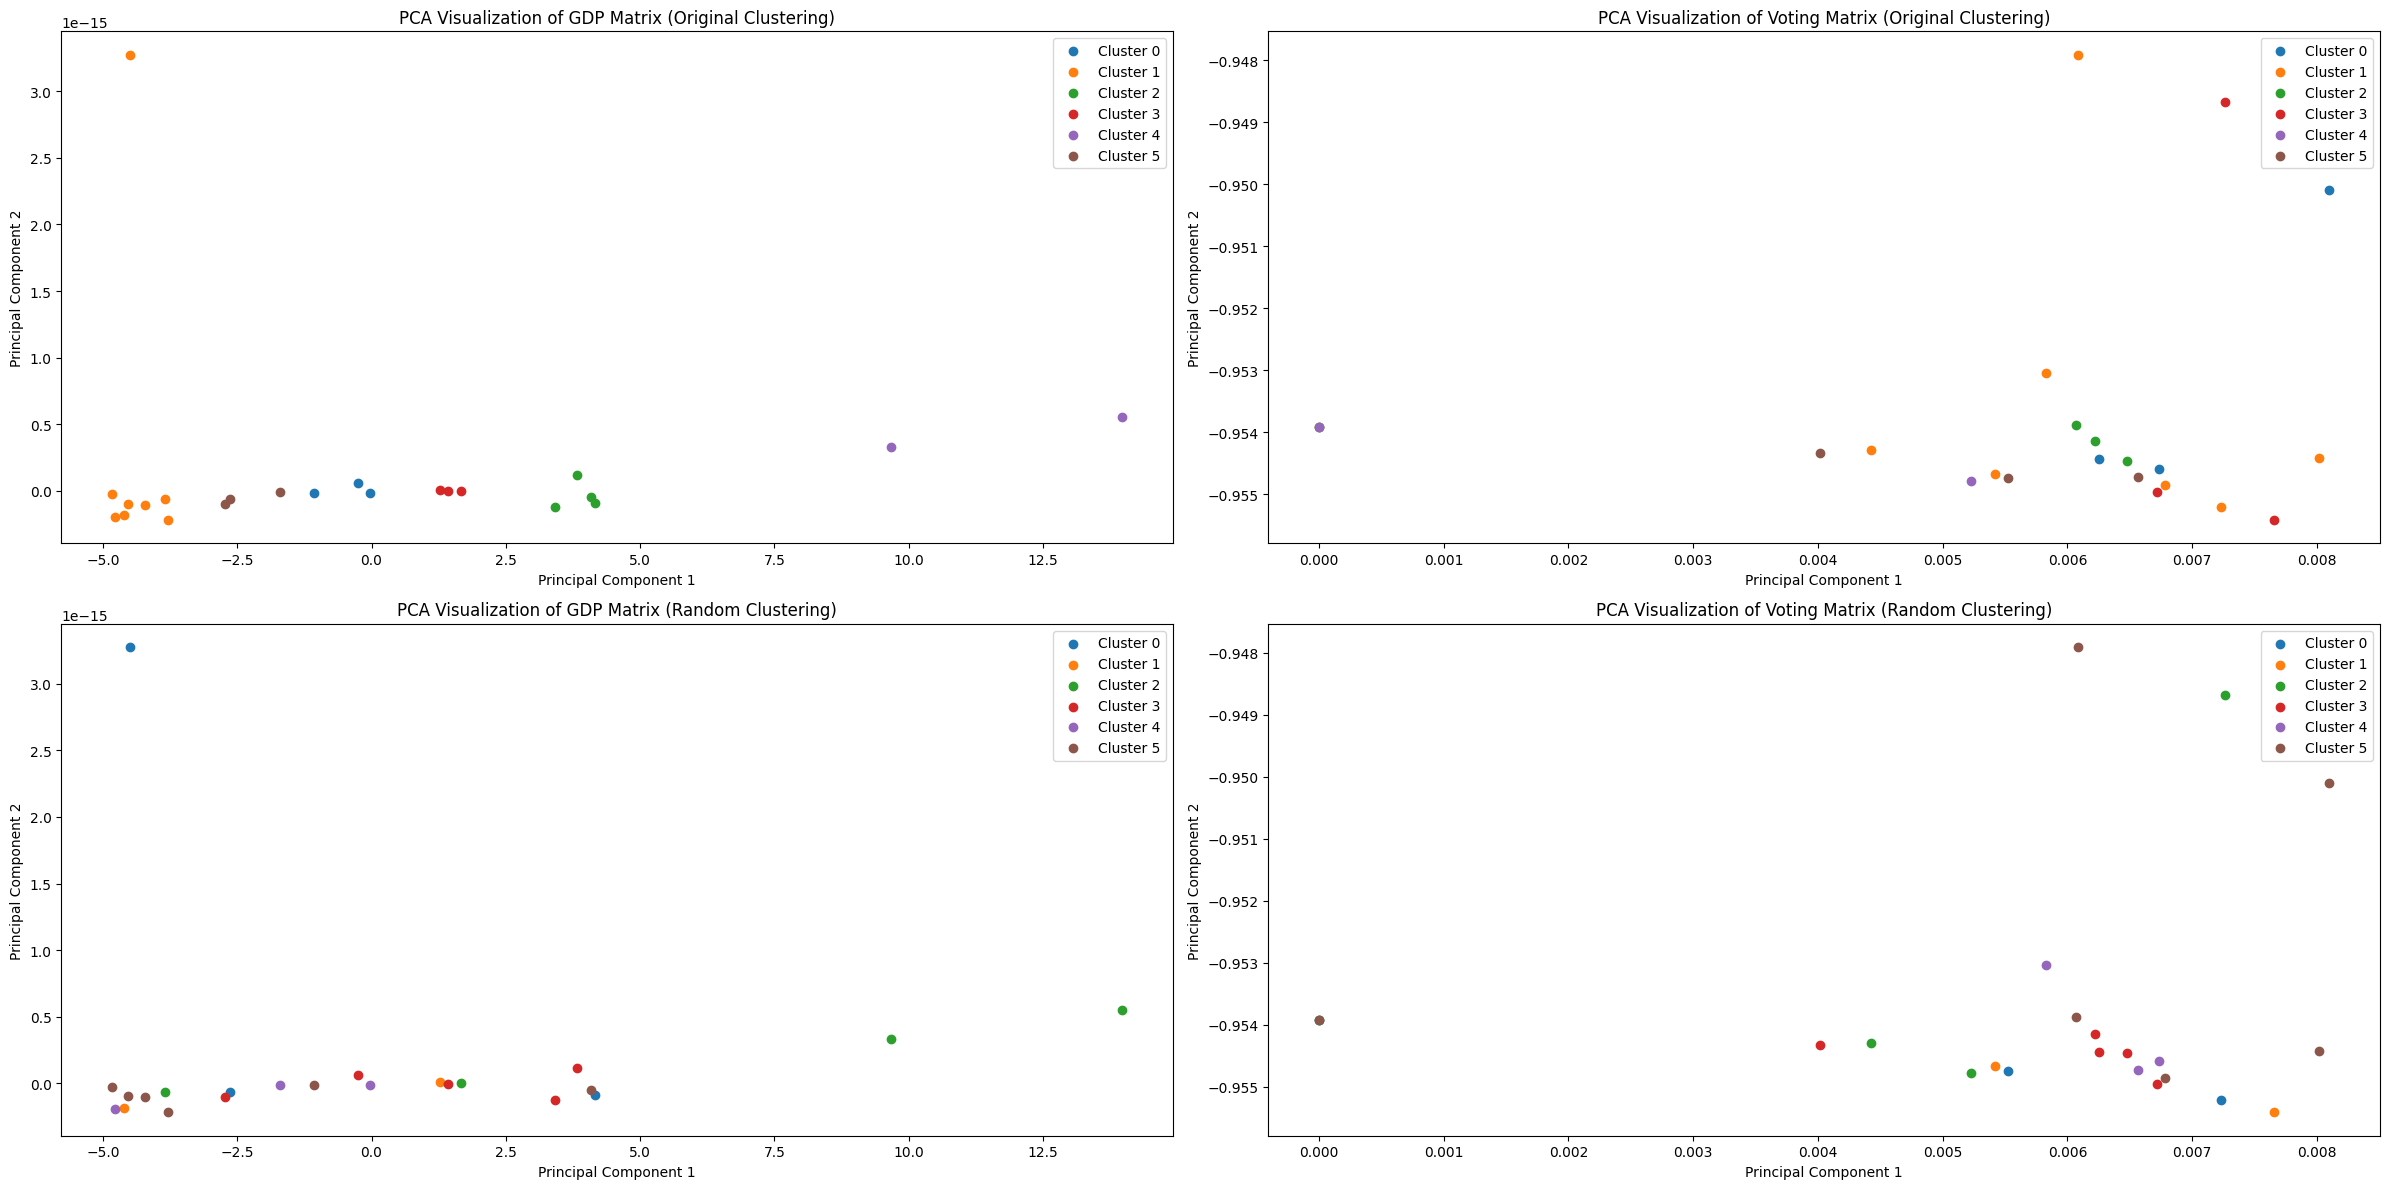

The silhouette score for GDP Matrix (Original) is: 0.6891396740098831
The silhouette score for Voting Matrix (Original) is: -0.1573150976835757
The silhouette score for GDP Matrix (Random) is: -0.2811567875583199
The silhouette score for Voting Matrix (Random) is: -0.09861628363983047


In [6]:
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 3, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 4, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 5, method='KMeans')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 6, method='KMeans')

clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(gdp_difference_matrix, votes_matrix_tele, 6, method='SpectralClustering')